In [1]:
import numpy as np
import pandas as pd
from astropy.cosmology import Planck13 as cosmo
from astropy.io import fits
from astropy.table import Table
import fsps
from matplotlib.gridspec import GridSpec
from spec_tools import Source_present, Scale_model, Oldest_galaxy, Sig_int,Likelihood_contours, Median_w_Error_cont
from spec_extract import Extract_all
from spec_id import Set_rshift_params, Simple_analyze
from spec_exam import Gen_spec, forward_model_grism, forward_model_phot
from spec_stats import Smooth
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model
from C_full_fit import Chi_Squared,Calzetti, Scale_model_mult
from sim_engine import Salmon
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [2]:
gsd_cat = pd.read_pickle('../dataframes/GS_snr.pkl')
gnd_cat = pd.read_pickle('../dataframes/GN_snr.pkl')
snr_cat = pd.read_pickle('../dataframes/high_snr_df.pkl')

In [75]:
def Stack(wv, fl , er, flt, line, cont):
    flgrid = np.transpose(fl)
    fltgrid = np.transpose(flt)
    linegrid = np.transpose(line)
    contgrid = np.transpose(cont)
    errgrid = np.transpose(er)
    weigrid = errgrid ** (-2)
    infmask = np.isinf(weigrid)
    weigrid[infmask] = 0
    ################

    stack, stack_flat, stack_line, stack_cont, err = np.zeros([5, len(wv[0])])
    for i in range(len(wv[0])):
        stack[i] = np.sum(flgrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
        stack_flat[i] = np.sum(fltgrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
        stack_line[i] = np.sum(linegrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
        stack_cont[i] = np.sum(contgrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
        
        err[i] = 1 / np.sqrt(np.sum(weigrid[i]))
    ################
    
    return wv[0], stack, err, stack_flat, stack_line, stack_cont

def Combine_spec(Field,idnum):
    spec_list = glob('/Volumes/Vince_CLEAR/RELEASE_v2.0.0/*{0}*/*/Prep/*{1}*1D.fits'.format(Field, idnum))

    Bwv, Bfl, Ber, Bft, Bln, Bct = [[],[],[],[],[],[]]

    Rwv, Rfl, Rer, Rft, Rln, Rct = [[],[],[],[],[],[]]

    for i in range(len(spec_list)):
        dat = fits.open(spec_list[i])

        try:
            Bwv.append(np.array(dat['G102'].data['wave']).T)
            Bfl.append(np.array(dat['G102'].data['flux']).T)
            Ber.append(np.array(dat['G102'].data['err']).T)
            Bft.append(np.array(dat['G102'].data['flat']).T)
            Bln.append(np.array(dat['G102'].data['line']).T)
            Bct.append(np.array(dat['G102'].data['cont']).T)

        except:
            print('no g102')

        try:
            Rwv.append(np.array(dat['G141'].data['wave']).T)
            Rfl.append(np.array(dat['G141'].data['flux']).T)
            Rer.append(np.array(dat['G141'].data['err']).T)
            Rft.append(np.array(dat['G141'].data['flat']).T)
            Rln.append(np.array(dat['G141'].data['line']).T)
            Rct.append(np.array(dat['G141'].data['cont']).T)

        except:
            print('no g141')
    SBW, SBF, SBE, SBT, SBL, SBC = Stack(Bwv, Bfl, Ber, Bft, Bln, Bct)
    SRW, SRF, SRE, SRT, SRL, SRC = Stack(Rwv, Rfl, Rer, Rft, Rln, Rct)
    
    return np.array([SBW, SBF, SBE, SBT, SBL, SBC]), np.array([SRW, SRF, SRE, SRT, SRL, SRC])

In [76]:
B,R = Combine_spec('S',40597)

no g102


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in power
  import sys
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered

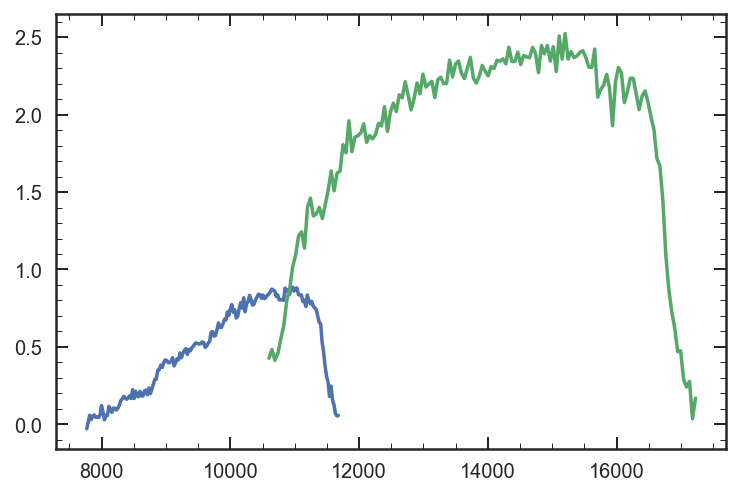

In [80]:
plt.plot(B[0],B[1])
plt.plot(R[0],R[1])


In [92]:
beam_list = glob('/Volumes/Vince_CLEAR/RELEASE_v2.0.0/*S*/*/Prep/*40597*beams.fits')

In [101]:
fields = [U.split('/')[4] for U in beam_list]

In [103]:
flt_list = glob('/Volumes/Vince_CLEAR/RELEASE_v2.0.0/{0}/*/Prep/*GrismFLT.fits'.format(fields[0]))

In [119]:
# grp = multifit.GroupFLT(grism_files = glob('/Volumes/Vince_CLEAR/RELEASE_v2.0.0/{0}/*/Prep/*GrismFLT.fits'.format(fields[0])))
# grp2 = multifit.GroupFLT(grism_files = glob('/Volumes/Vince_CLEAR/RELEASE_v2.0.0/{0}/*/Prep/*GrismFLT.fits'.format(fields[1])))
grp = 0;grp2= 0

In [117]:
ex = Extract_all(40597,'GSD',[grp,grp2])

In [118]:
ex.Phot_save()
ex.Extract_spec()
ex.Extract_BeamCutout()

no g102


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in power
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in double_scalars
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in double_scalars
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in double_scalars
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in double_scalars


In [2]:
gs = Gen_spec('GSD',40597,1.221, '../beams/o149.0_40597.g102.A.fits', '../beams/o185.0_40597.g141.A.fits',
              g102_lims=[7500,12000],g141_lims=[10000,18000],tmp_err=False)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


<ErrorbarContainer object of 3 artists>

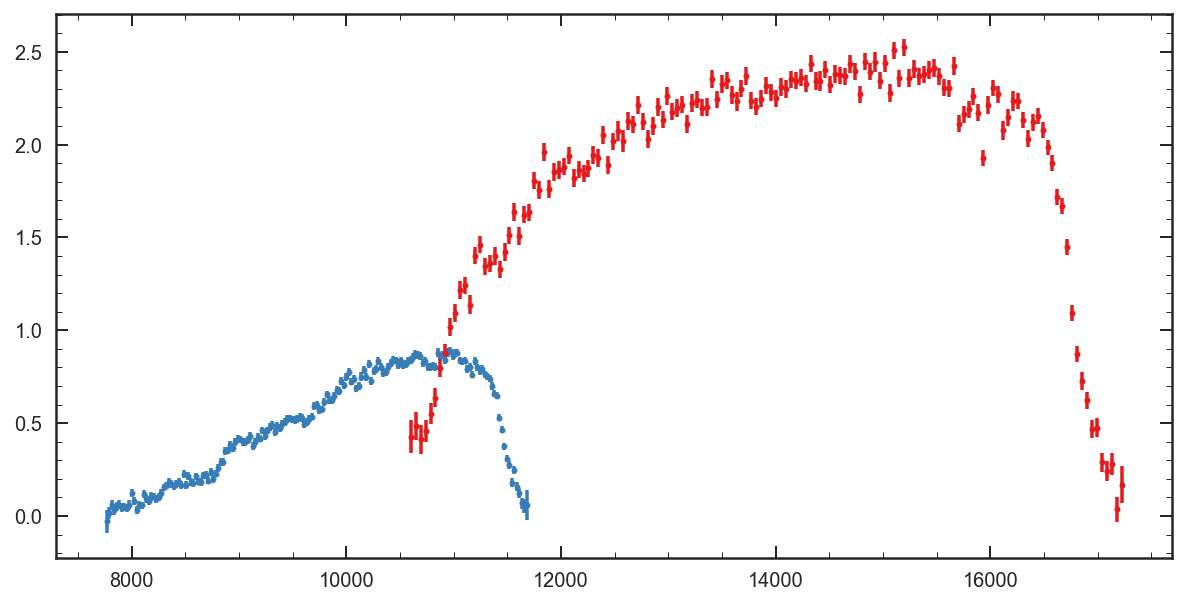

In [4]:
plt.figure(figsize=[10,5])
plt.errorbar(gs.Bwv,gs.Bflx,gs.Berr,
                linestyle='None', marker='o', markersize=3, color='#377eb8')
plt.errorbar(gs.Rwv,gs.Rflx,gs.Rerr,
            linestyle='None', marker='o', markersize=3, color='#e41a1c')

## Plot bestfits

In [2]:
flist = glob('../data/out_dict/*bestfit*')

field = [os.path.basename(U).split('_')[0] for U in flist]
galaxy = np.array([os.path.basename(U.replace('.npy','')).split('_')[1] for U in flist]).astype(np.int)

In [ ]:
def Get_bestfits(field, galaxy):
    params = ['Z','t','tau1','tau1','tau1','tau1','tau1','rs','d']
    bestfits =[]
    for i in params
    #iterate over all paramter sets to get array of best fits
    return best_fits

cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:235: RuntimeWarning: divide by zero encountered in log10
  delta = 0.62 * np.log10(Av/Rv) + 0.26
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:237: RuntimeWarning: invalid value encountered in multiply
  sal = 10**(-0.4*k*(lam / lamv)**(delta)*Av/Rv)
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:244: RuntimeWarning: divide by zero encountered in log10
  delta = 0.62 * np.log10(Av/Rv) + 0.26
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:246: RuntimeWarning: invalid value encountered in multiply
  sal = 10**(-0.4*k*(lam / lamv)**(delta)*Av/Rv)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


missing g141
cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:235: RuntimeWarning: divide by zero encountered in log10
  delta = 0.62 * np.log10(Av/Rv) + 0.26
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:237: RuntimeWarning: invalid value encountered in multiply
  sal = 10**(-0.4*k*(lam / lamv)**(delta)*Av/Rv)
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:244: RuntimeWarning: divide by zero encountered in log10
  delta = 0.62 * np.log10(Av/Rv) + 0.26
/Users/Vince.ec/

cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:235: RuntimeWarning: divide by zero encountered in log10
  delta = 0.62 * np.log10(Av/Rv) + 0.26
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:237: RuntimeWarning: invalid value encountered in multiply
  sal = 10**(-0.4*k*(lam / lamv)**(delta)*Av/Rv)
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:244: RuntimeWarning: divide by zero encountered in log10
  delta = 0.62 * np.log10(Av/Rv) + 0.26
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:246: RuntimeWarning: invalid value encountered in multiply
  sal = 10**(-0.4*k*(lam / lamv)**(delta)*Av/Rv)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:235: RuntimeWarning: divide by zero encountered in log10
  delta = 0.62 * np.log10(Av/Rv) + 0.26
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:237: RuntimeWarning: invalid value encountered in multiply
  sal = 10**(-0.4*k*(lam / lamv)**(delta)*Av/Rv)
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:244: RuntimeWarning: divide by zero encountered in log10
  delta = 0.62 * np.log10(Av/Rv) + 0.26
/Users/Vince.ec/

cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


missing g102


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


missing g141


/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:235: RuntimeWarning: divide by zero encountered in log10
  delta = 0.62 * np.log10(Av/Rv) + 0.26
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:237: RuntimeWarning: invalid value encountered in multiply
  sal = 10**(-0.4*k*(lam / lamv)**(delta)*Av/Rv)
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:244: RuntimeWarning: divide by zero encountered in log10
  delta = 0.62 * np.log10(Av/Rv) + 0.26
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:246: RuntimeWarning: invalid value encountered in multiply
  sal = 10**(-0.4*k*(lam / lamv)**(delta)*Av/Rv)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


missing g141


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:235: RuntimeWarning: divide by zero encountered in log10
  delta = 0.62 * np.log10(Av/Rv) + 0.26
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:237: RuntimeWarning: invalid value encountered in multiply
  sal = 10**(-0.4*k*(lam / lamv)**(delta)*Av/Rv)
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:244: RuntimeWarning: divide by zero encountered in log10
  delta = 0.62 * np.log10(Av/Rv) + 0.26
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:246: RuntimeWarning: invalid value encountered in multiply
  sal = 10**(-0.4*k*(lam / lamv)**(delta)*Av/Rv)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/pyplot.py:5

missing g102


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:235: RuntimeWarning: divide by zero encountered in log10
  delta = 0.62 * np.log10(Av/Rv) + 0.26
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:237: RuntimeWarning: invalid value encountered in multiply
  sal = 10**(-0.4*k*(lam / lamv)**(delta)*Av/Rv)
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:244: RuntimeWarning: divide by zero encountered in log10
  delta = 0.62 * np.log10(Av/Rv) + 0.26
/Users/Vince.ec/

cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


missing g141


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:235: RuntimeWarning: divide by zero encountered in log10
  delta = 0.62 * np.log10(Av/Rv) + 0.26
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:237: RuntimeWarning: invalid value encountered in multiply
  sal = 10**(-0.4*k*(lam / lamv)**(delta)*Av/Rv)
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:244: RuntimeWarning: divide by zero encountered in log10
  delta = 0.62 * np.log10(Av/Rv) + 0.26
/Users/Vince.ec/

cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


missing g102


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:235: RuntimeWarning: divide by zero encountered in log10
  delta = 0.62 * np.log10(Av/Rv) + 0.26
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:237: RuntimeWarning: invalid value encountered in multiply
  sal = 10**(-0.4*k*(lam / lamv)**(delta)*Av/Rv)
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:244: RuntimeWarning: divide by zero encountered in log10
  delta = 0.62 * np.log10(Av/Rv) + 0.26
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:246: RuntimeWarning: invalid value encountered in multiply
  sal = 10**(-0.4*k*(lam / lamv)**(delta)*Av/Rv)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/pyplot.py:5

cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


missing g102


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


missing g102


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:235: RuntimeWarning: divide by zero encountered in log10
  delta = 0.62 * np.log10(Av/Rv) + 0.26
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:237: RuntimeWarning: invalid value encountered in multiply
  sal = 10**(-0.4*k*(lam / lamv)**(delta)*Av/Rv)
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:244: RuntimeWarning: divide by zero encountered in log10
  delta = 0.62 * np.log10(Av/Rv) + 0.26
/Users/Vince.ec/

cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


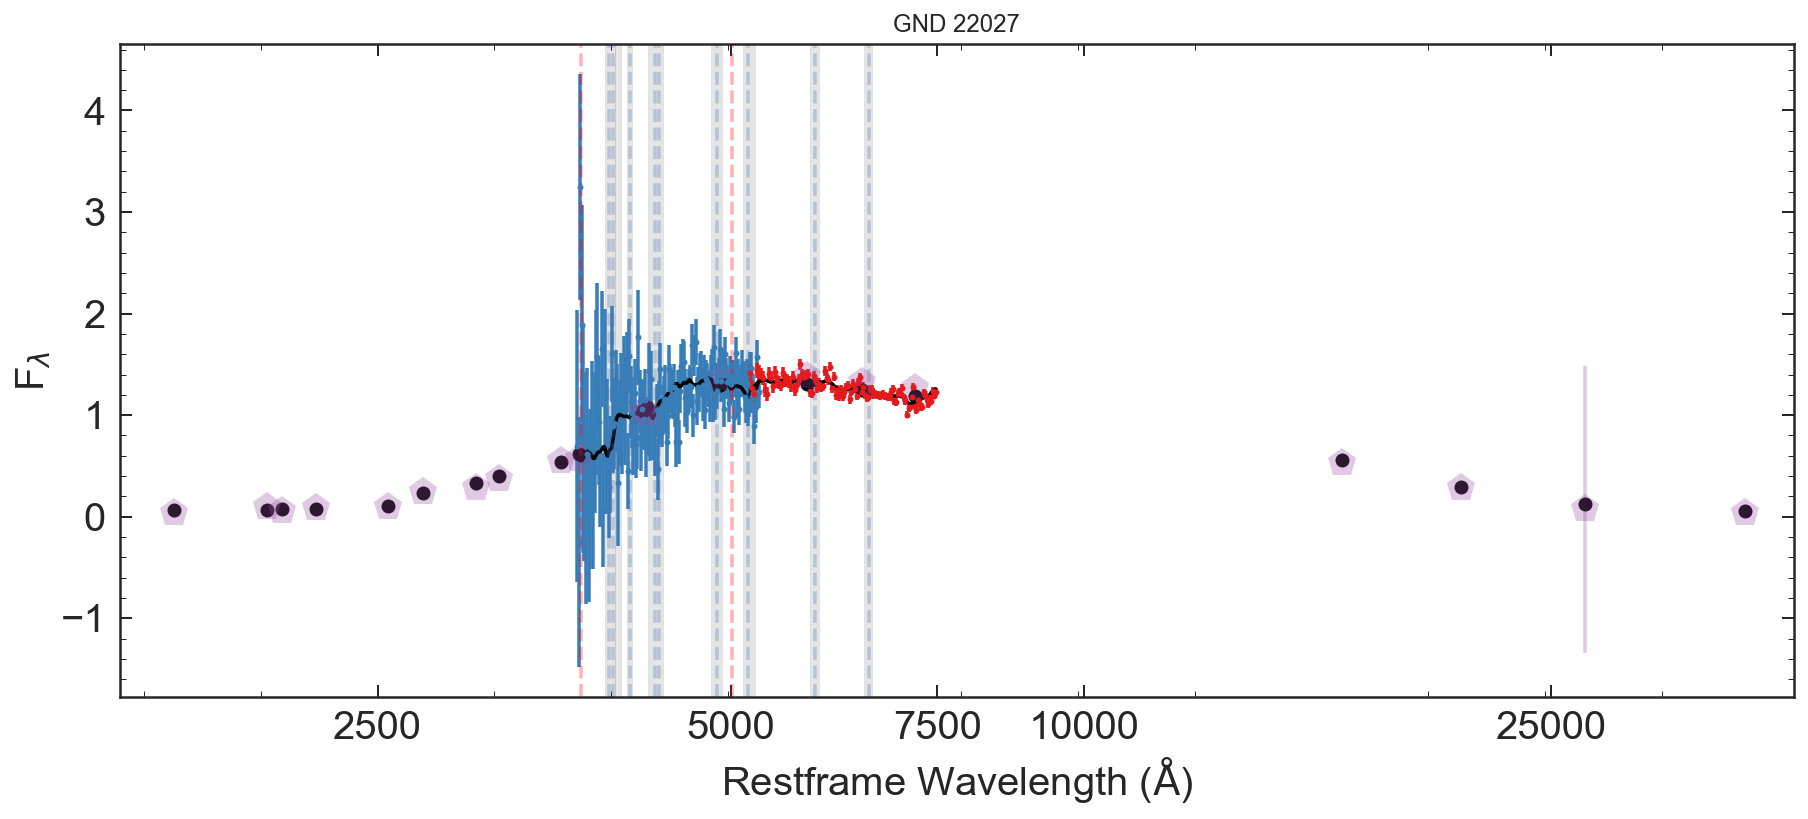

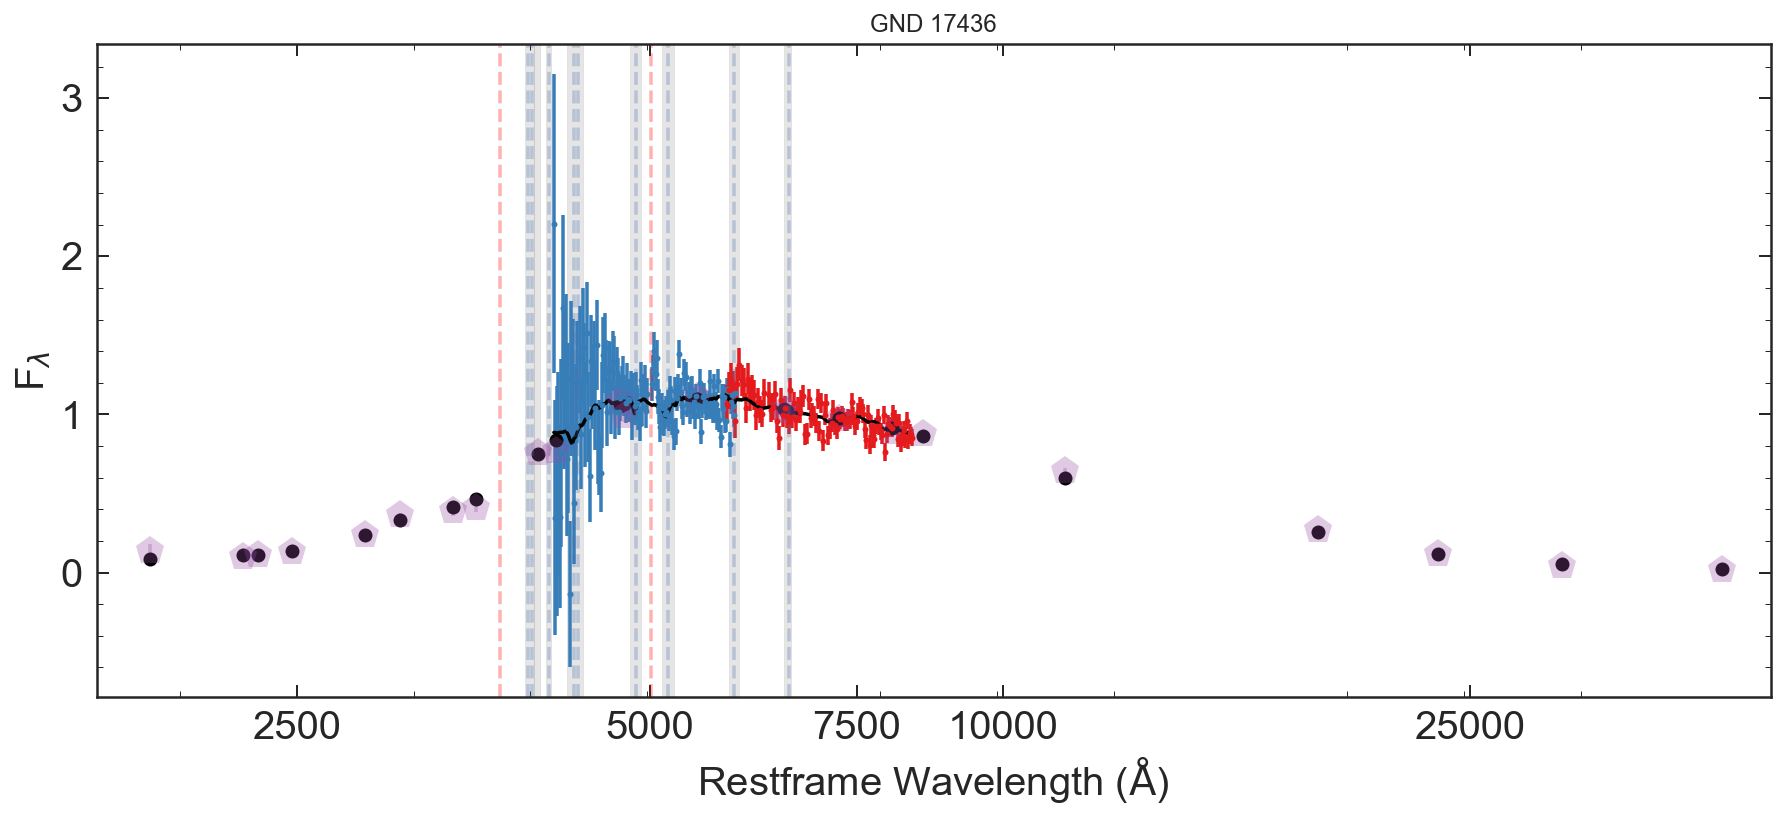

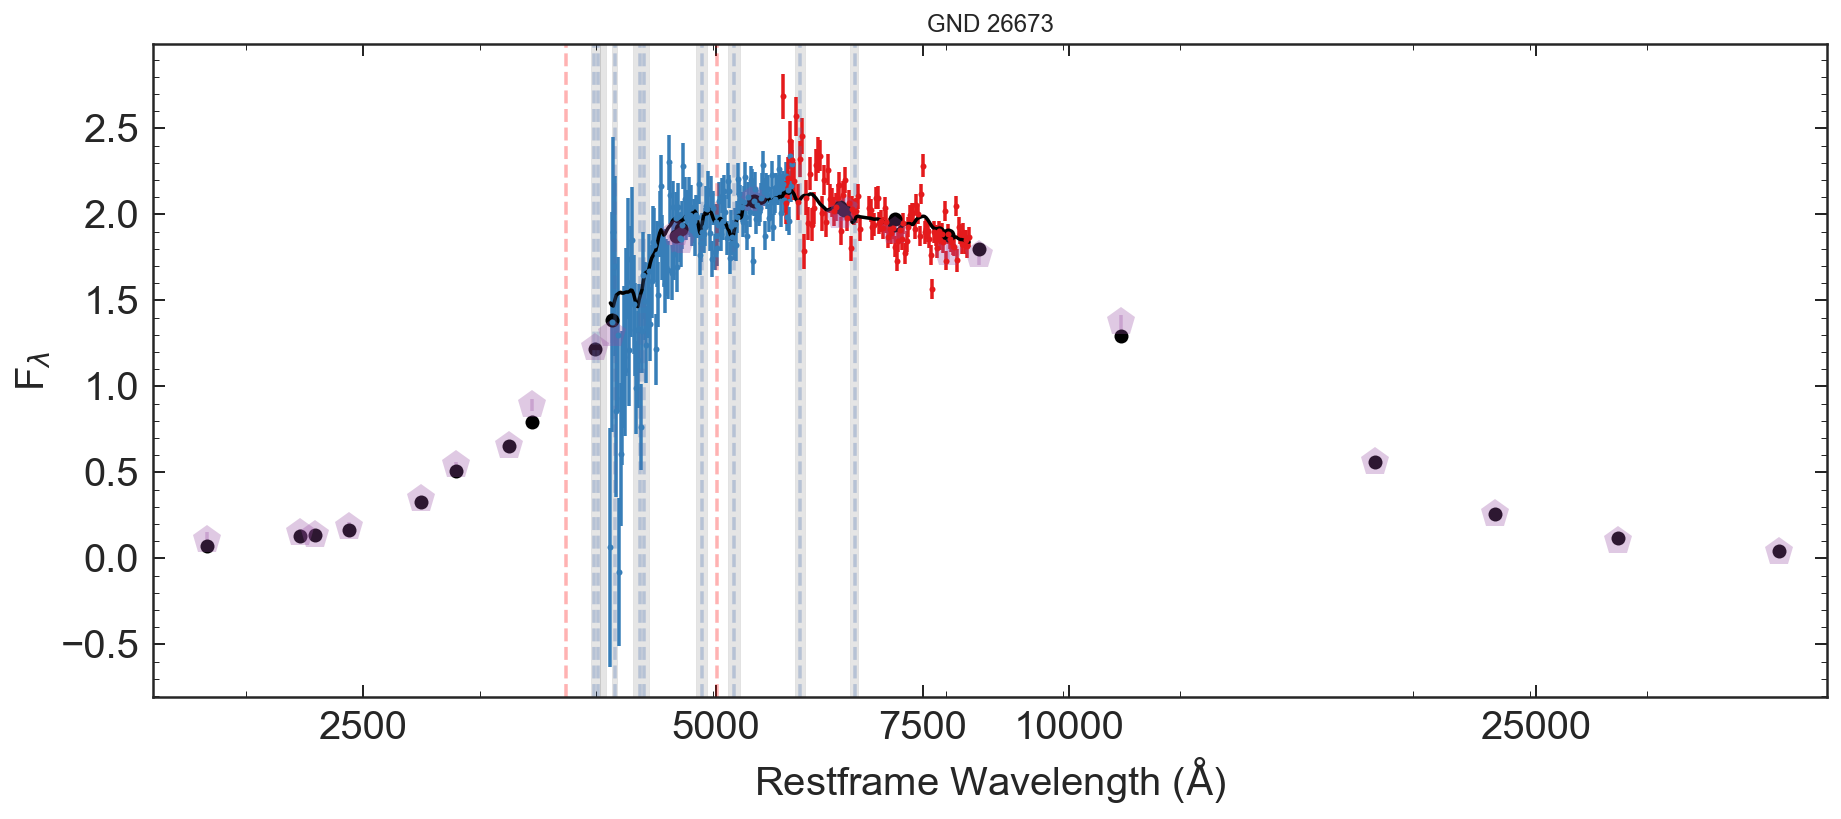

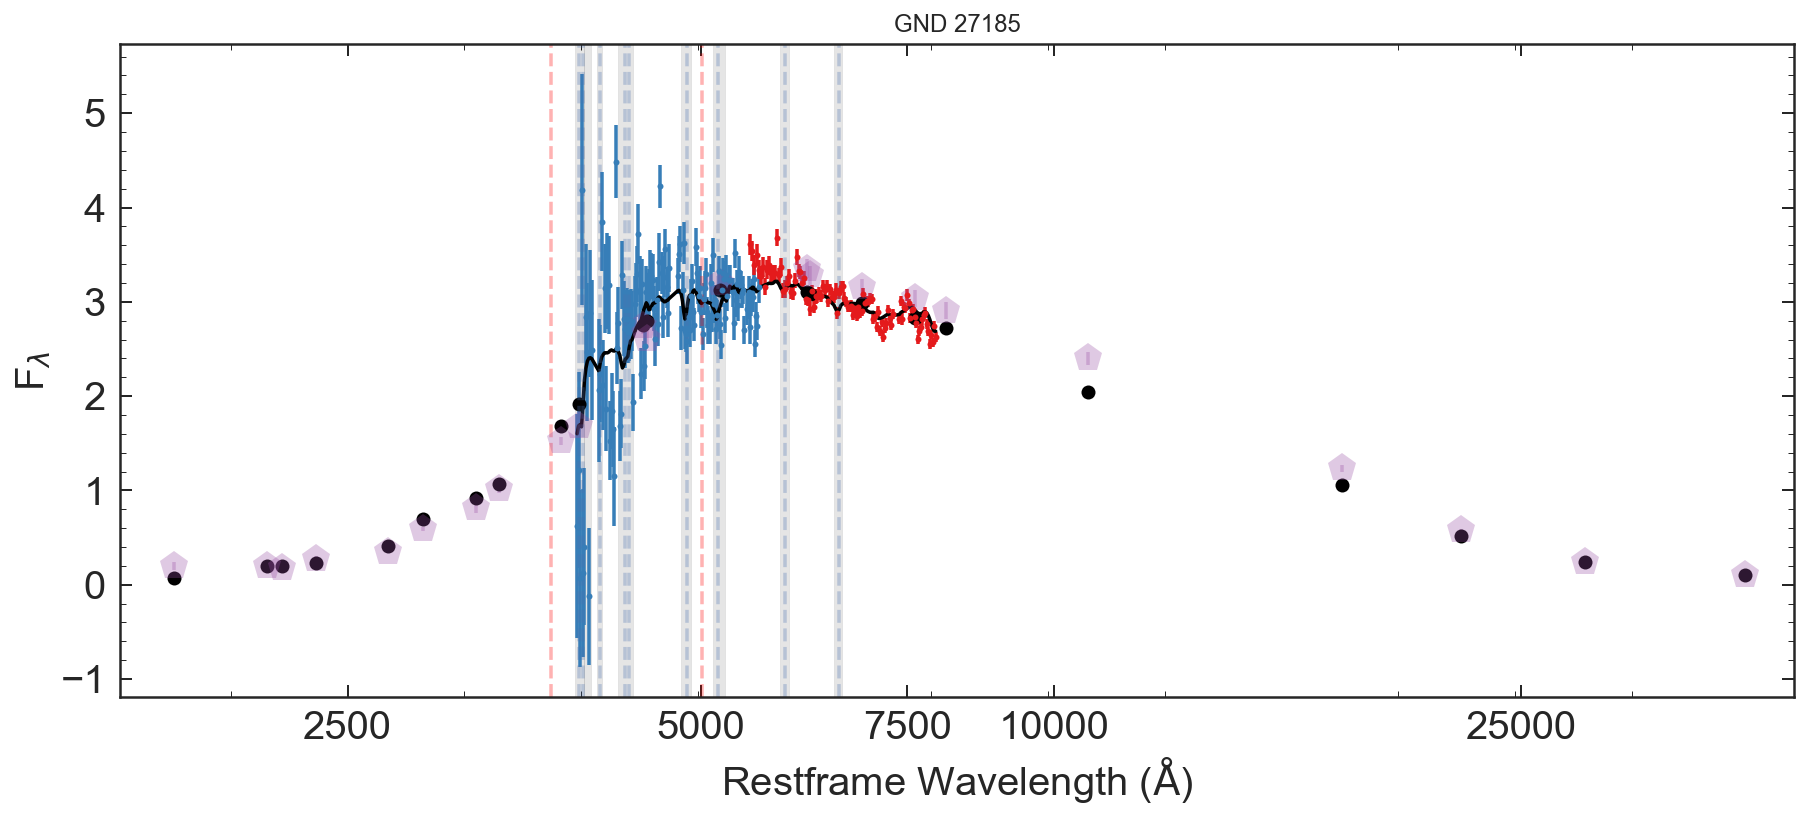

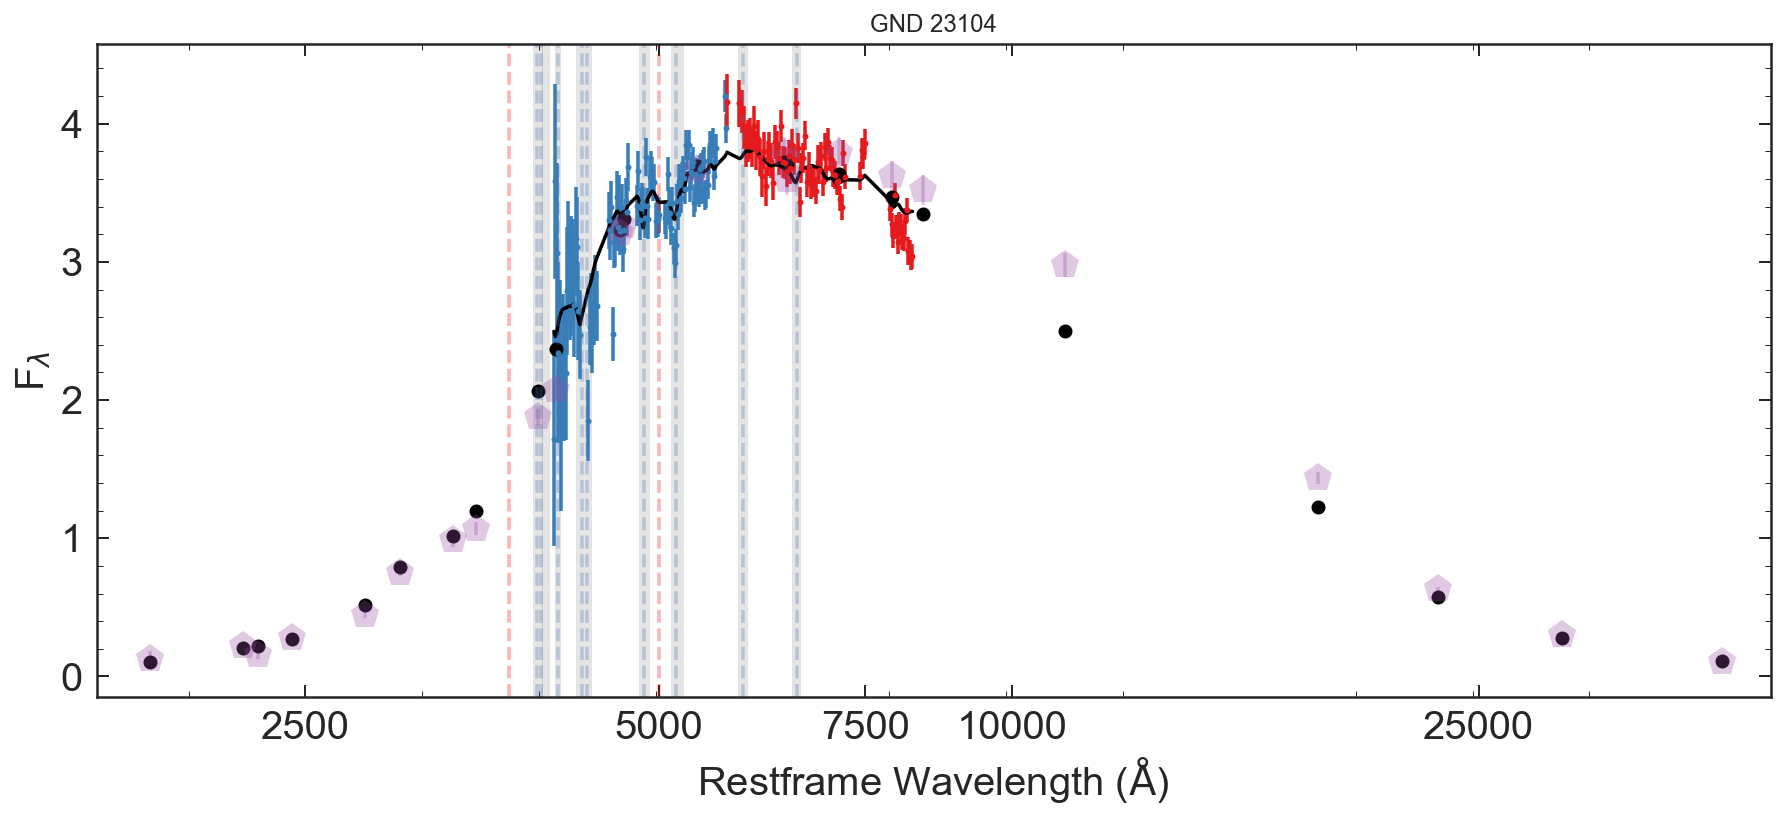

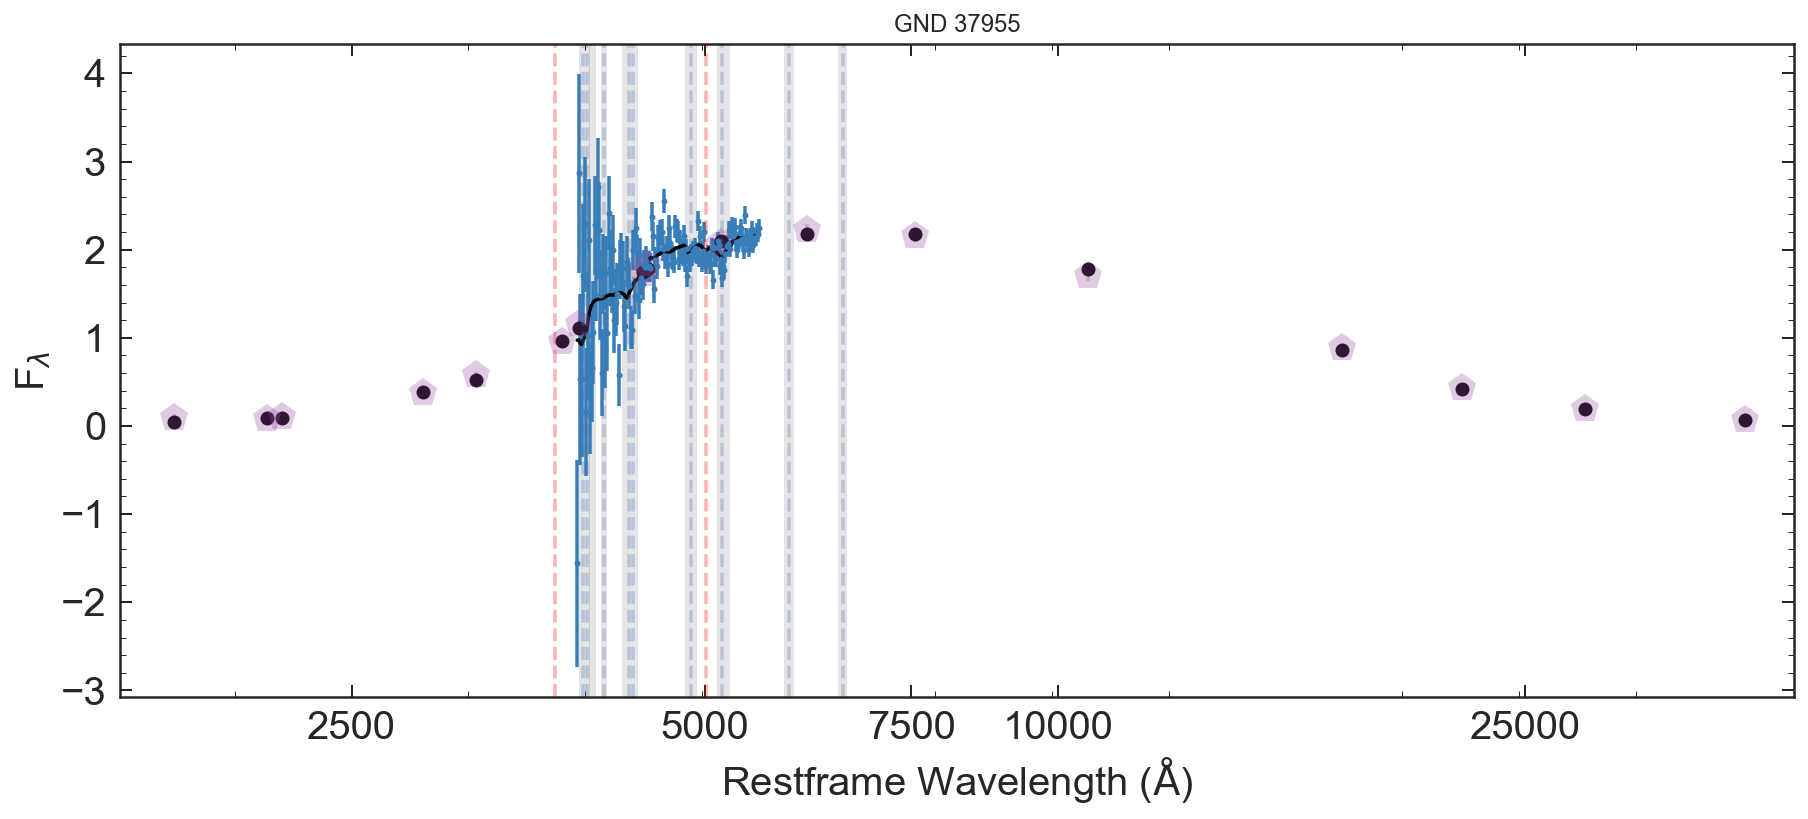

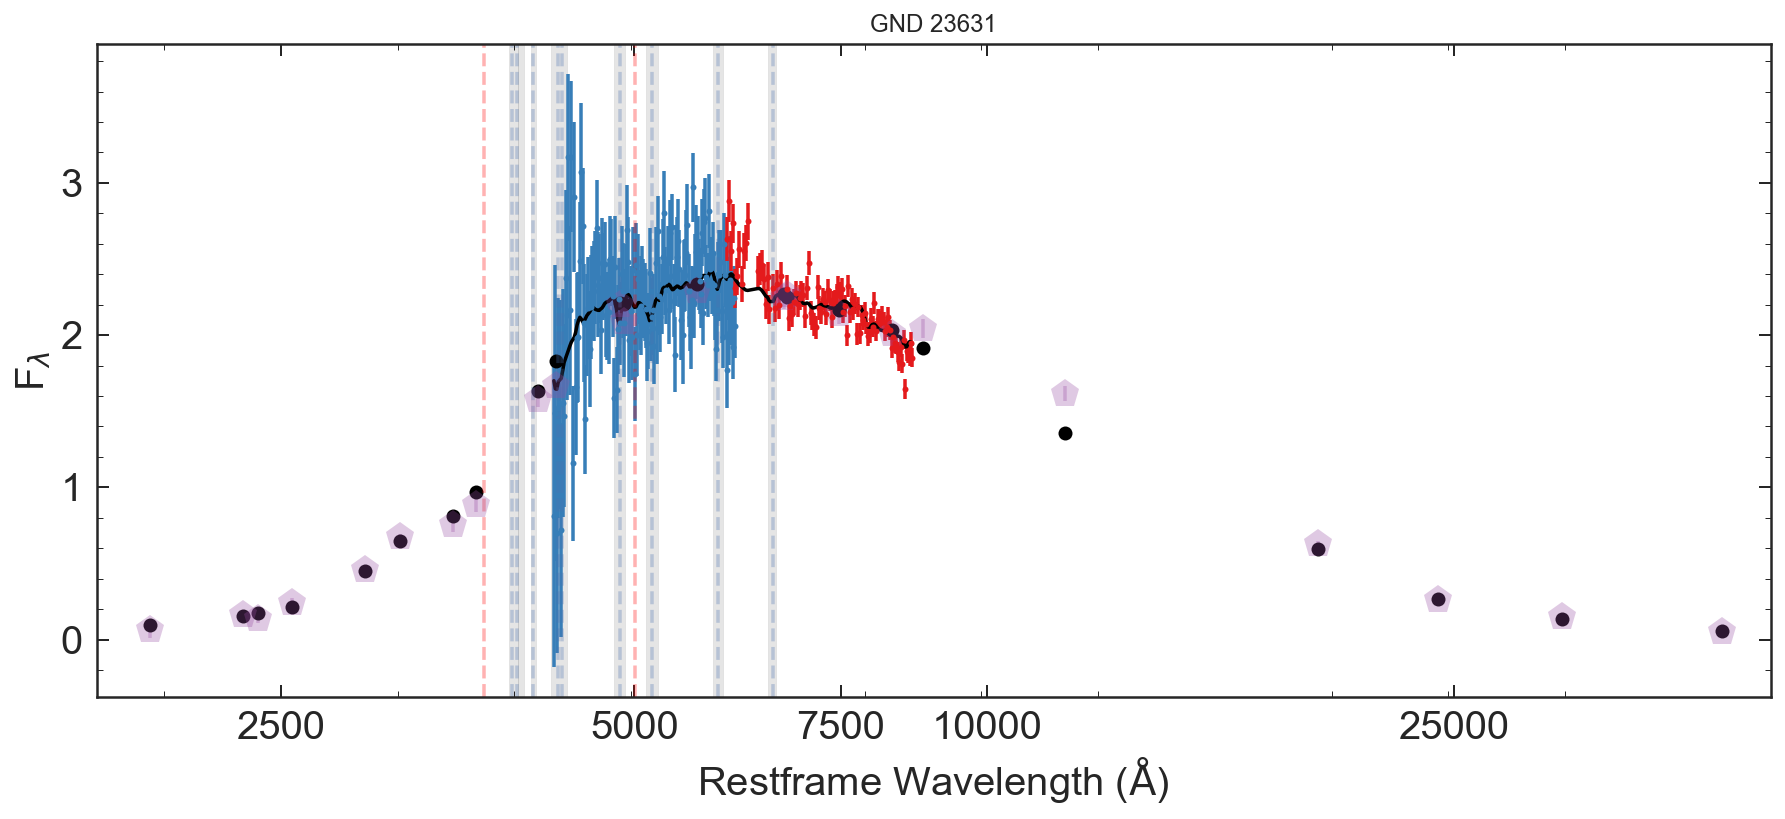

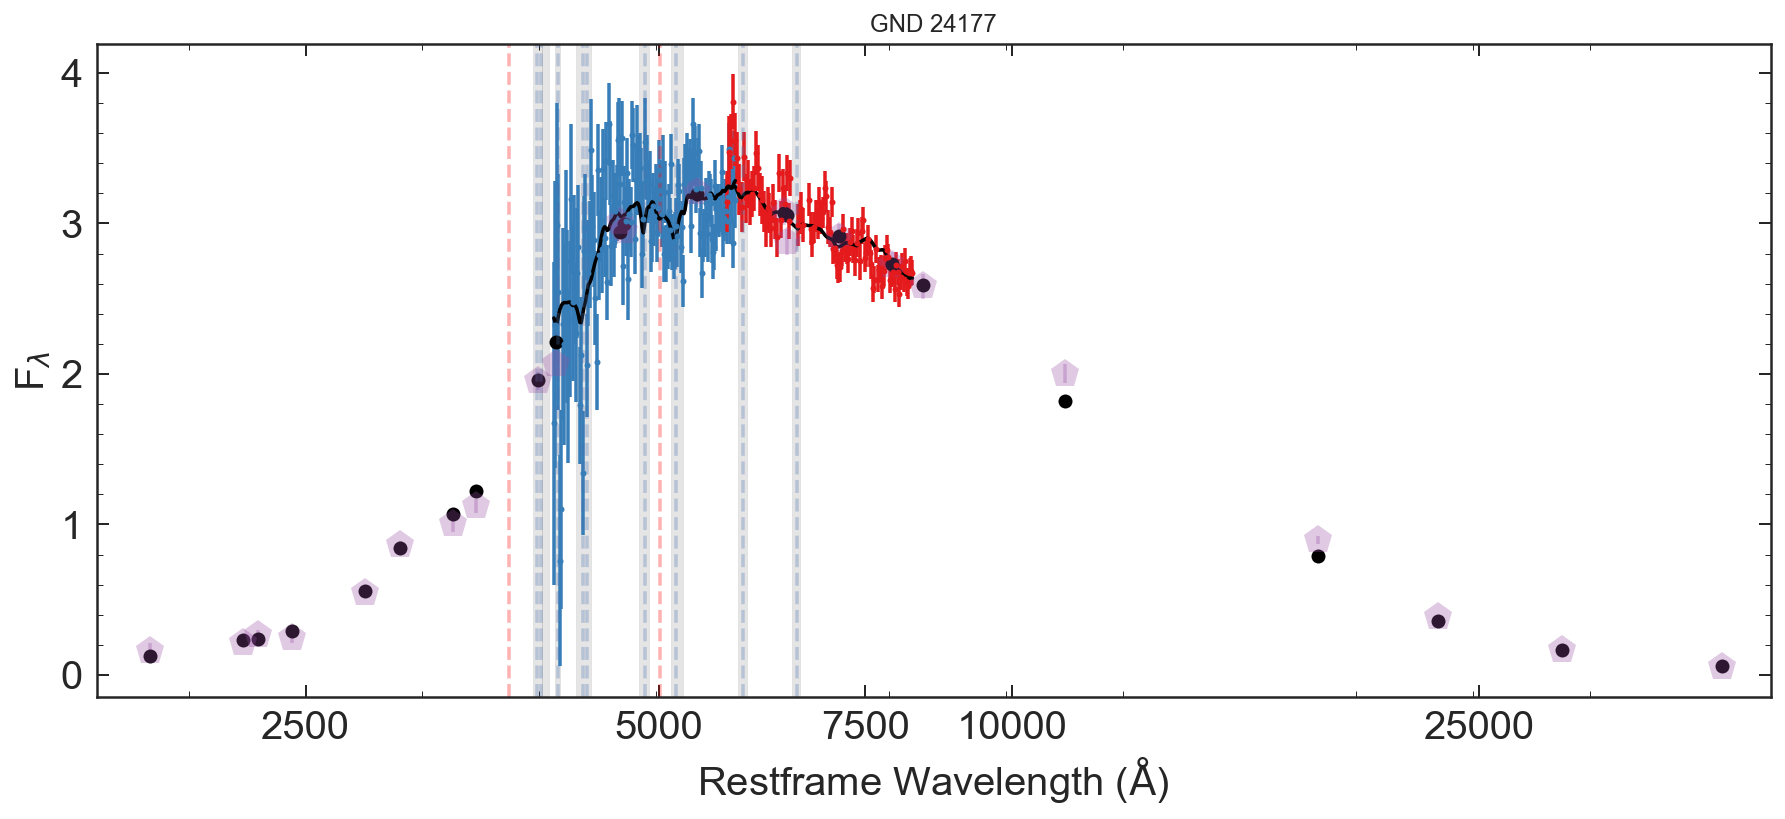

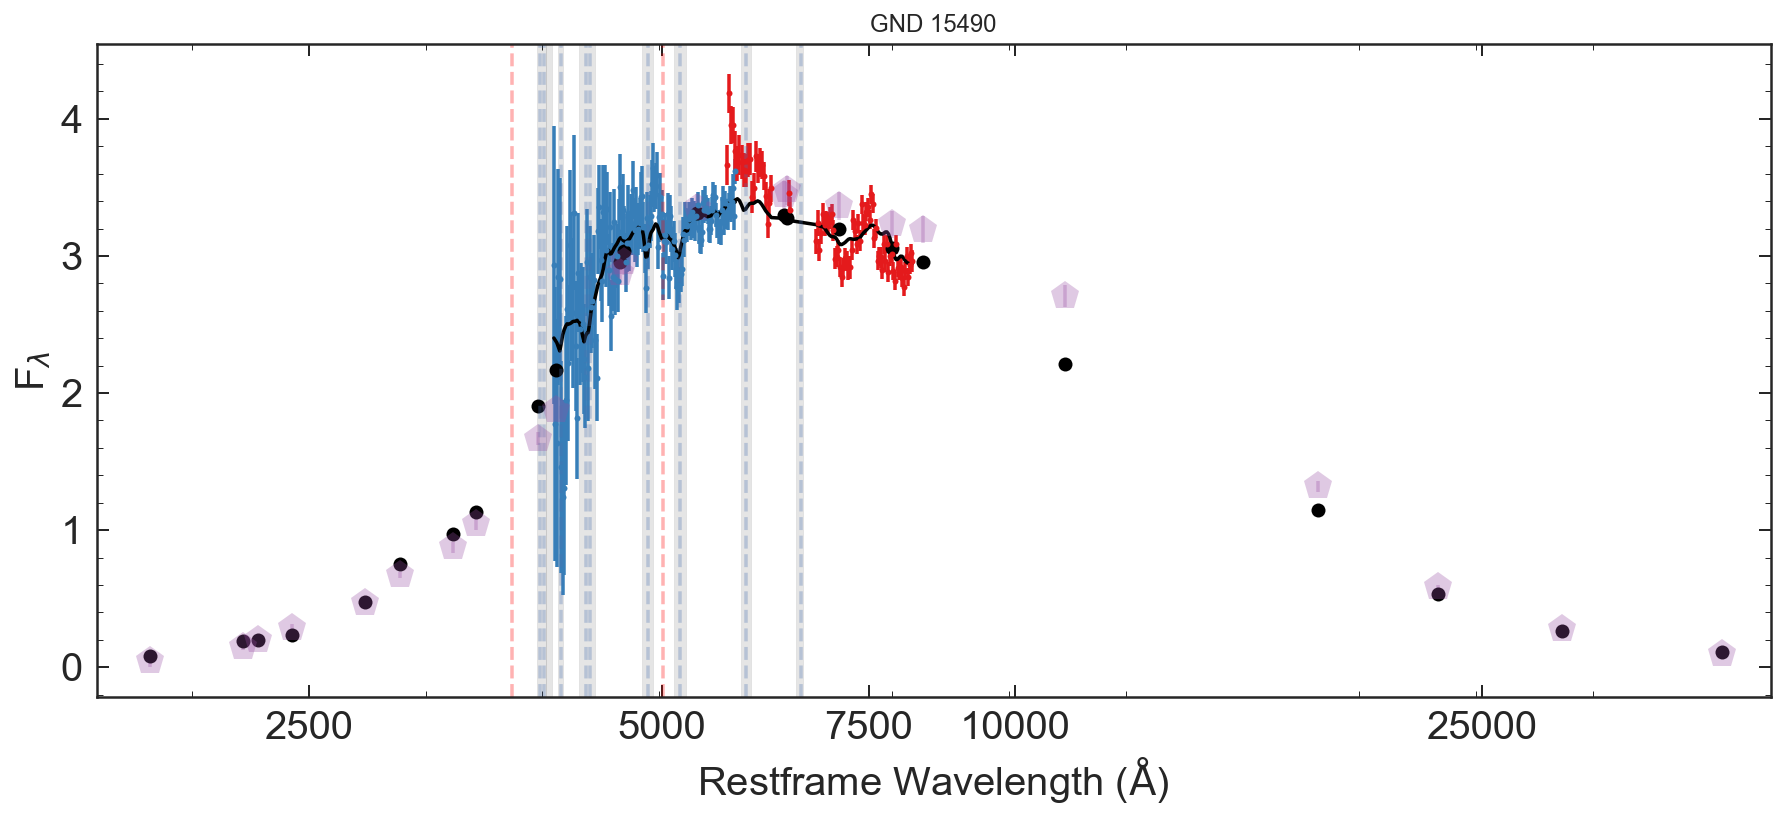

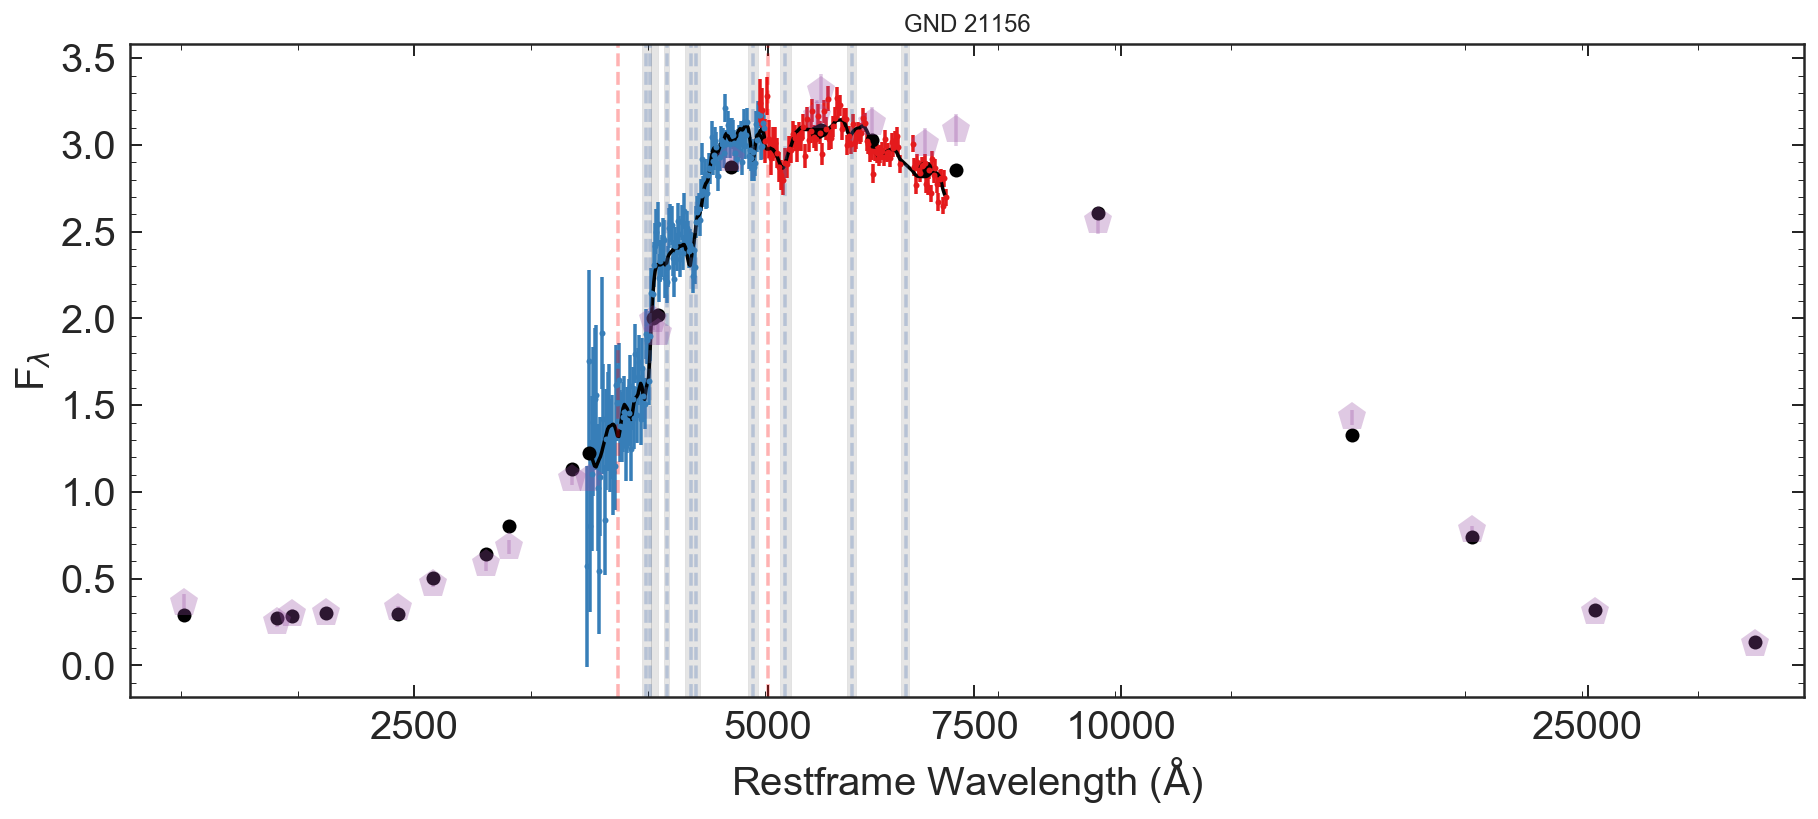

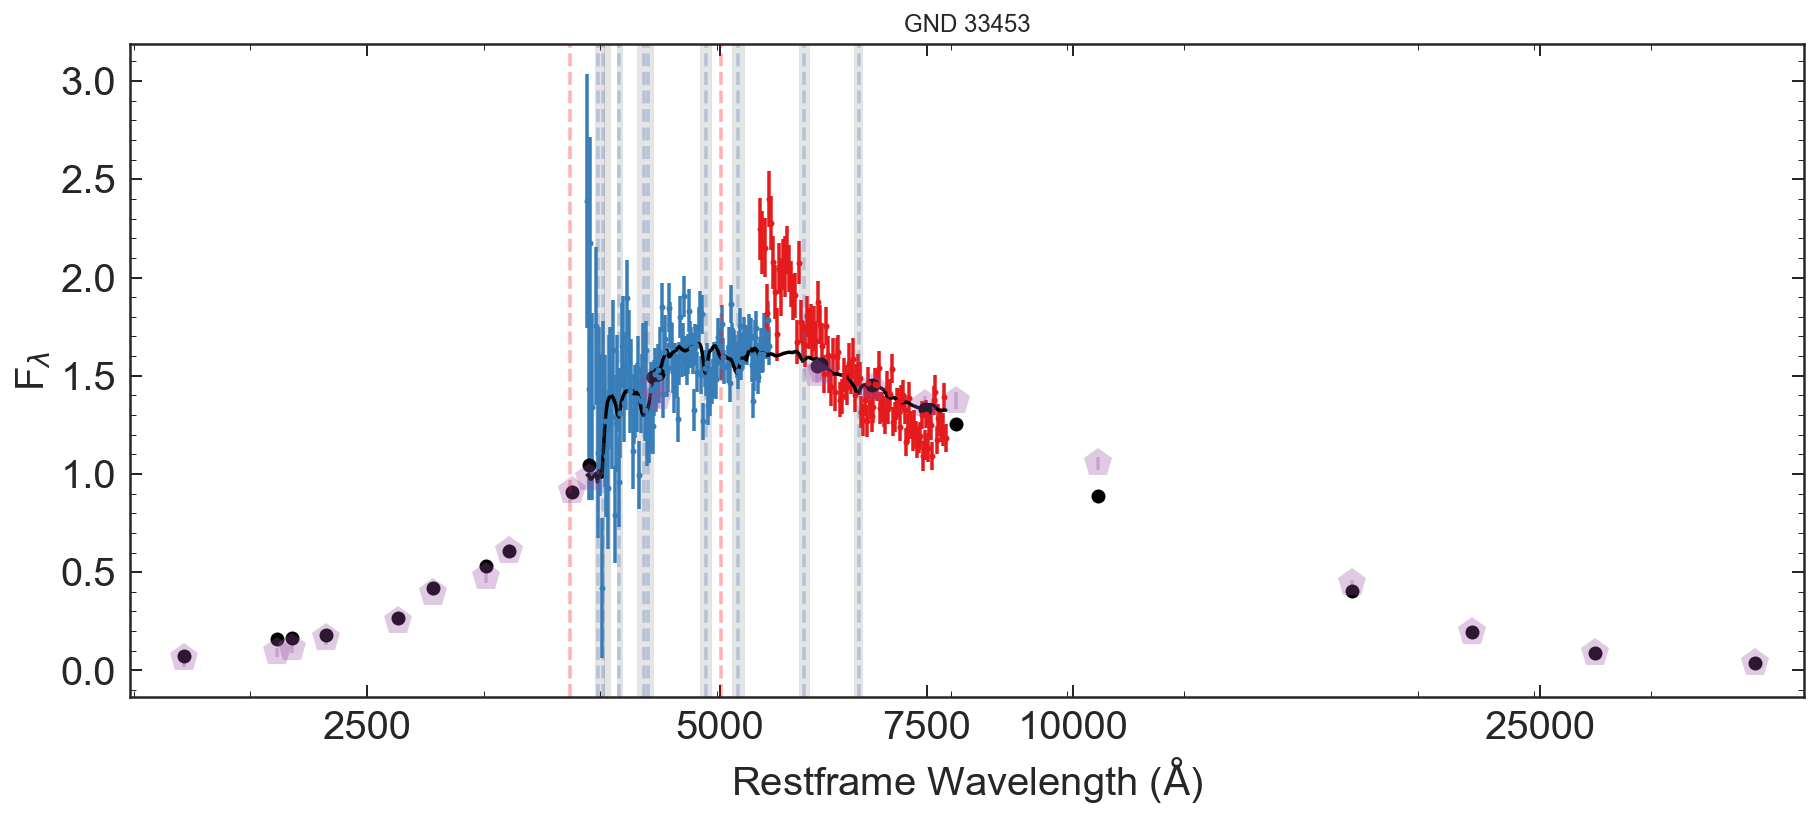

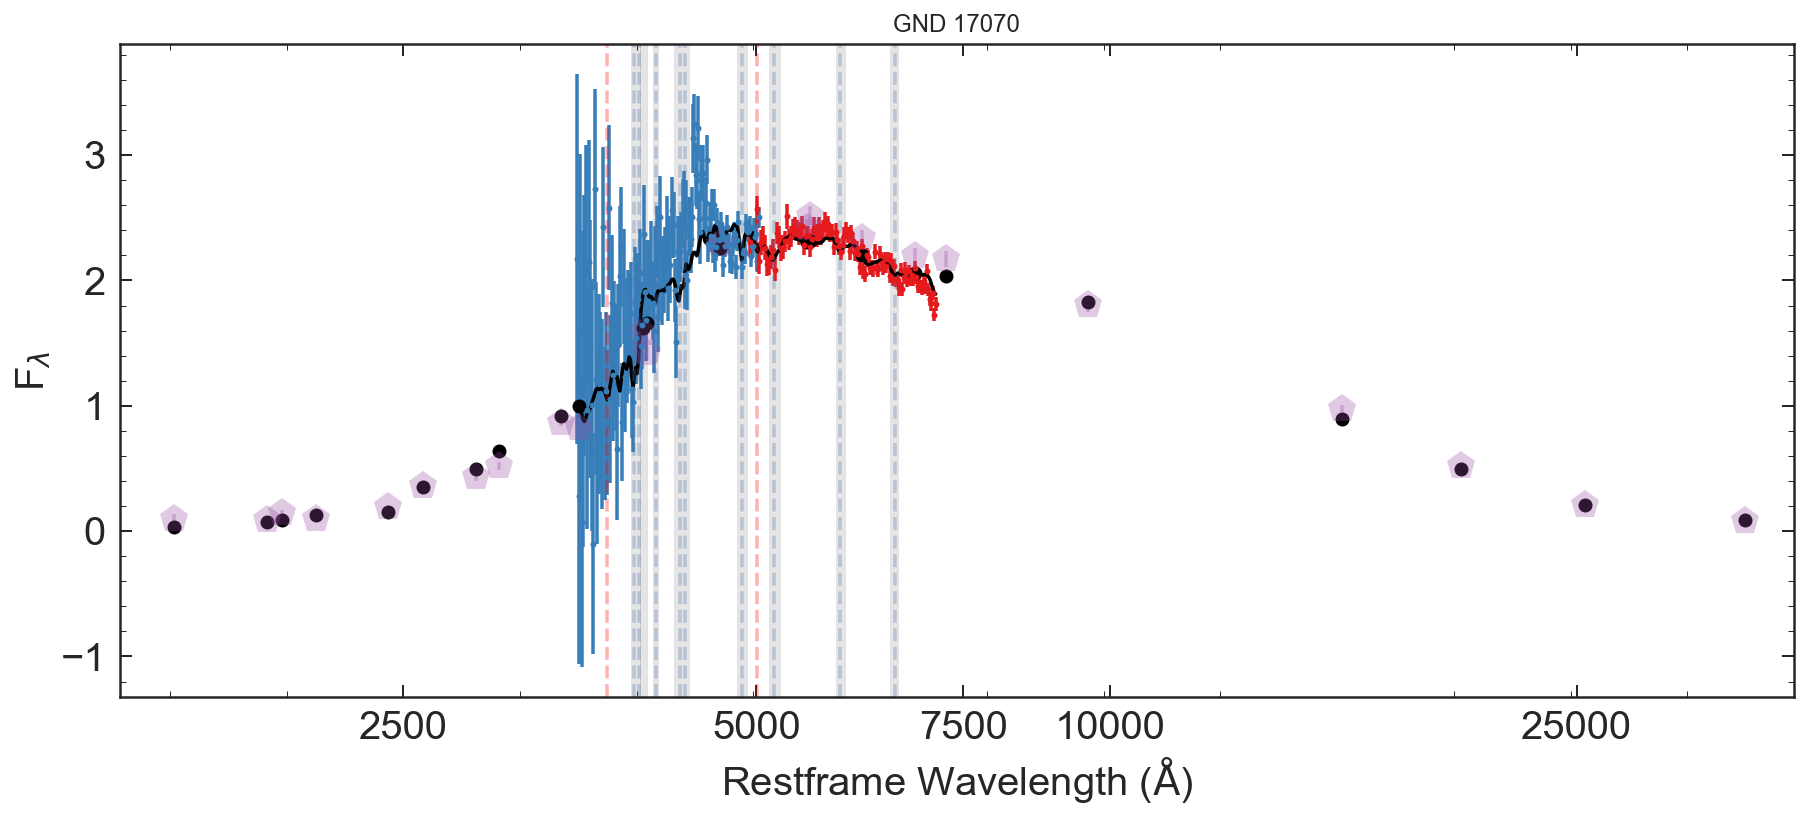

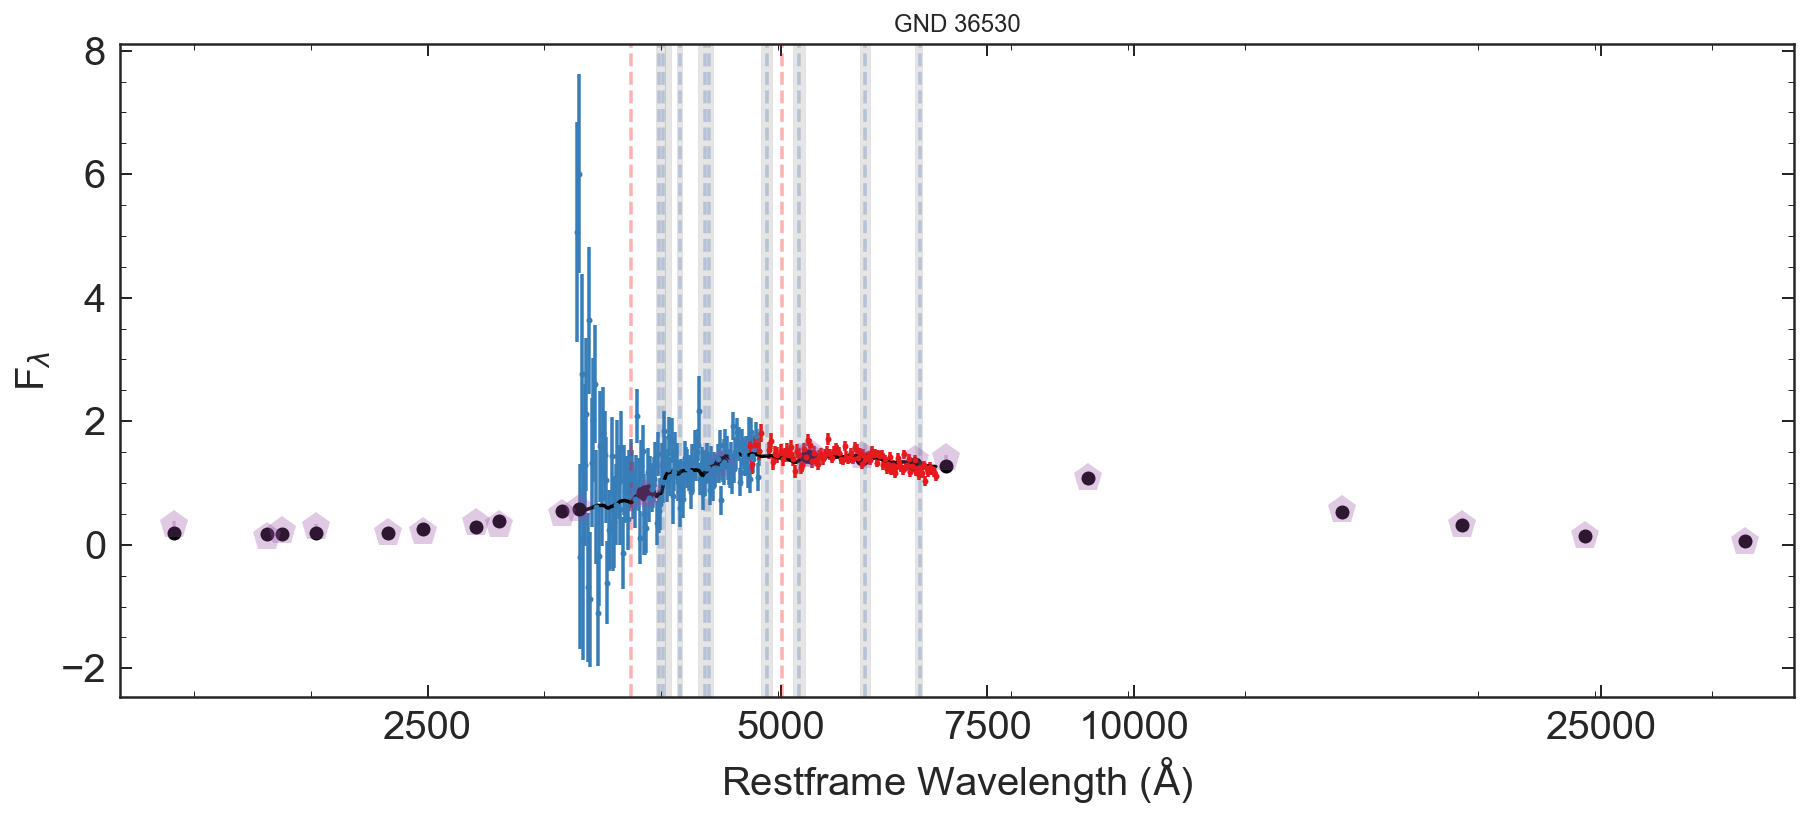

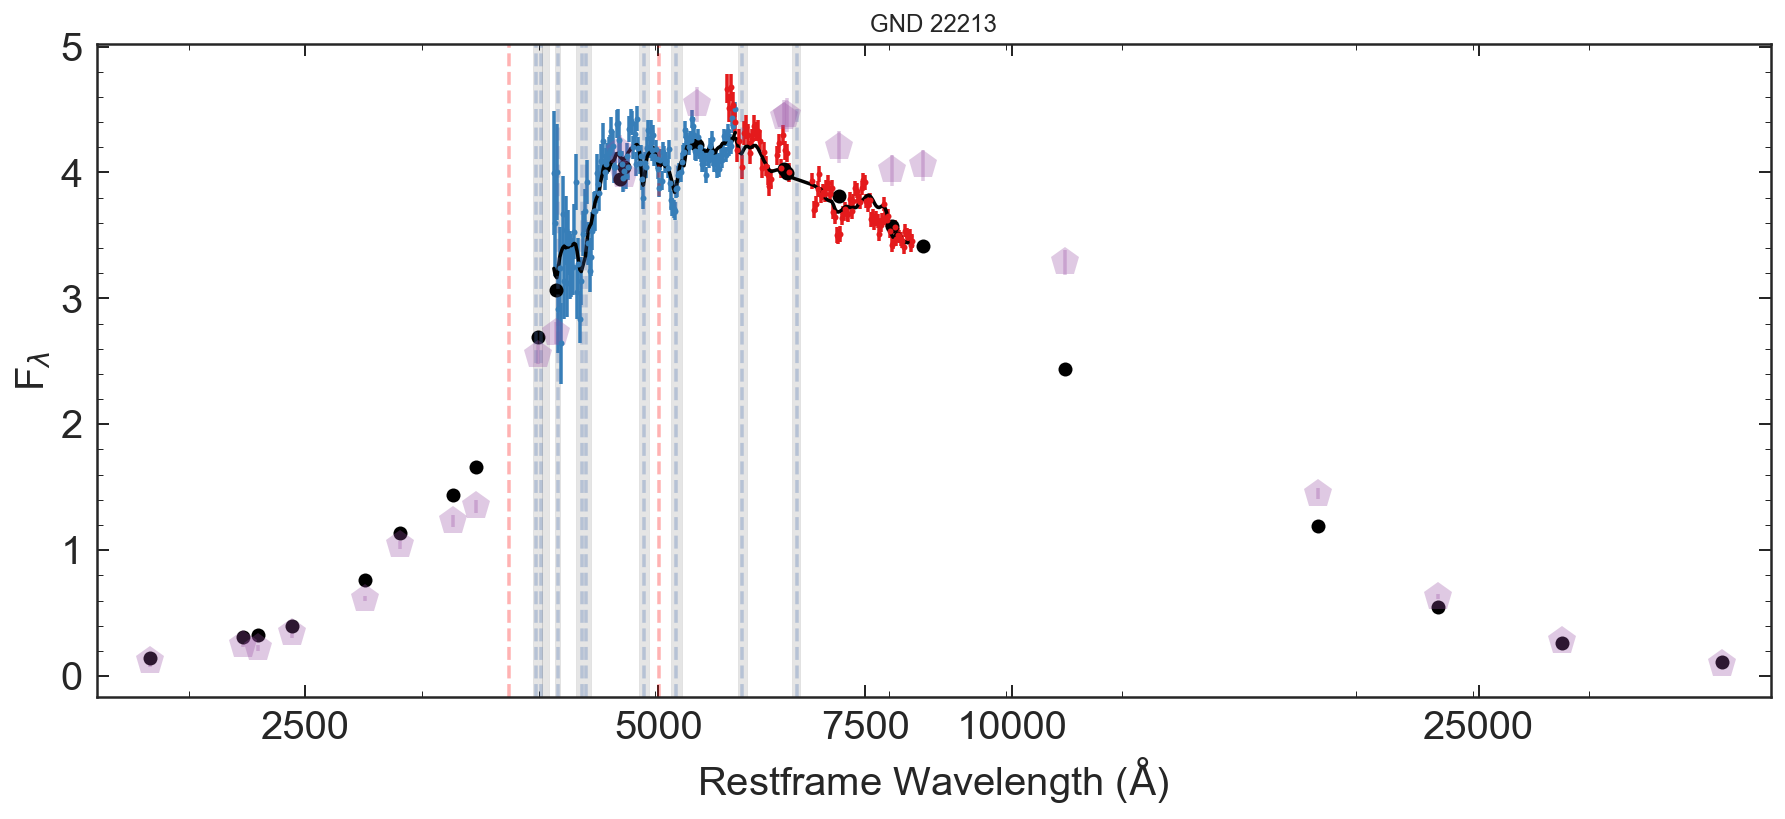

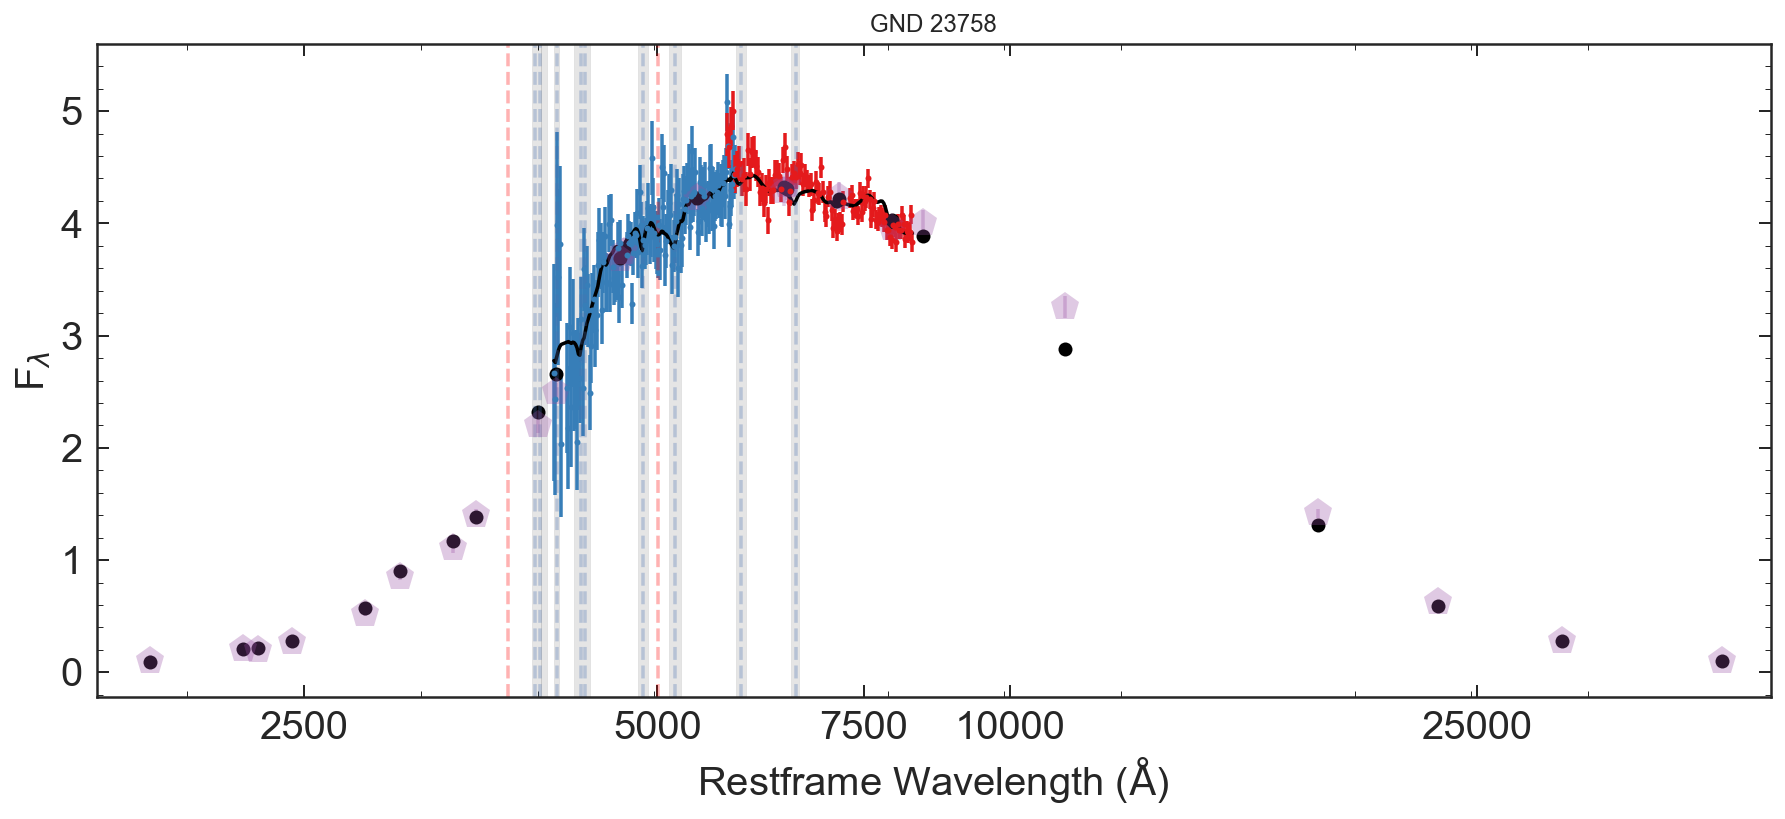

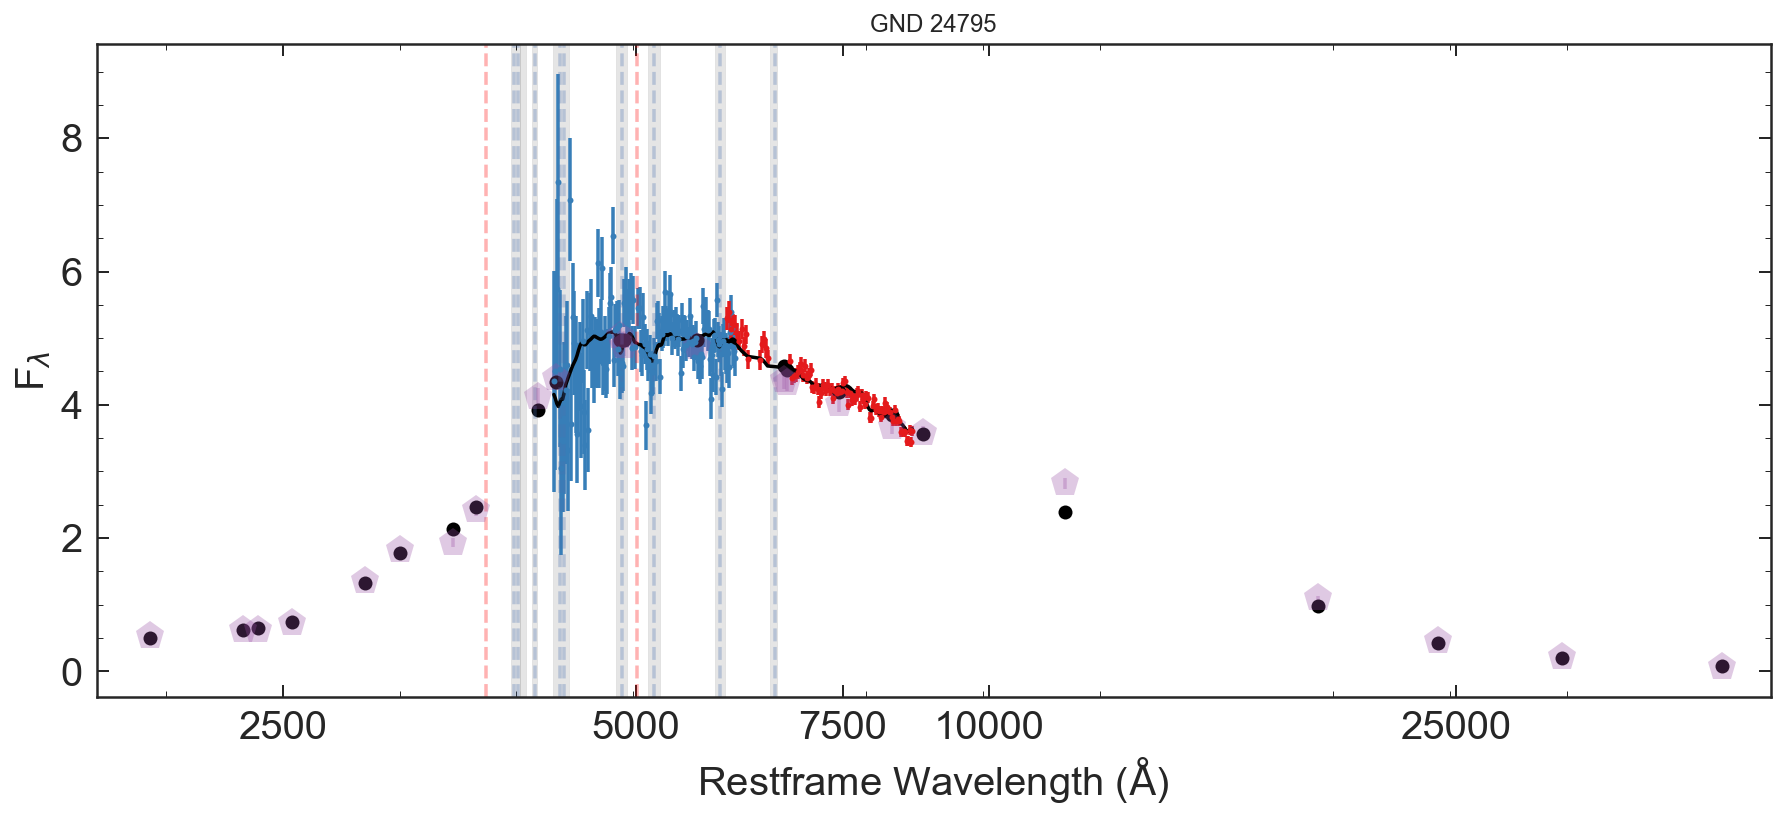

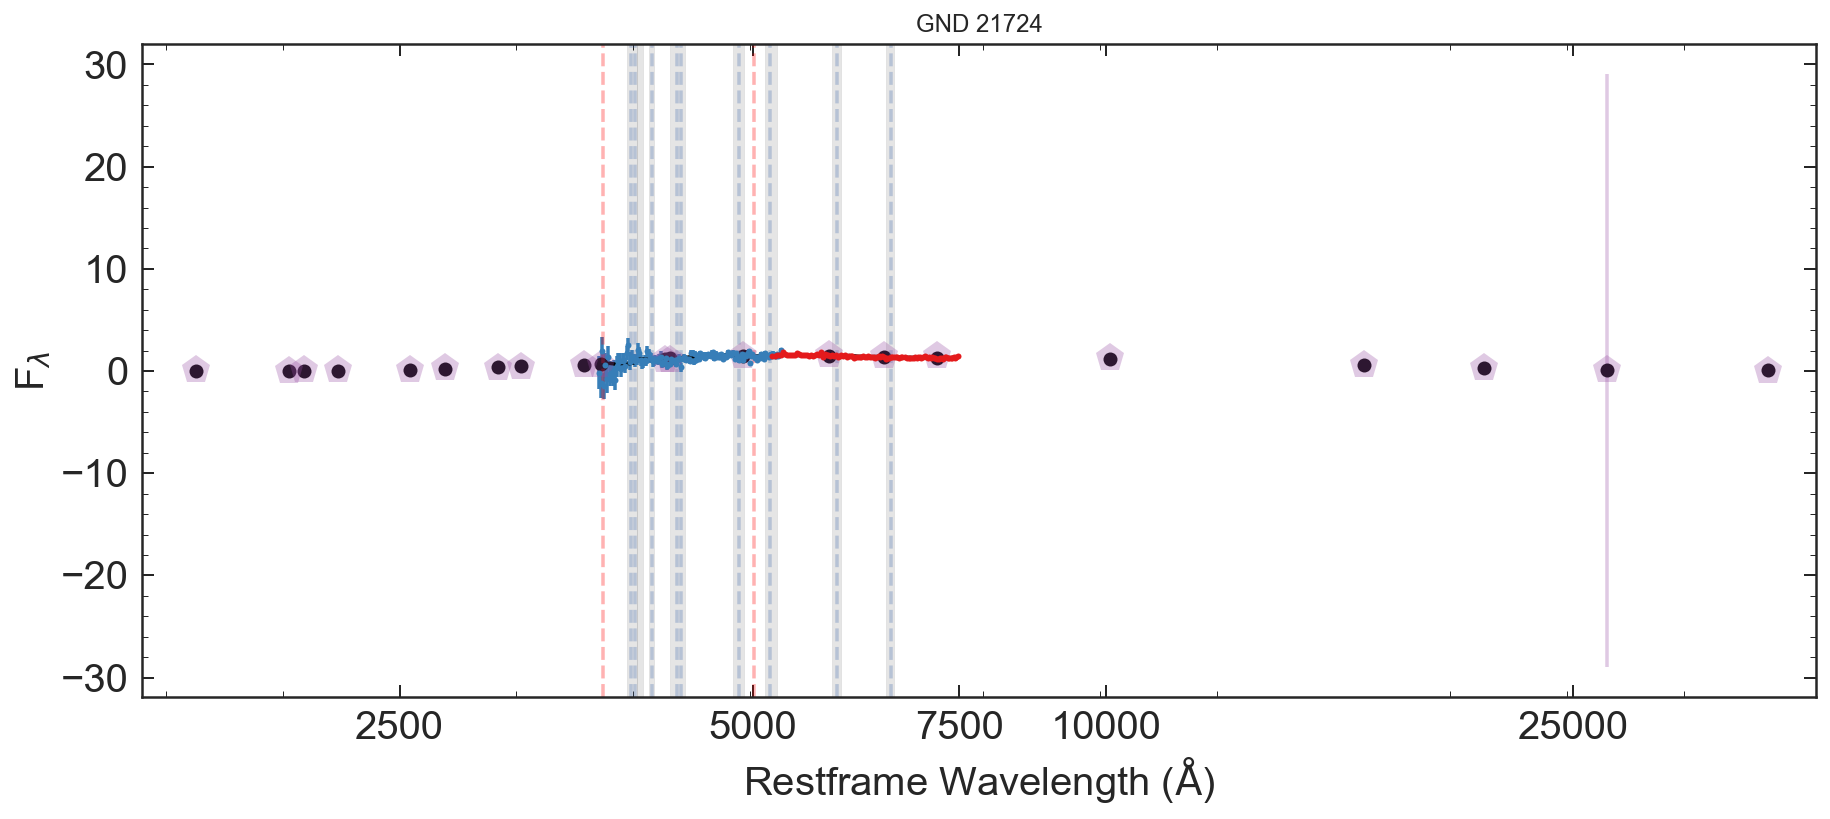

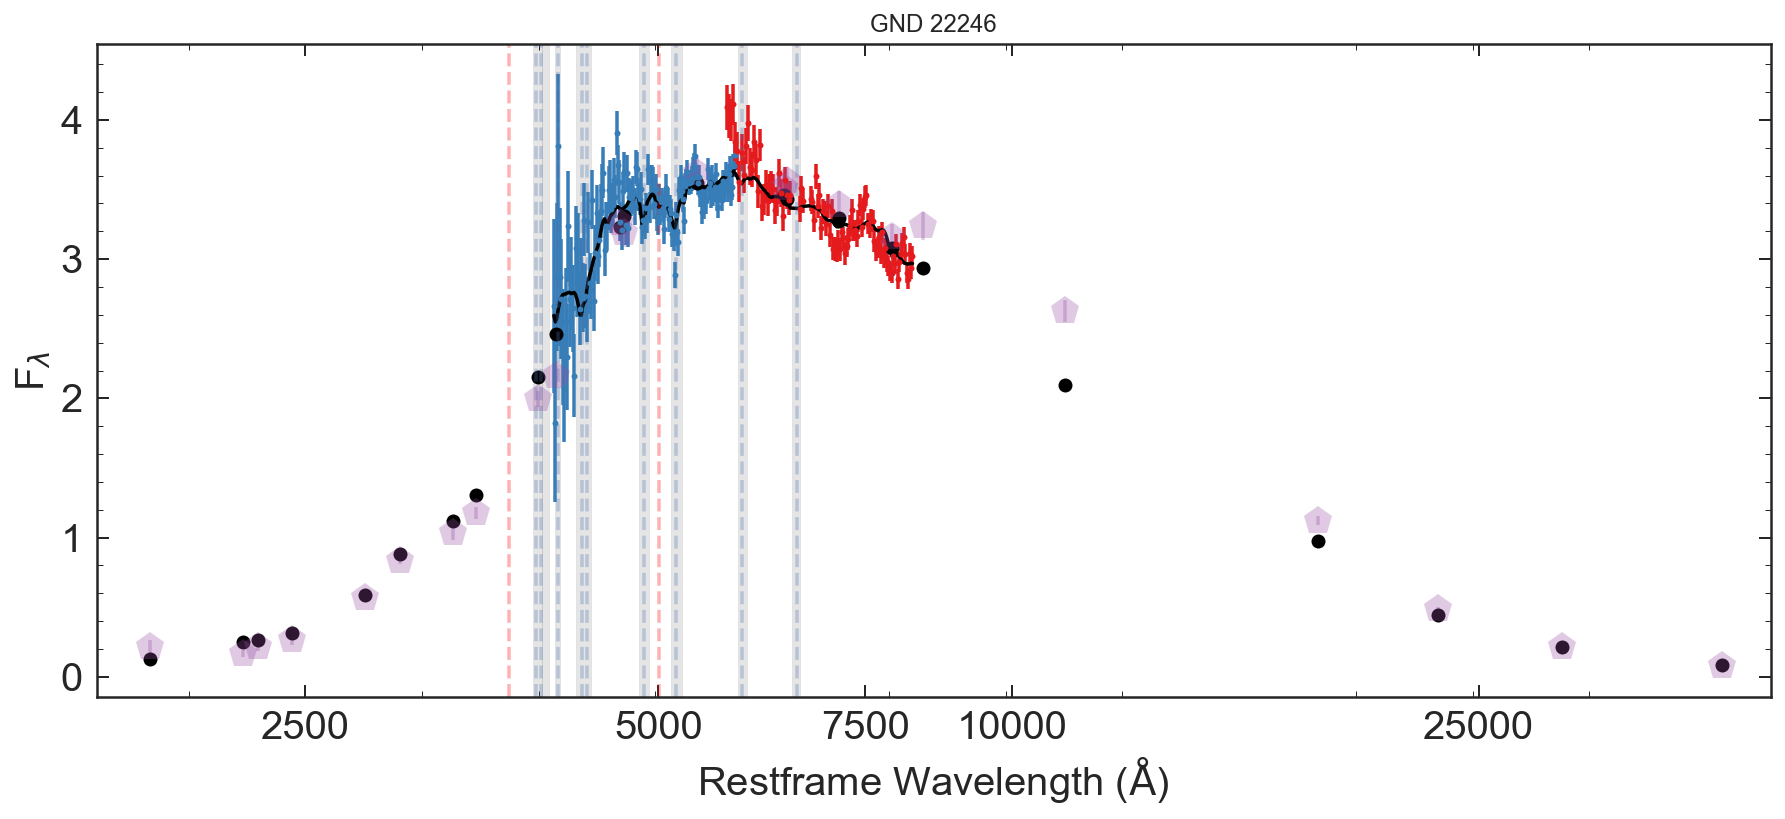

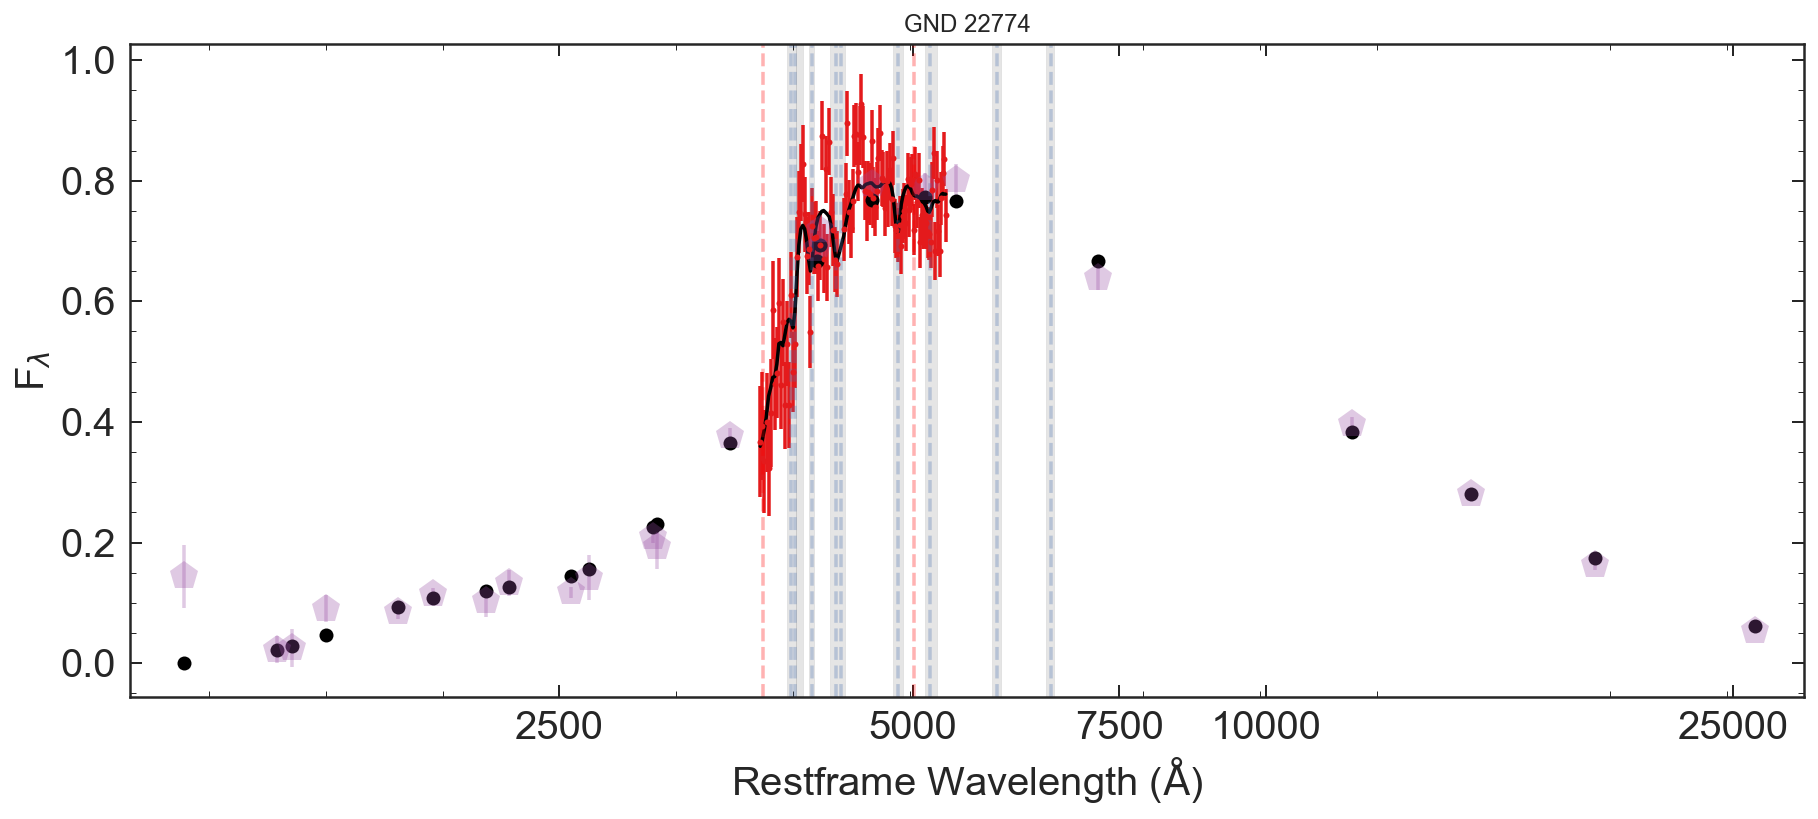

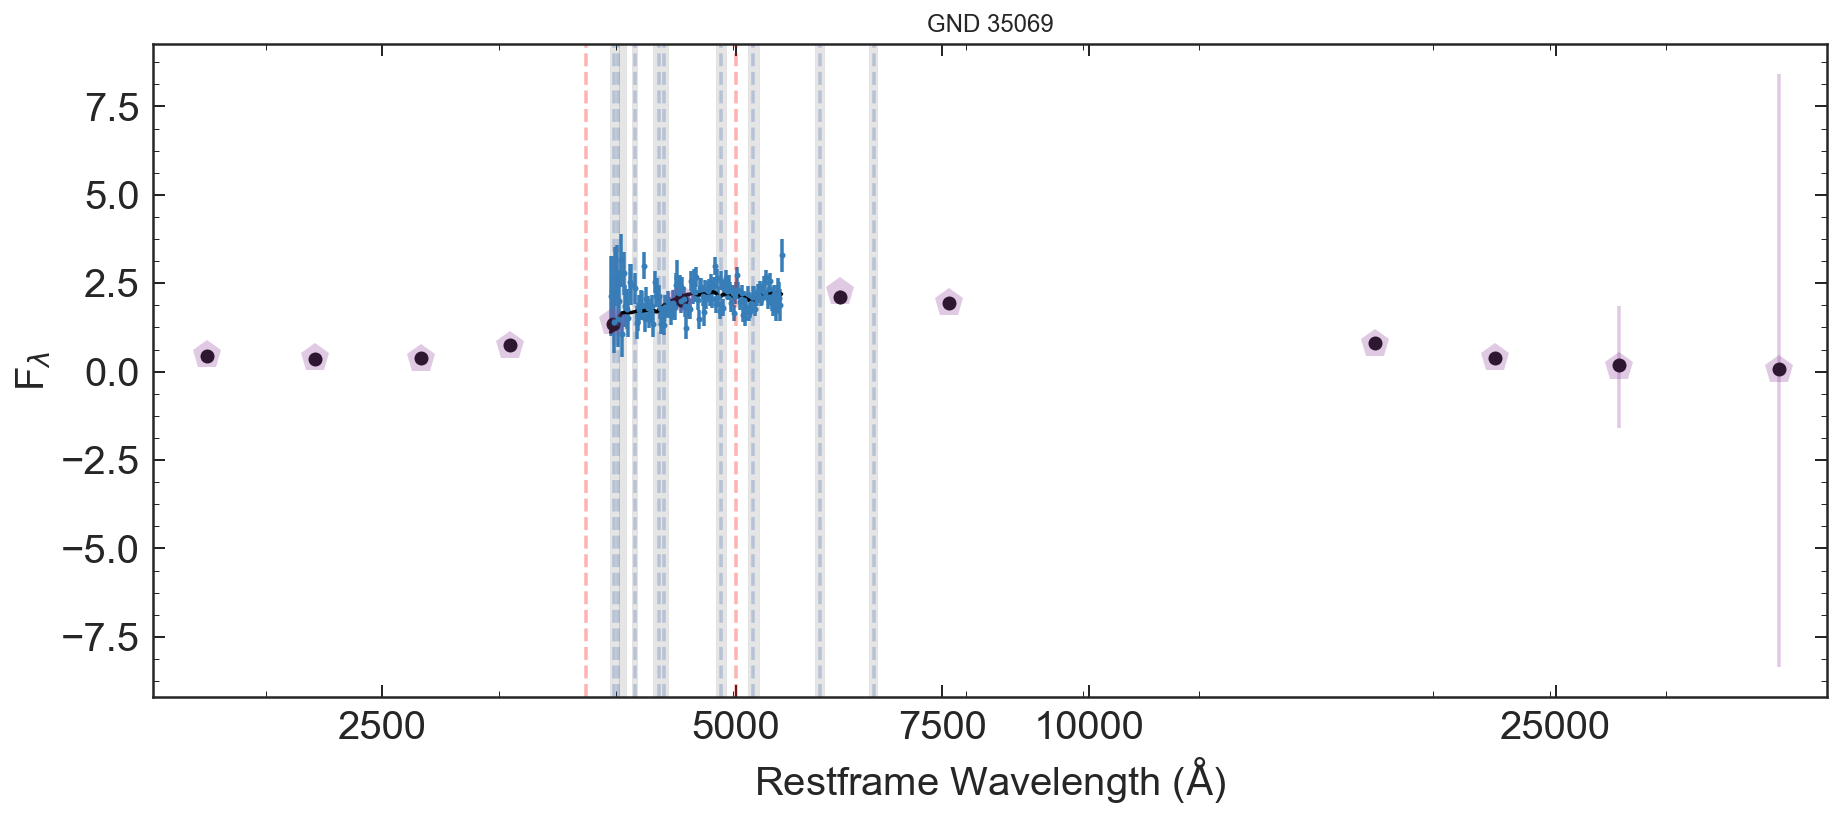

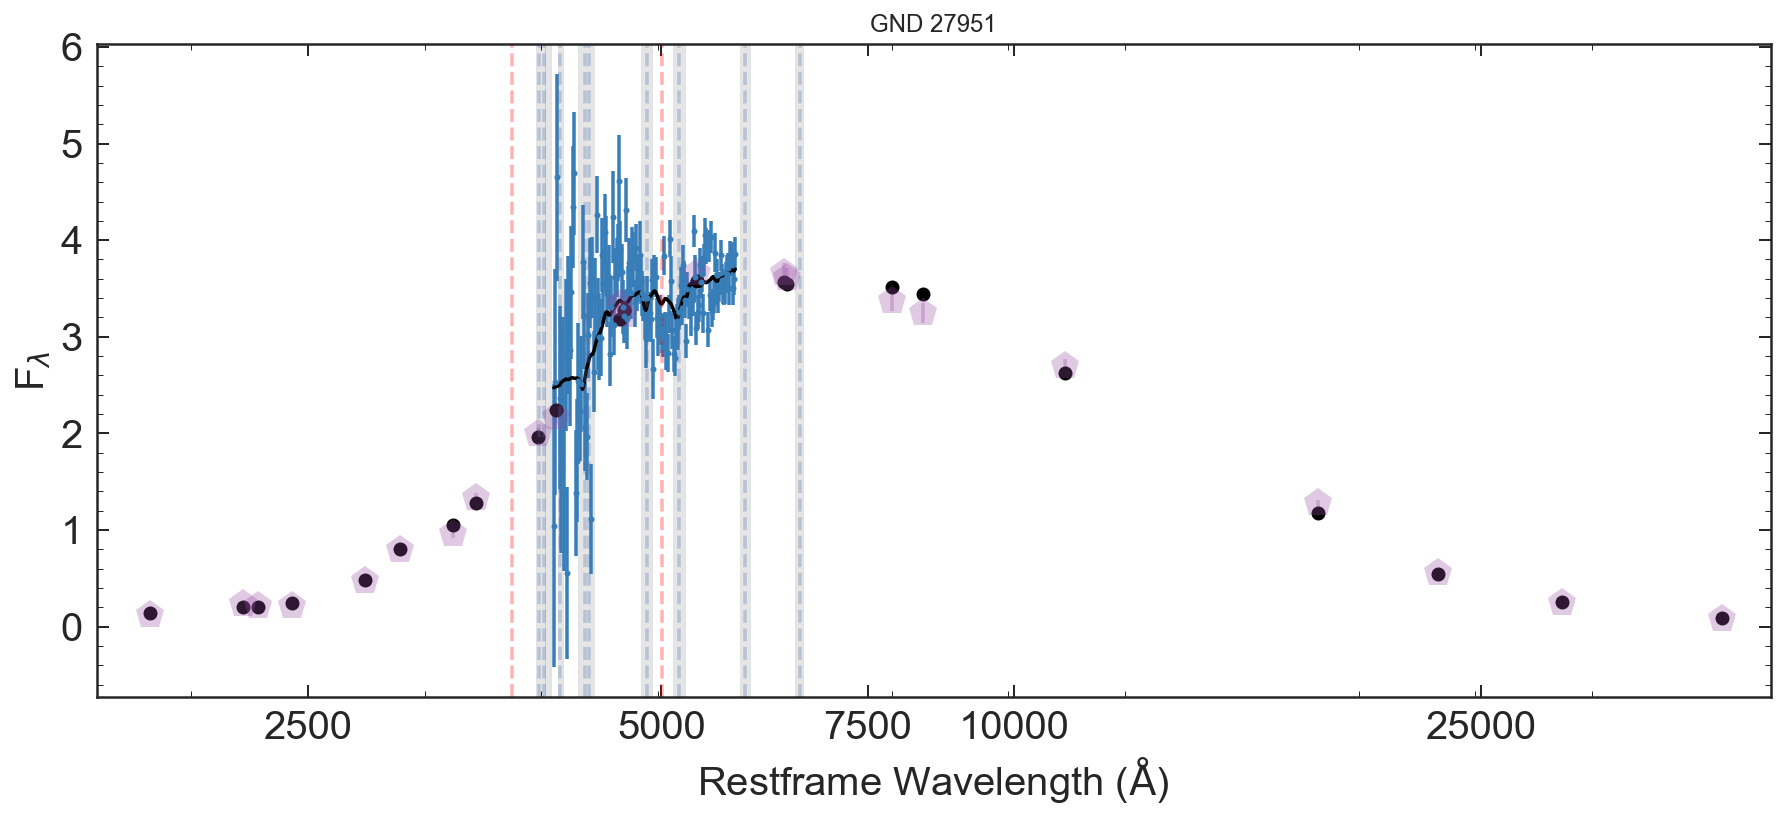

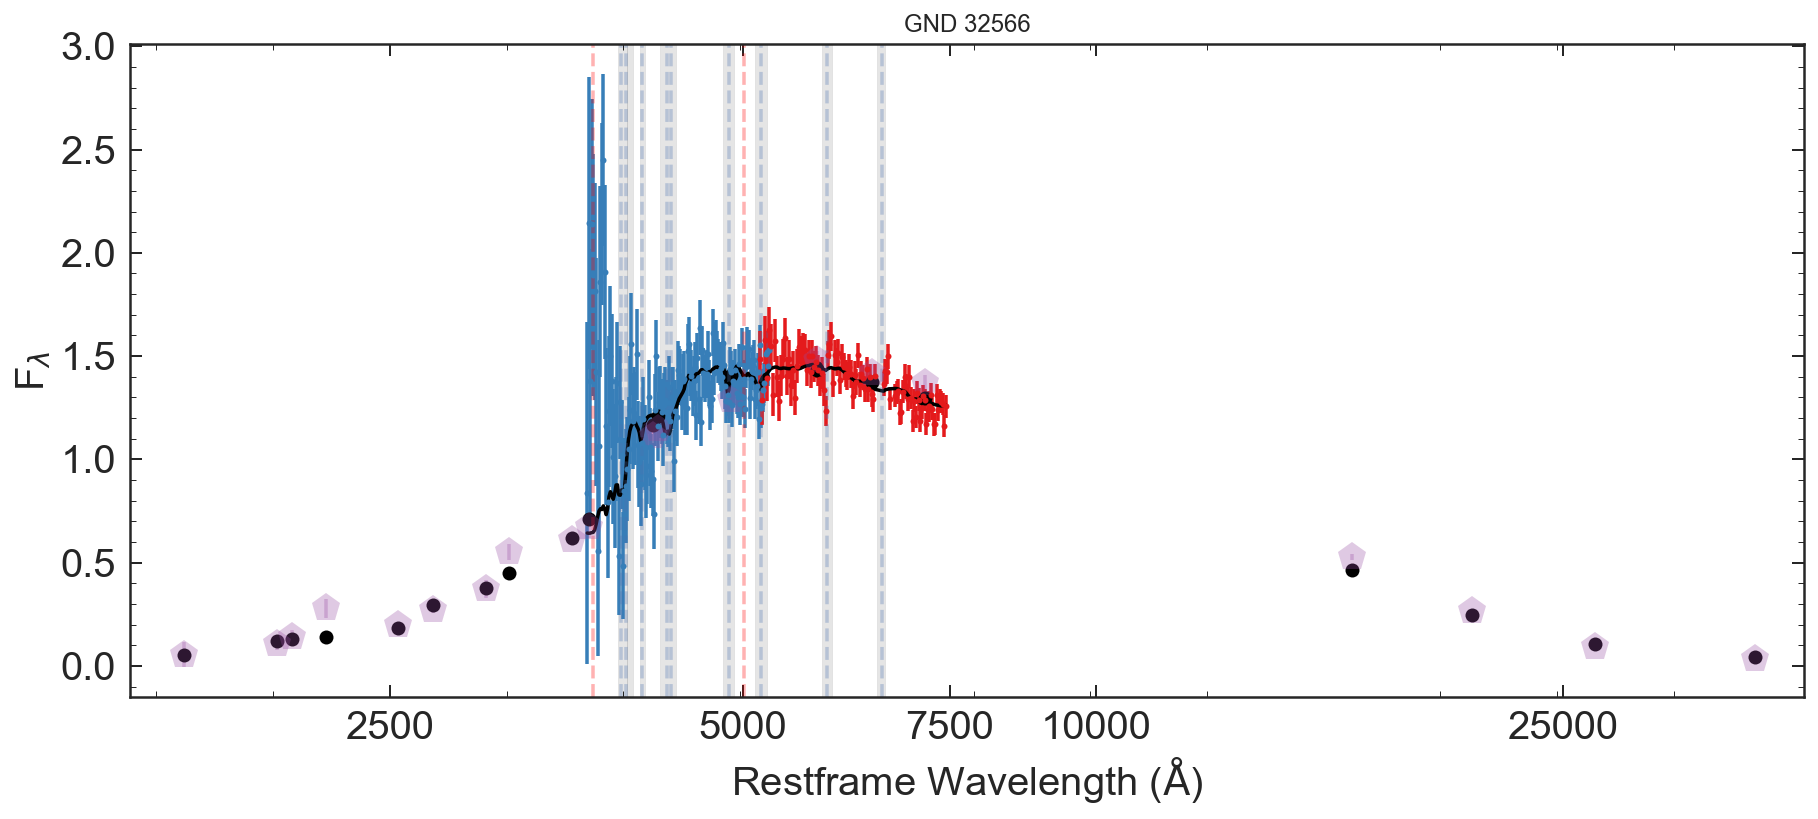

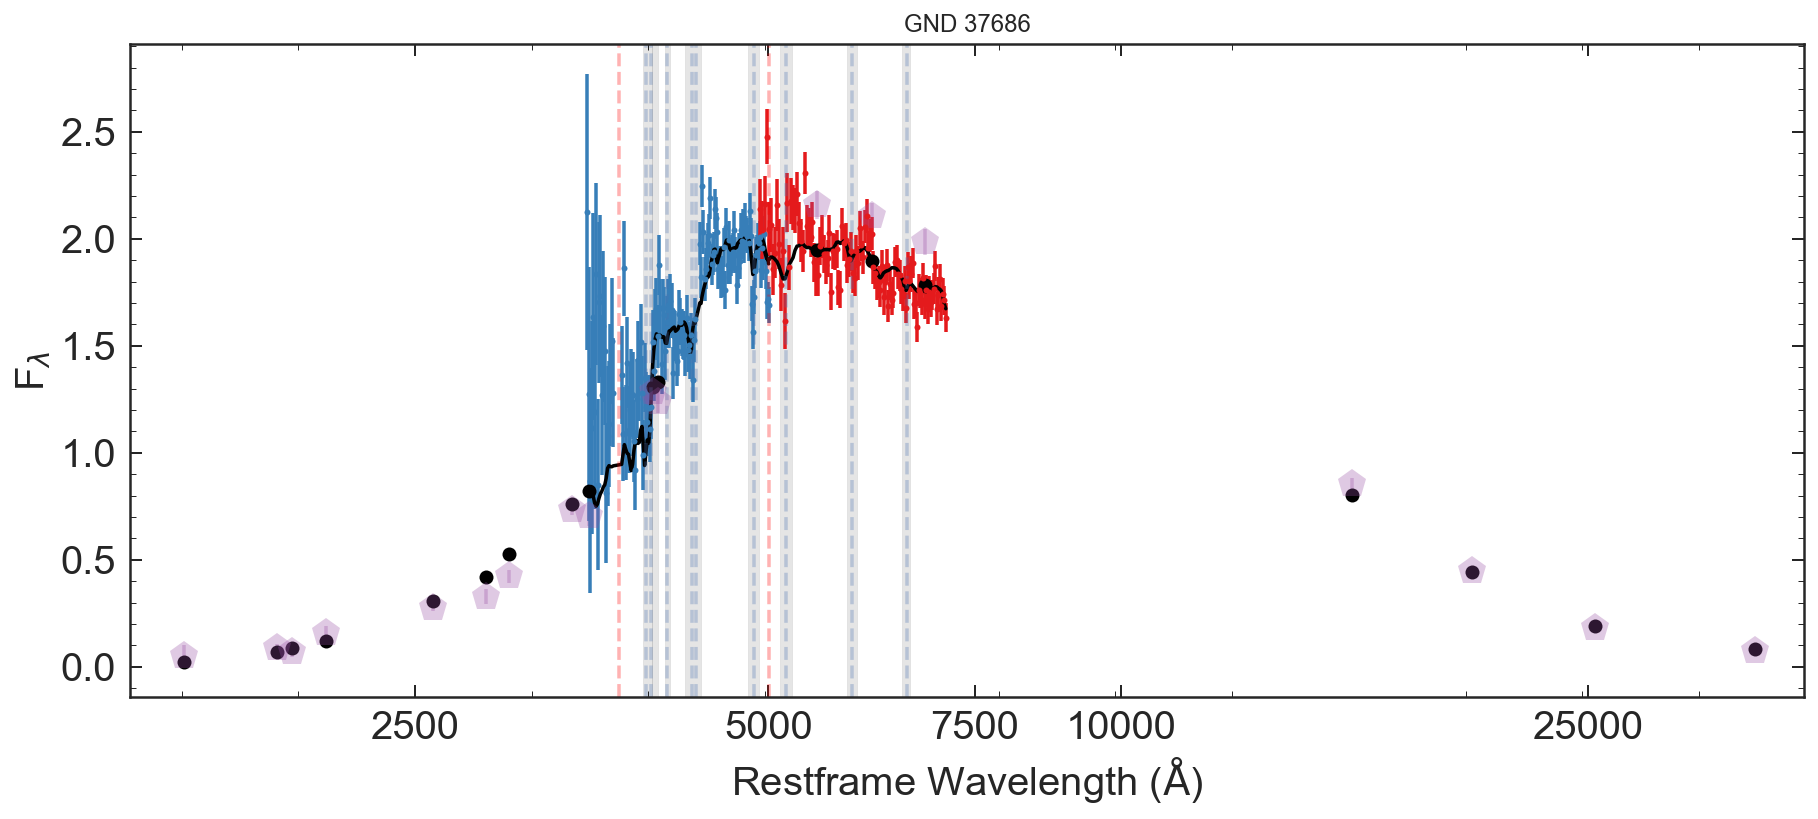

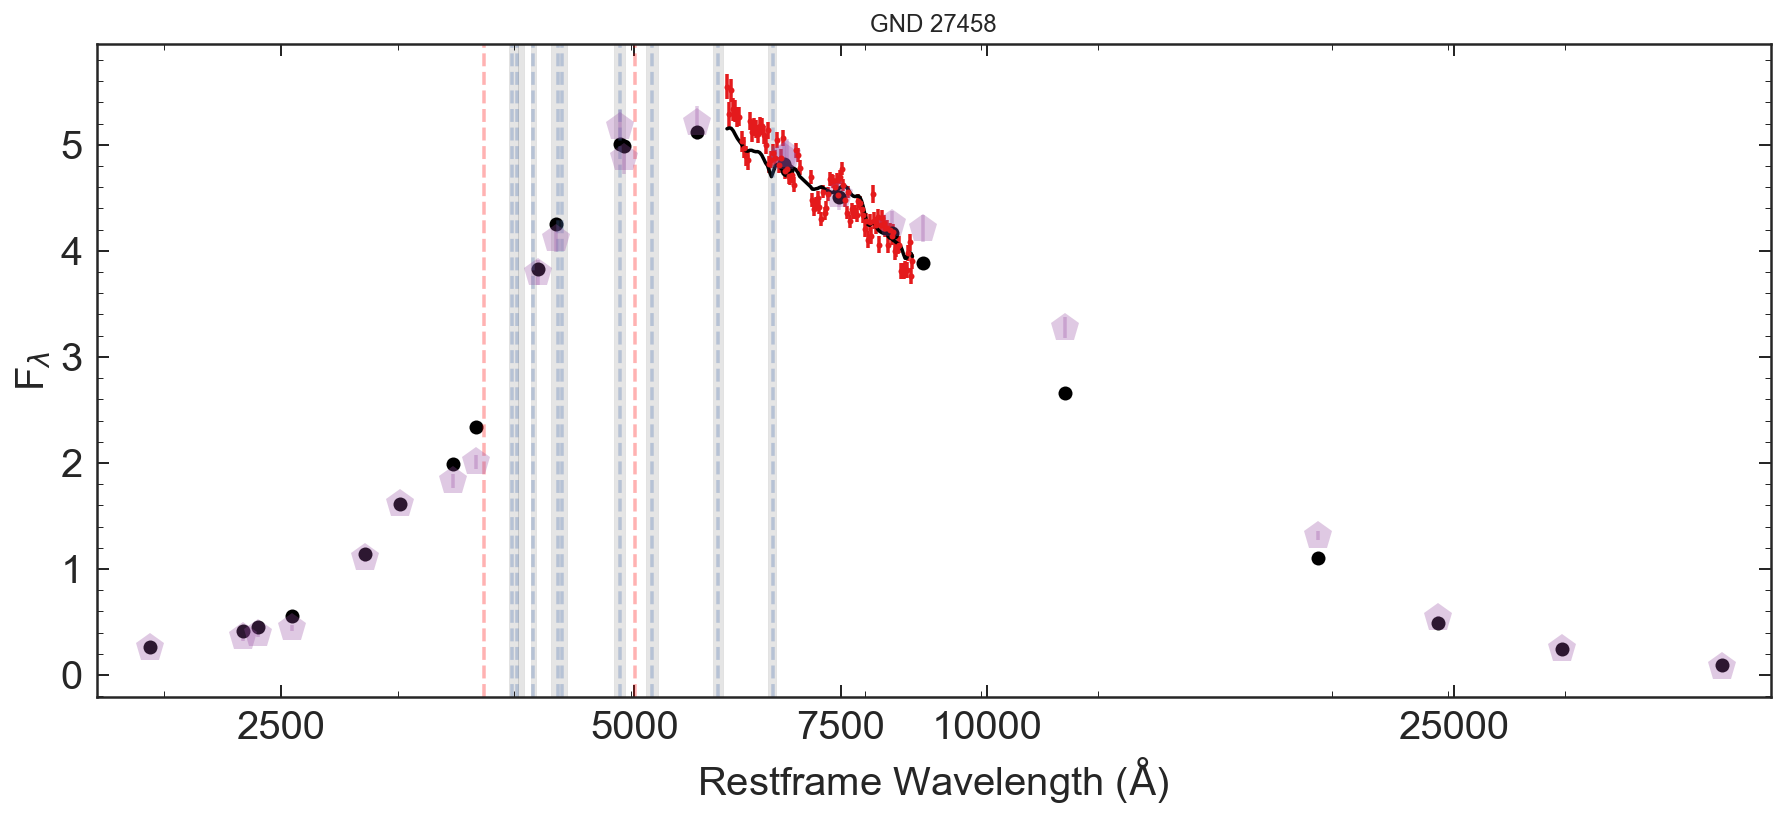

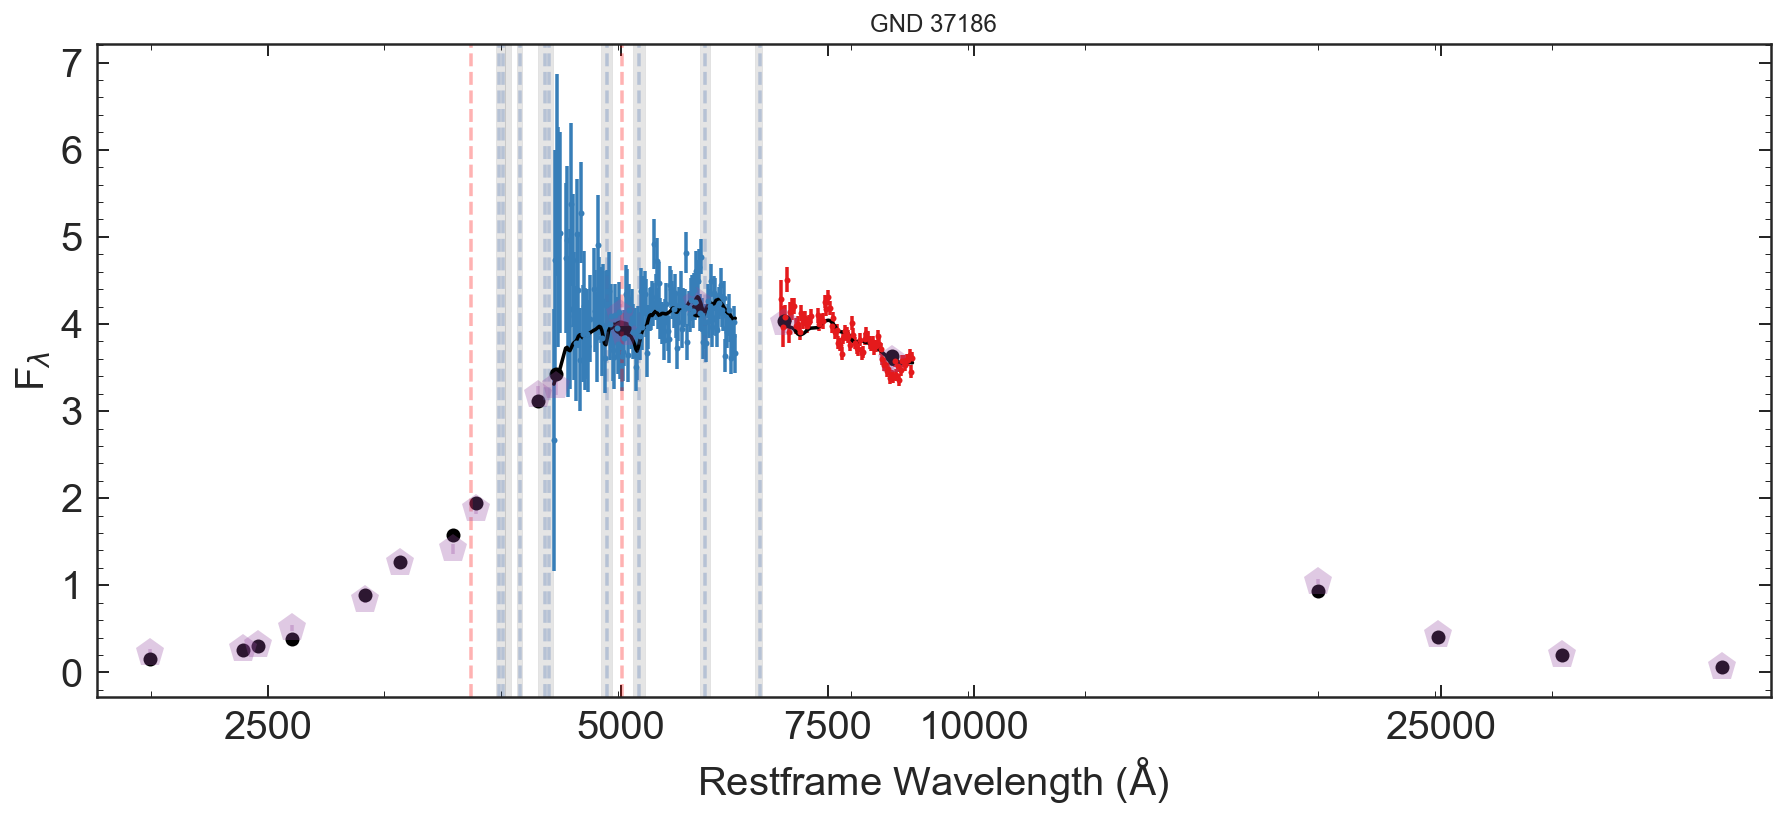

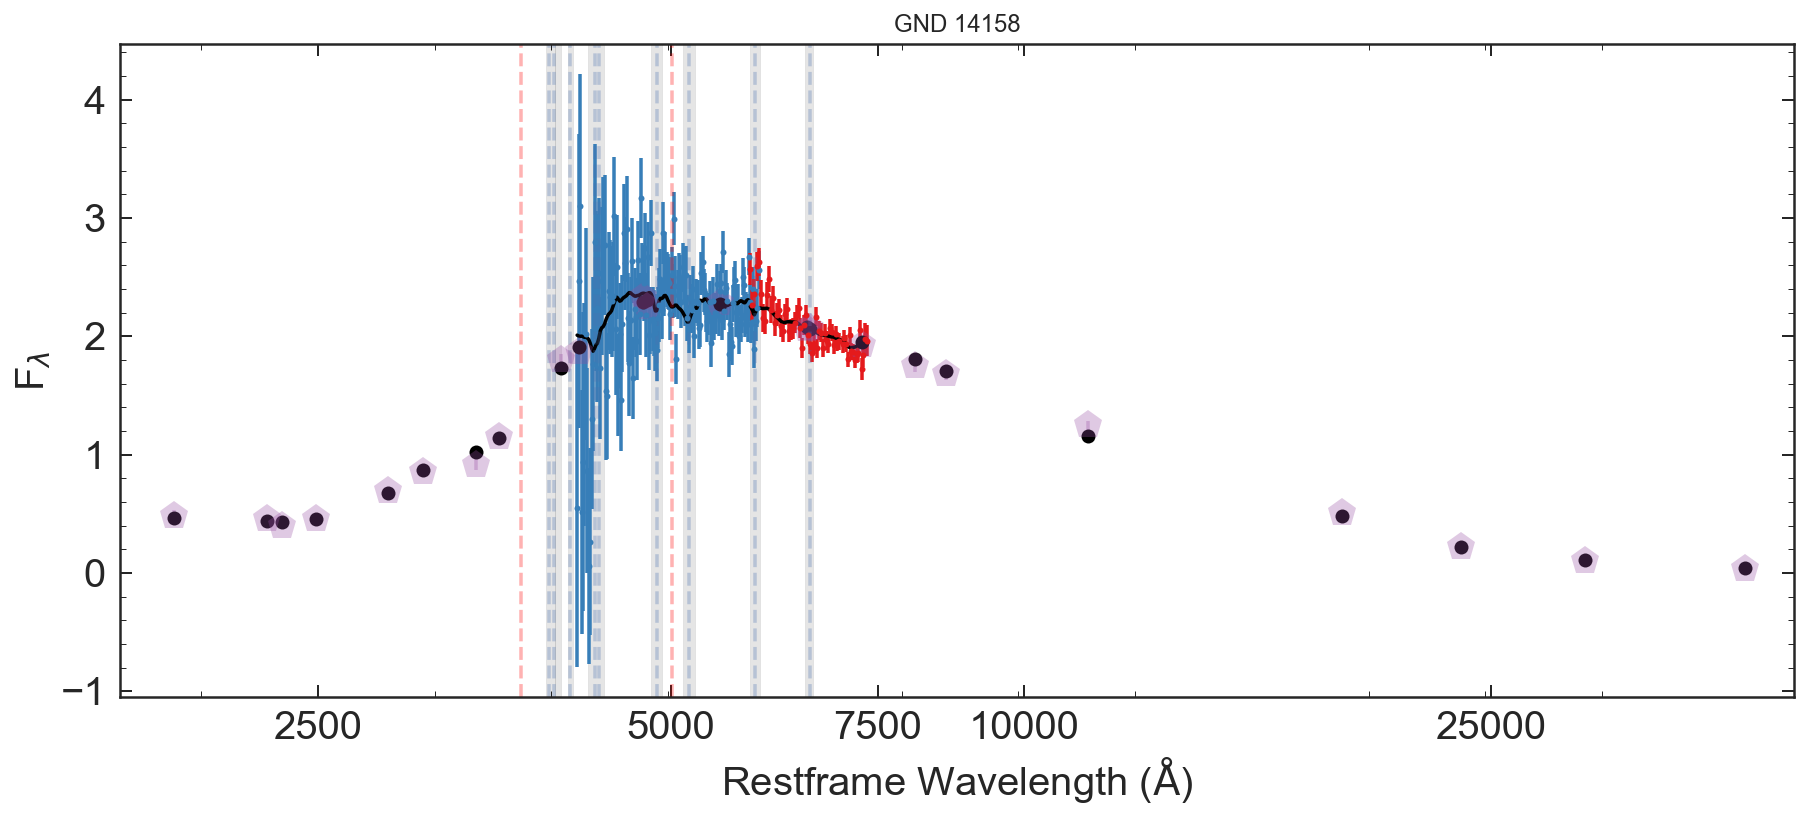

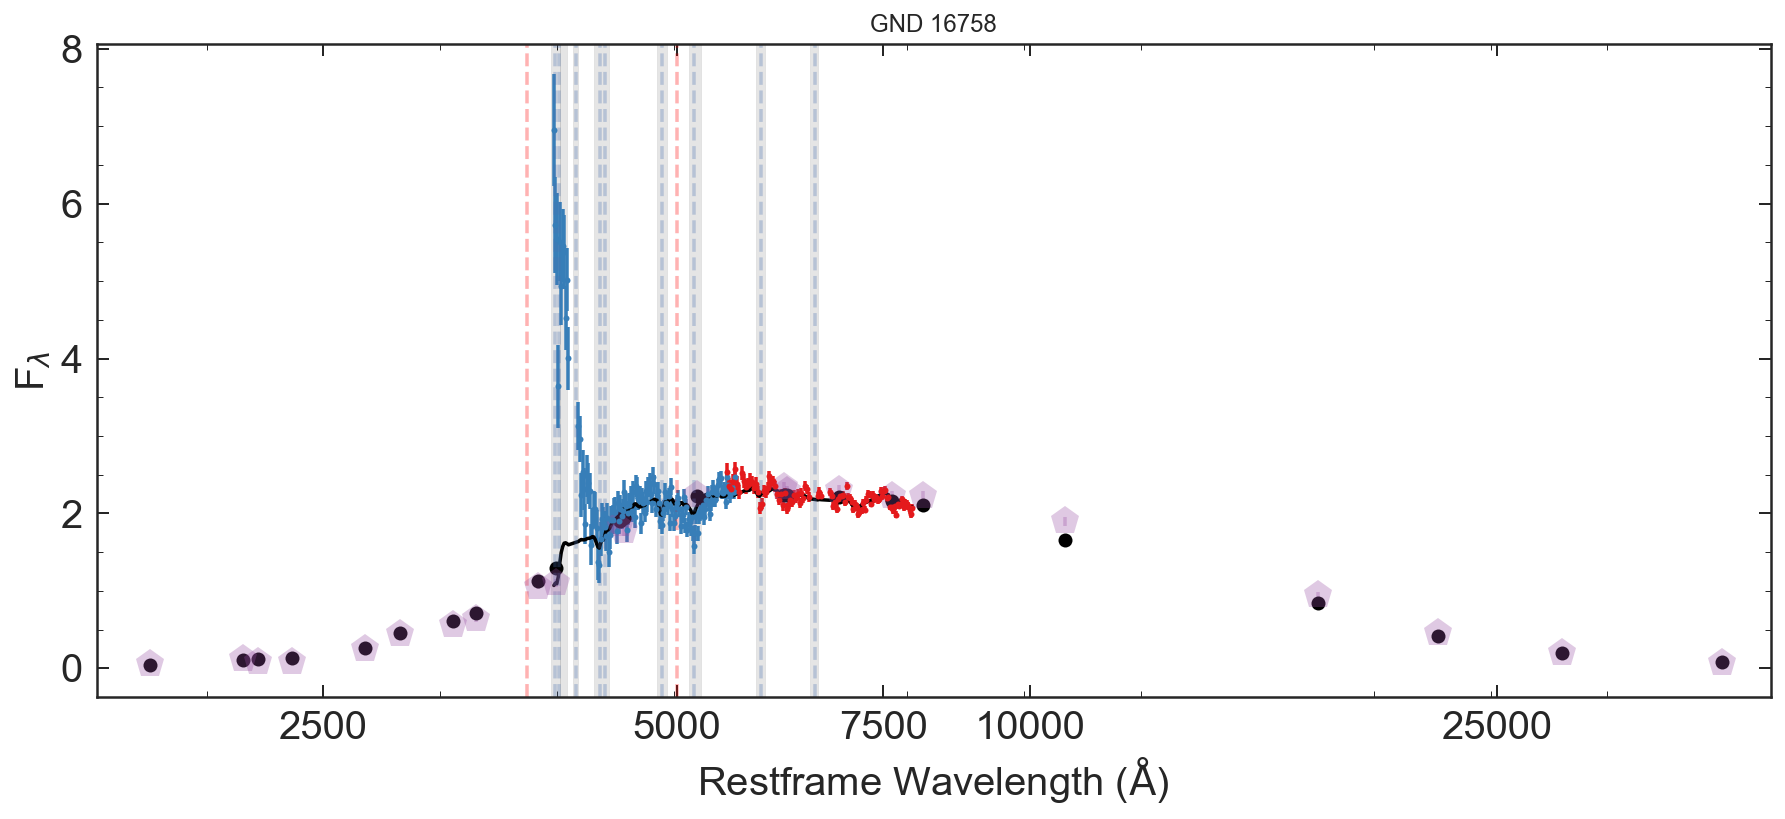

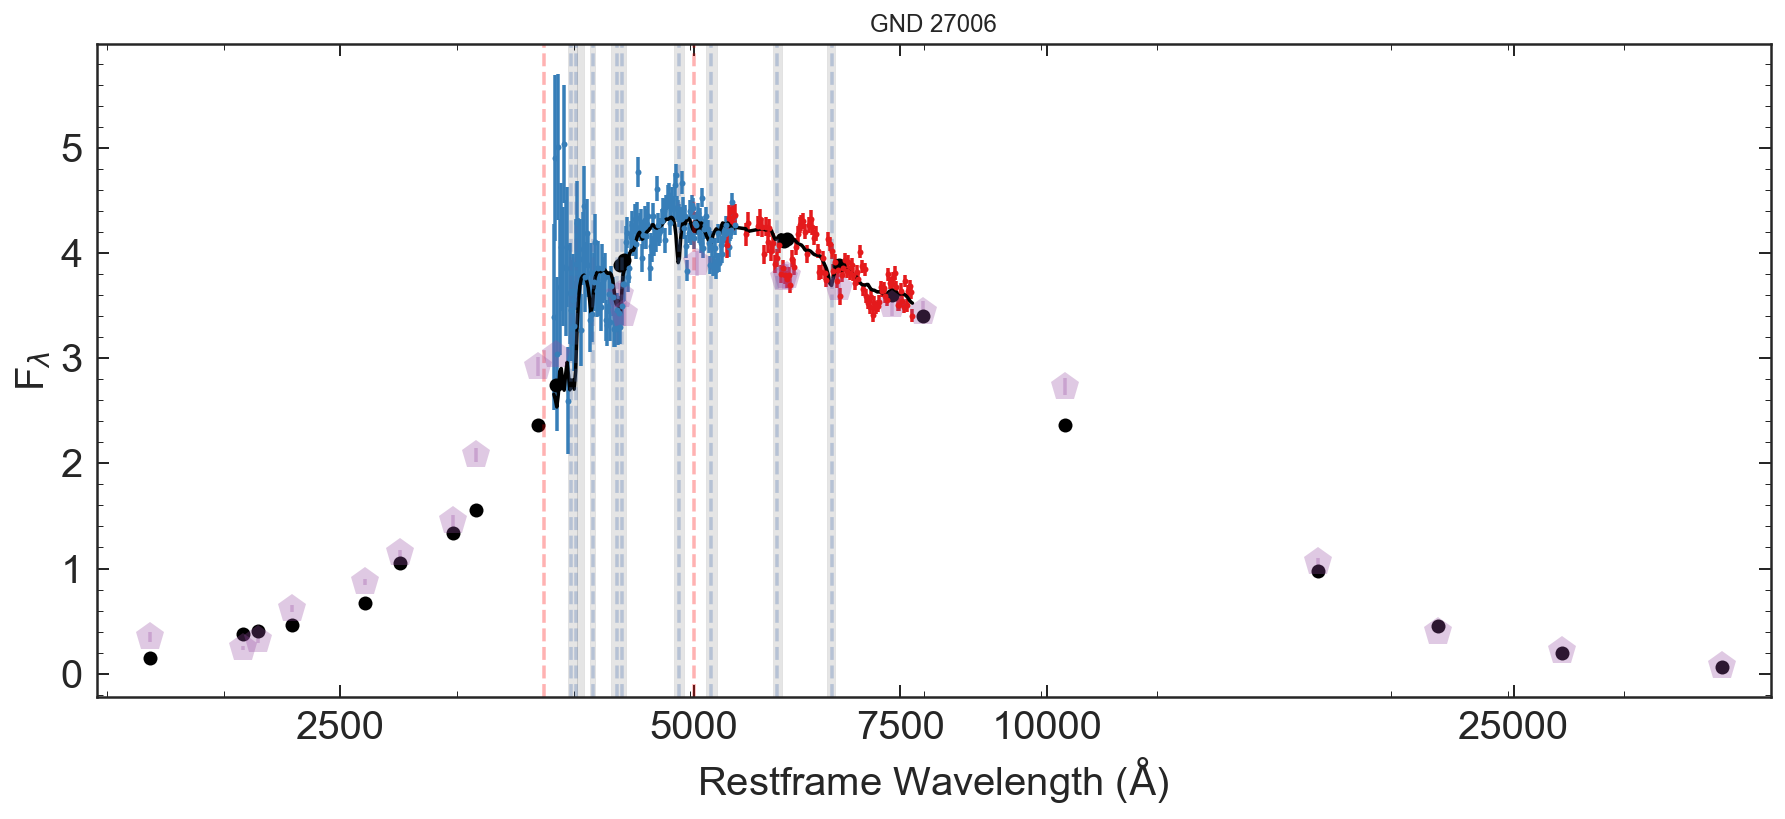

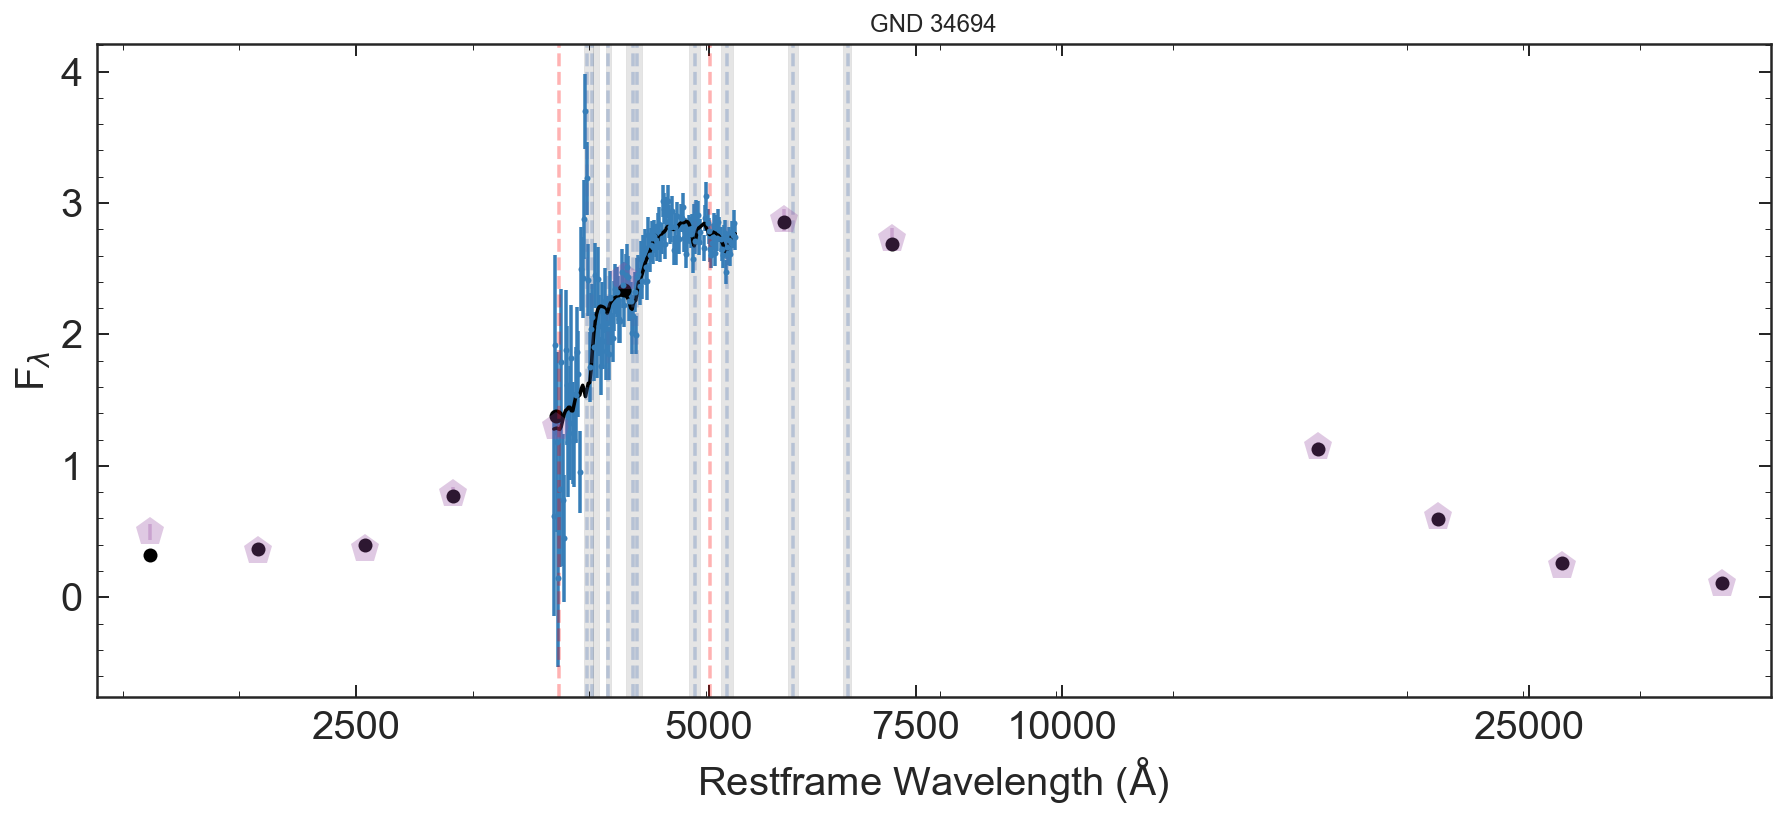

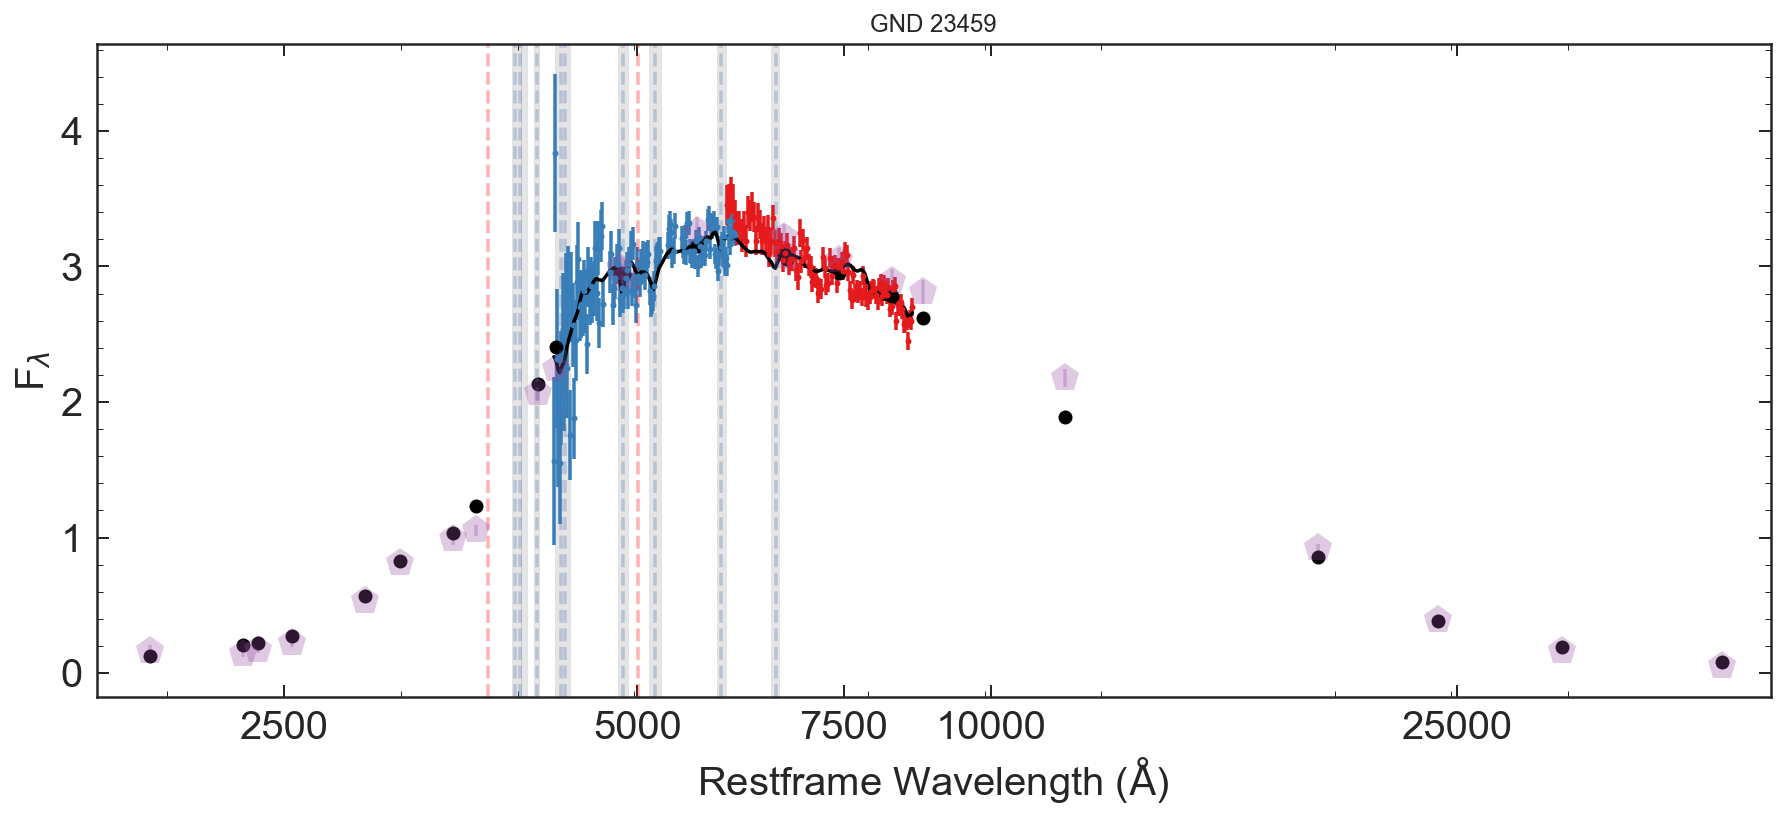

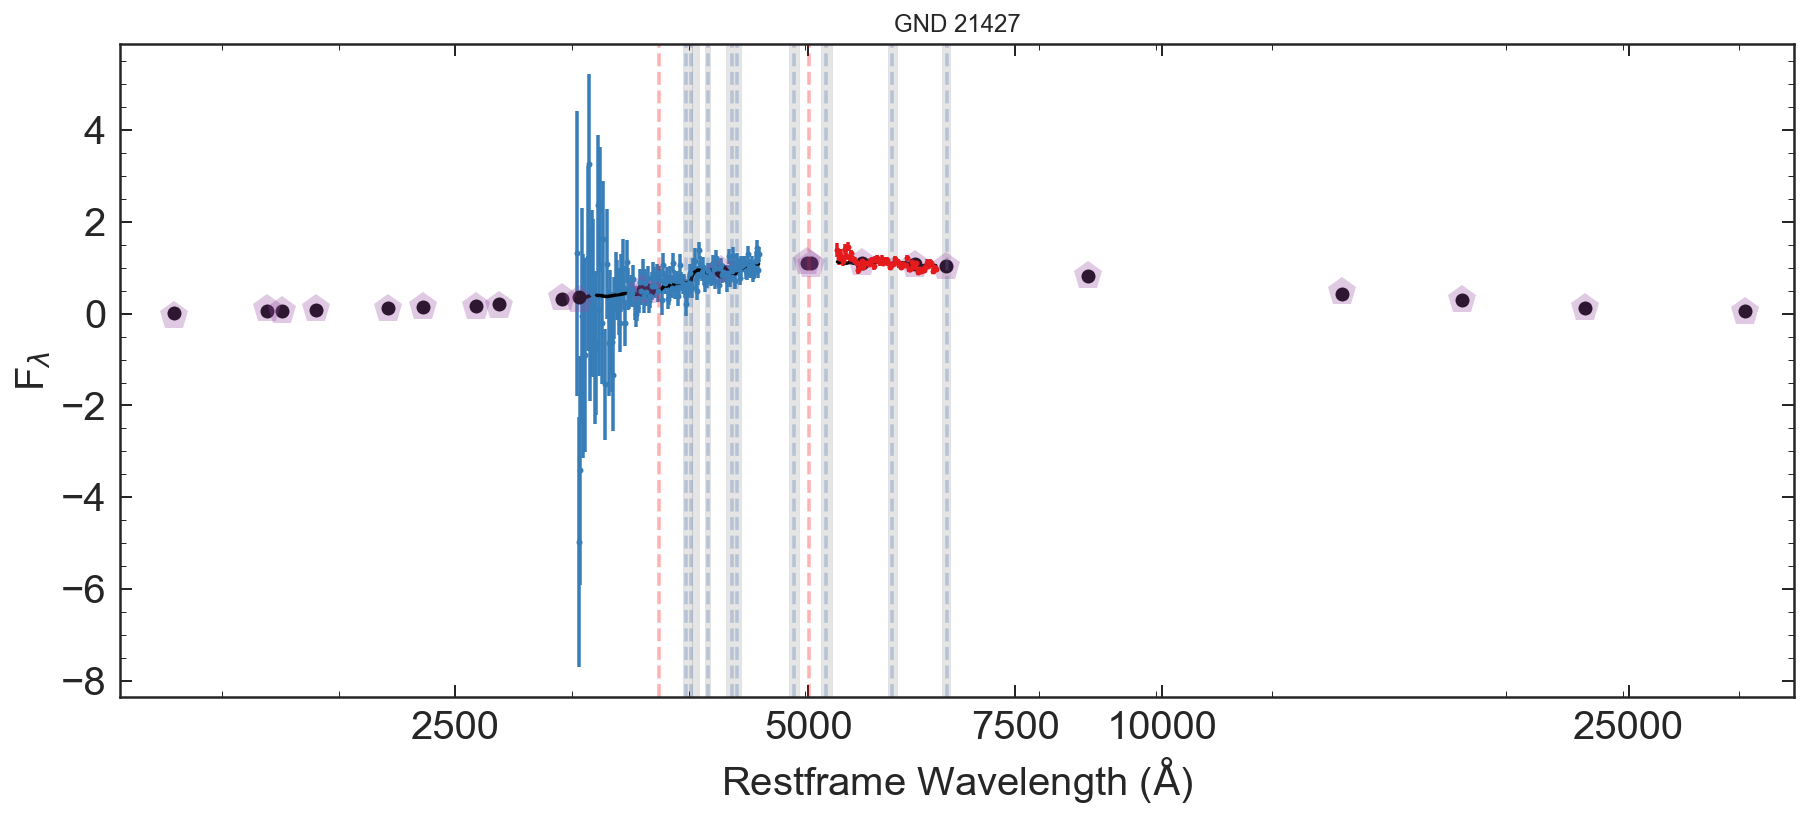

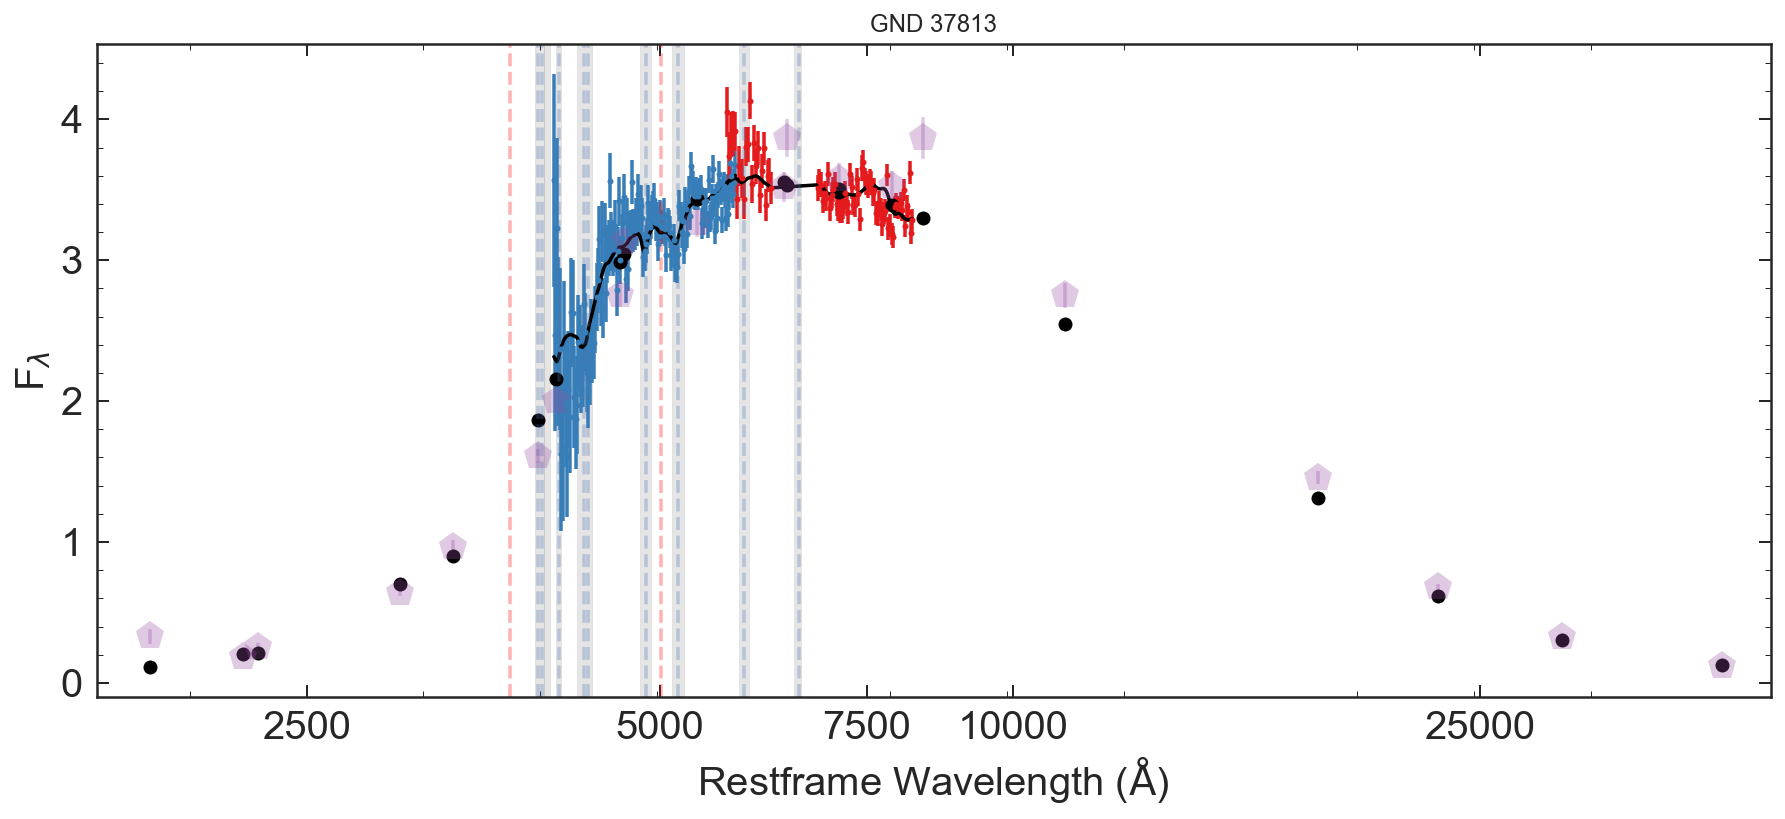

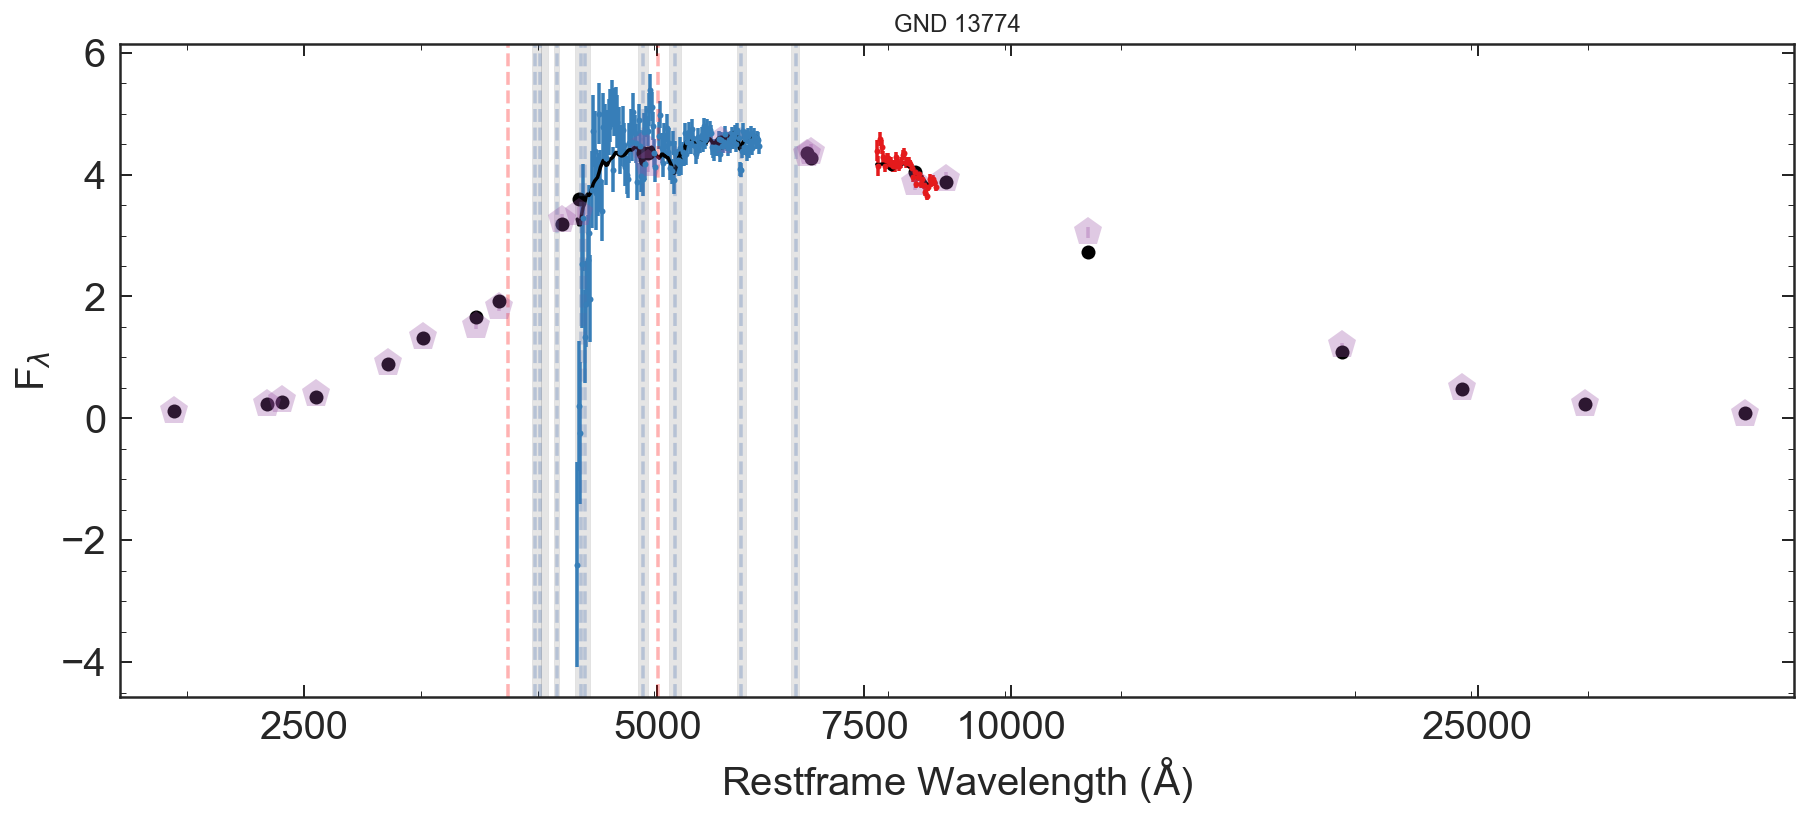

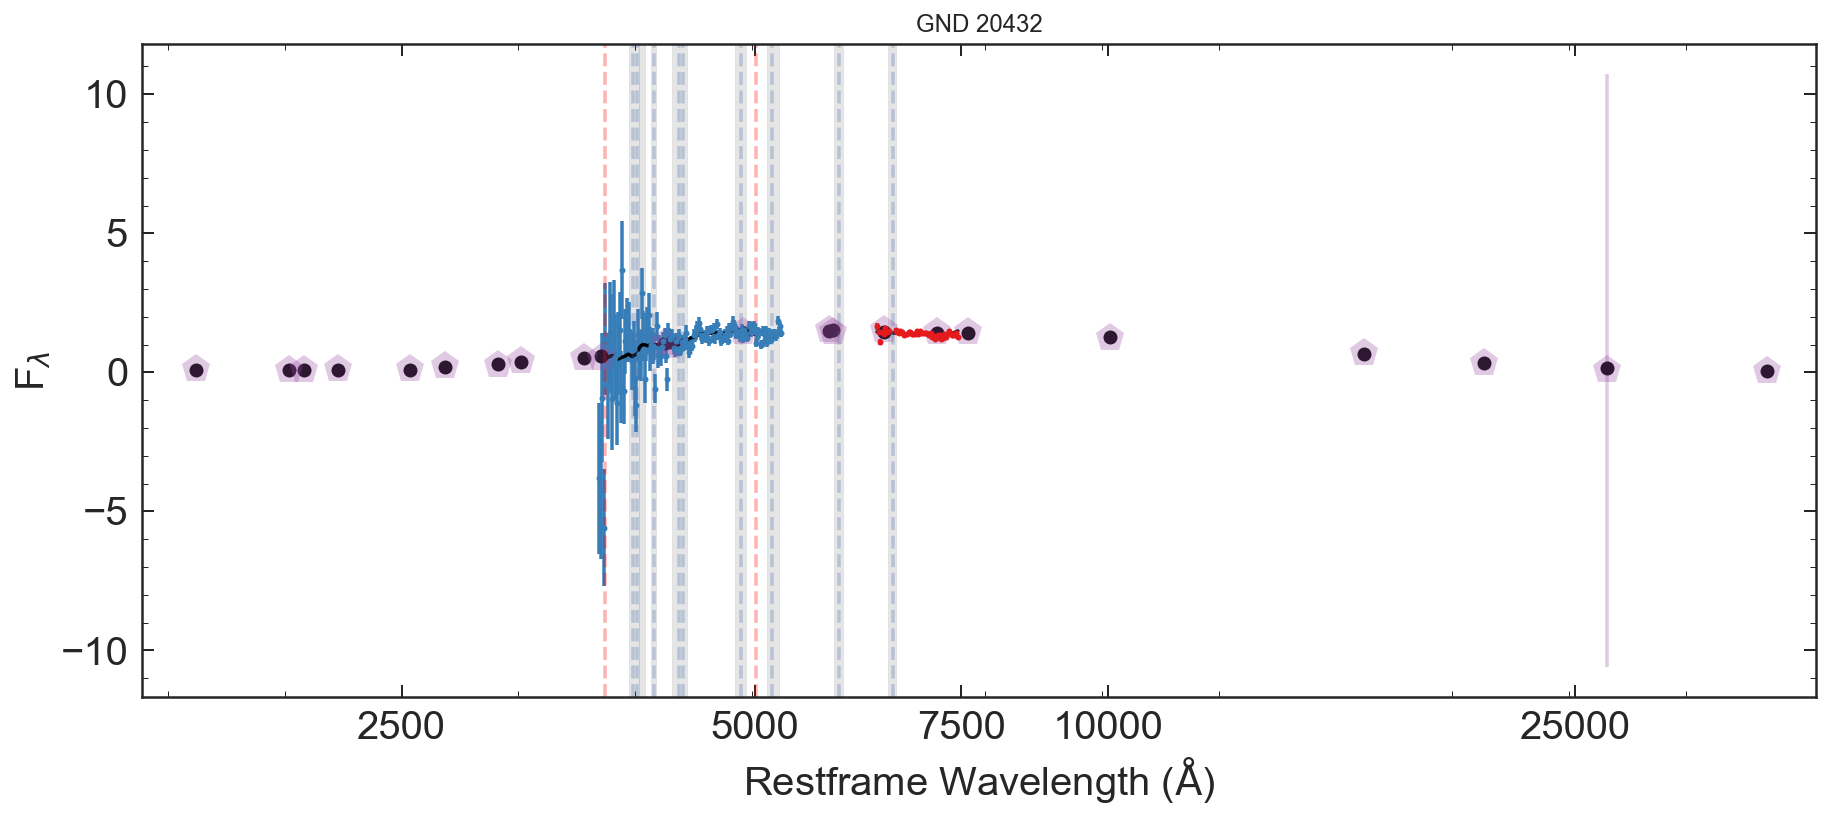

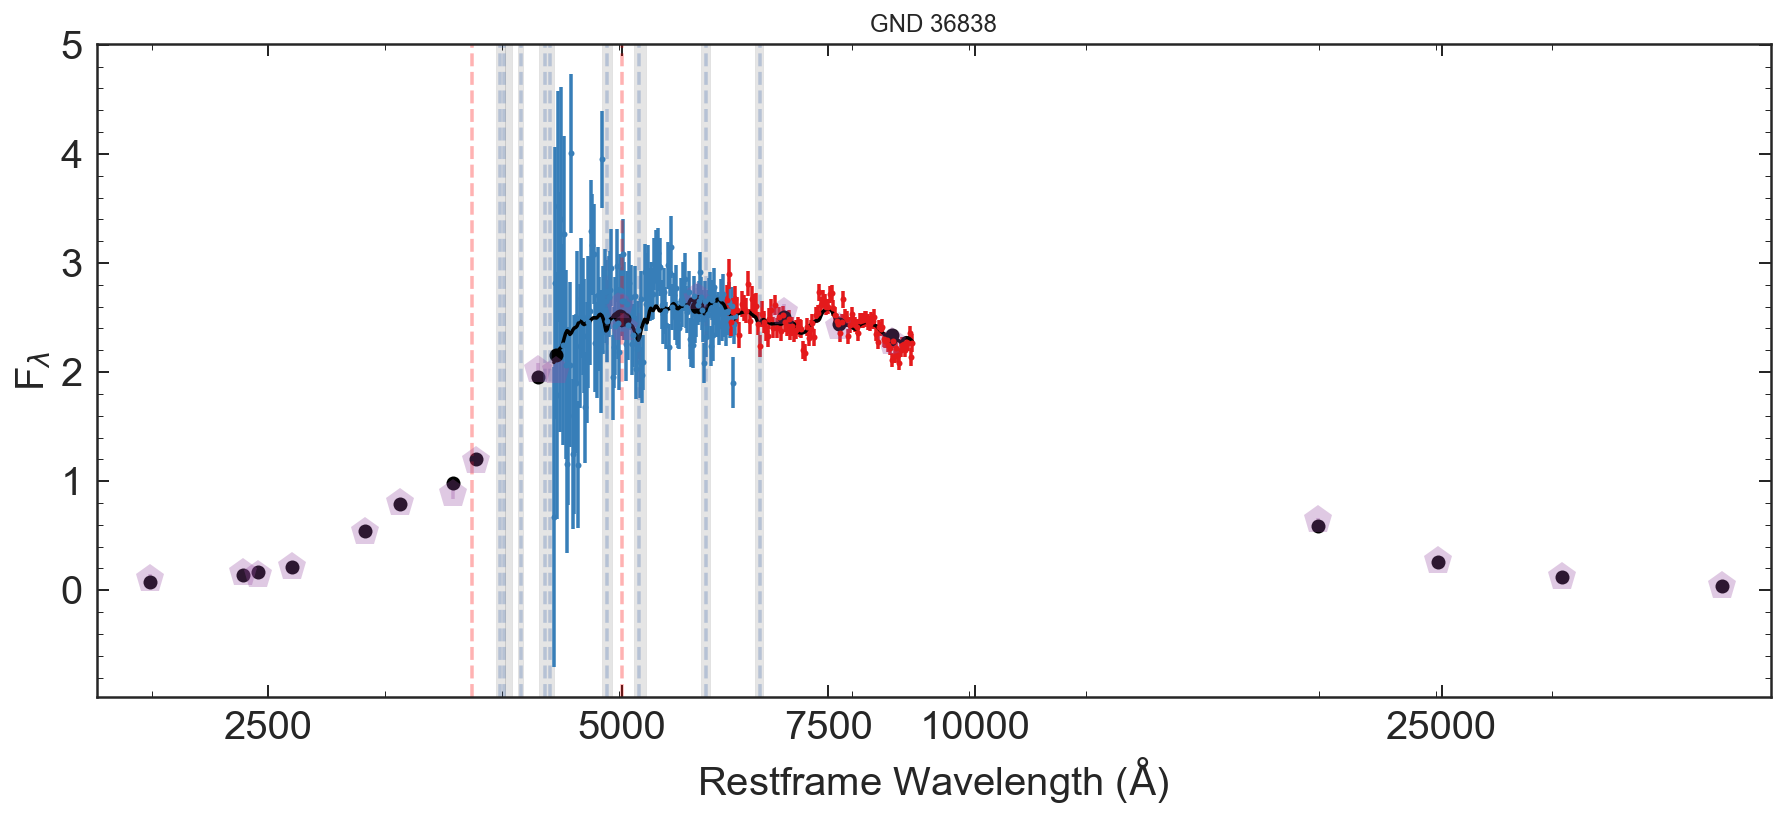

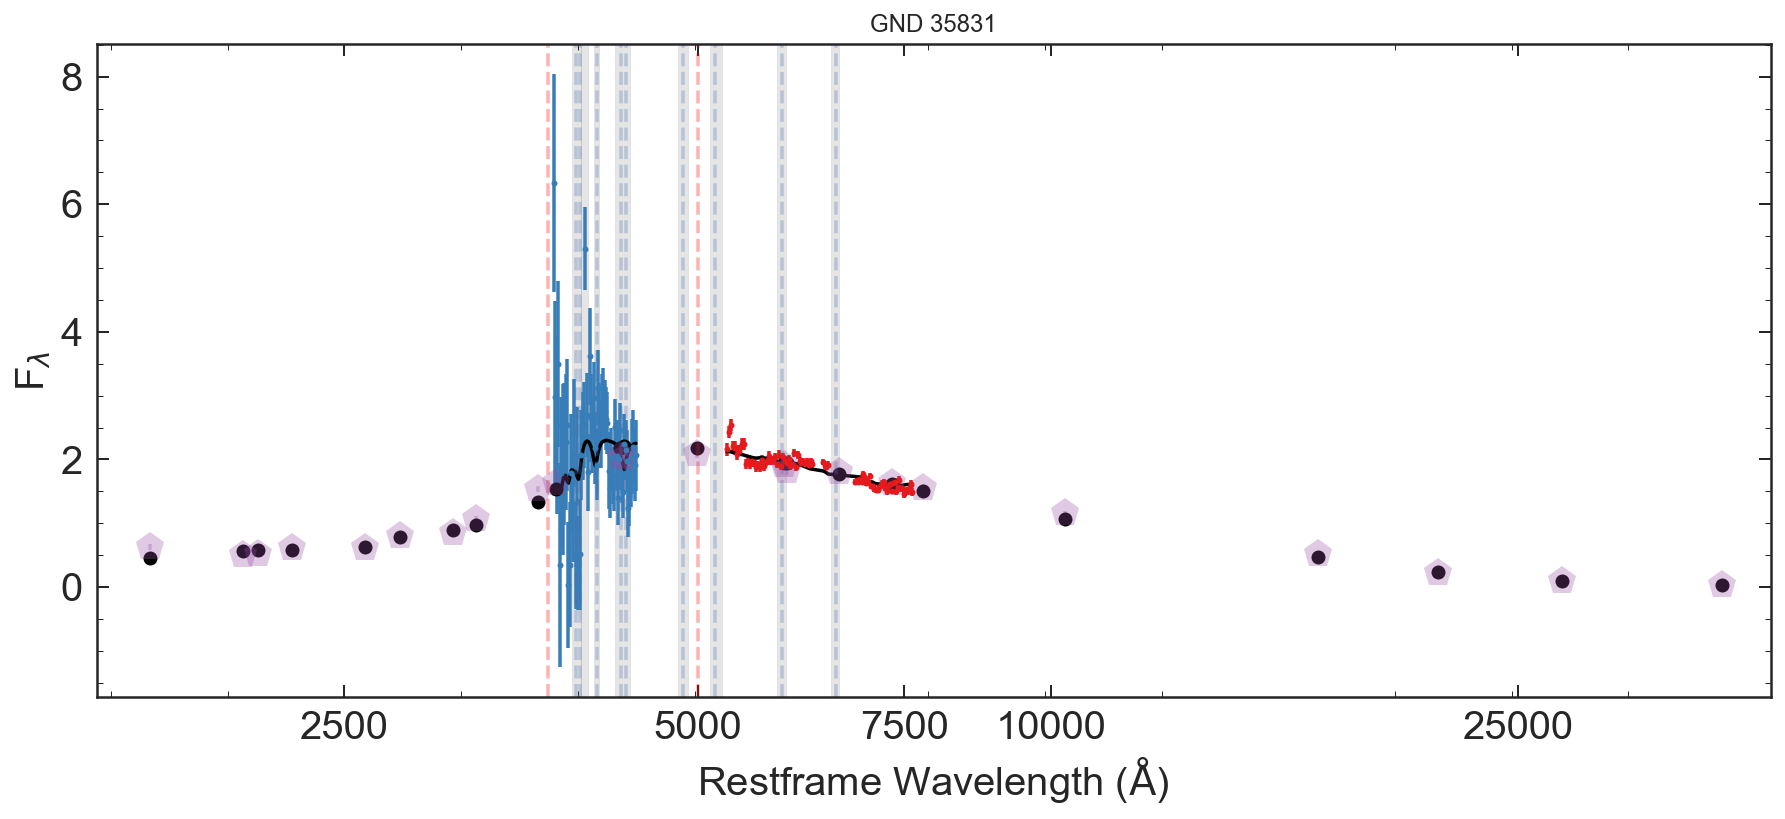

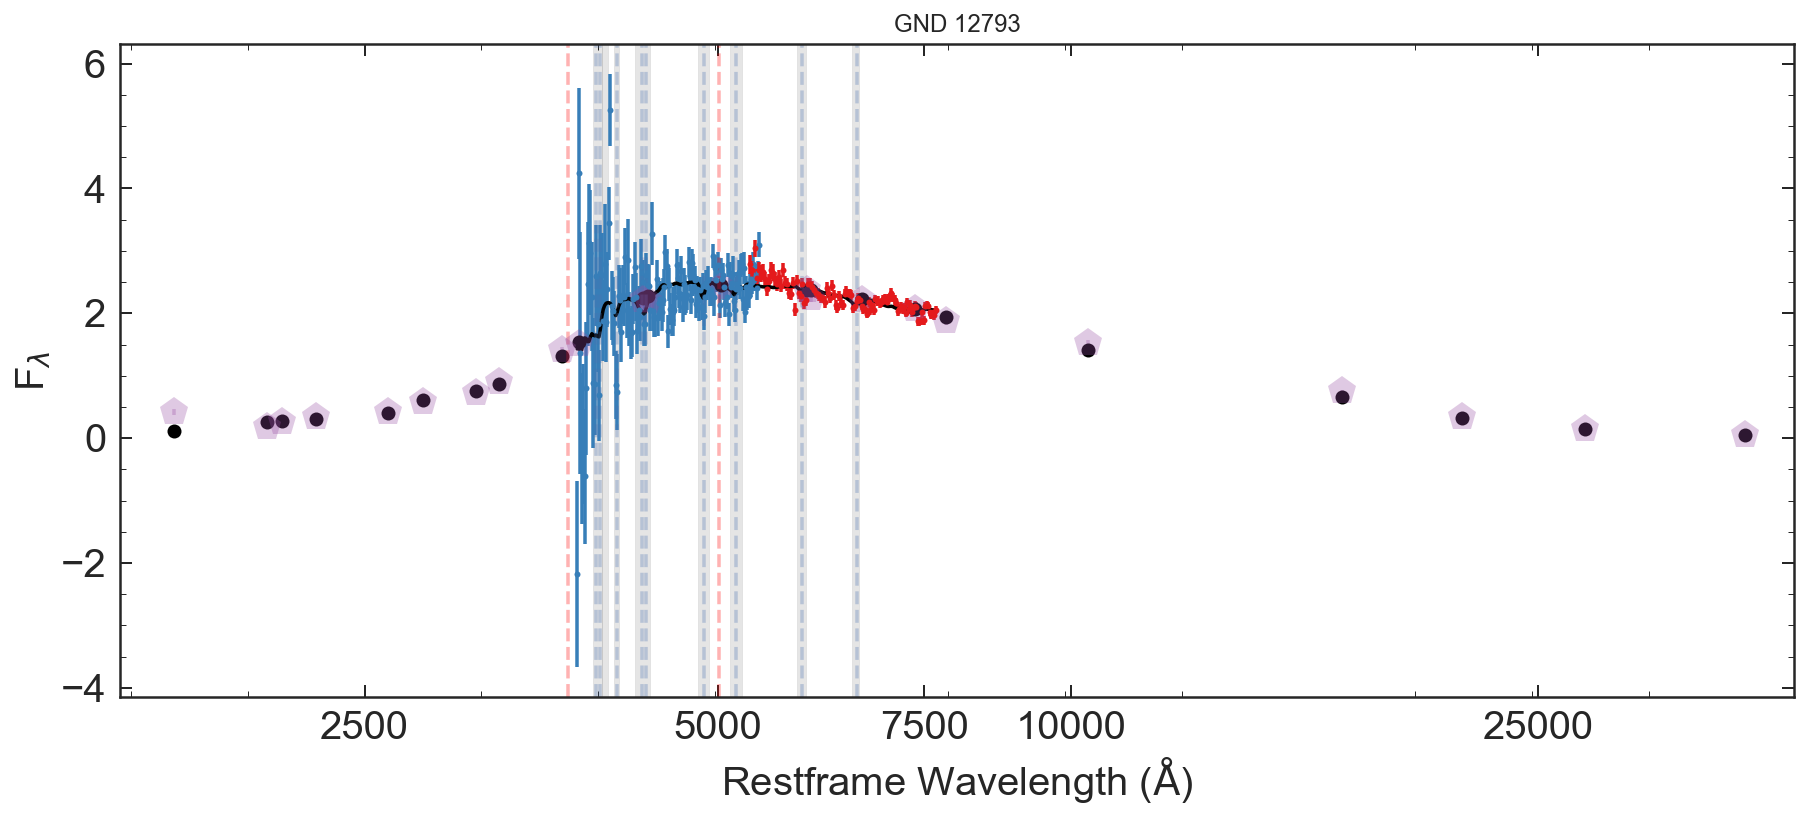

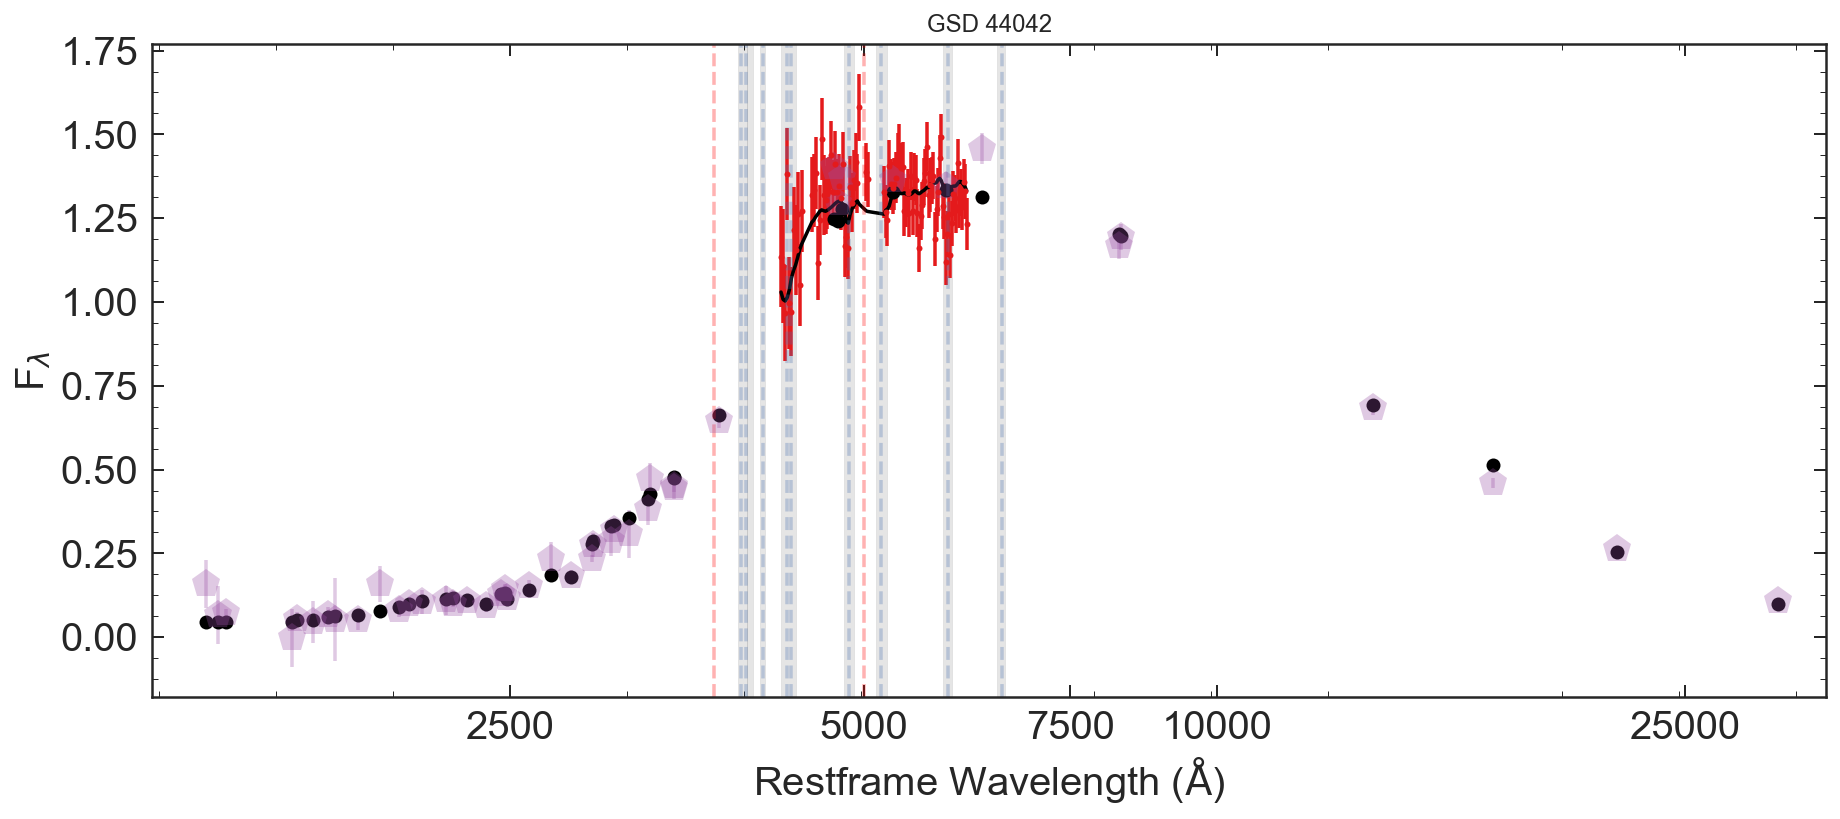

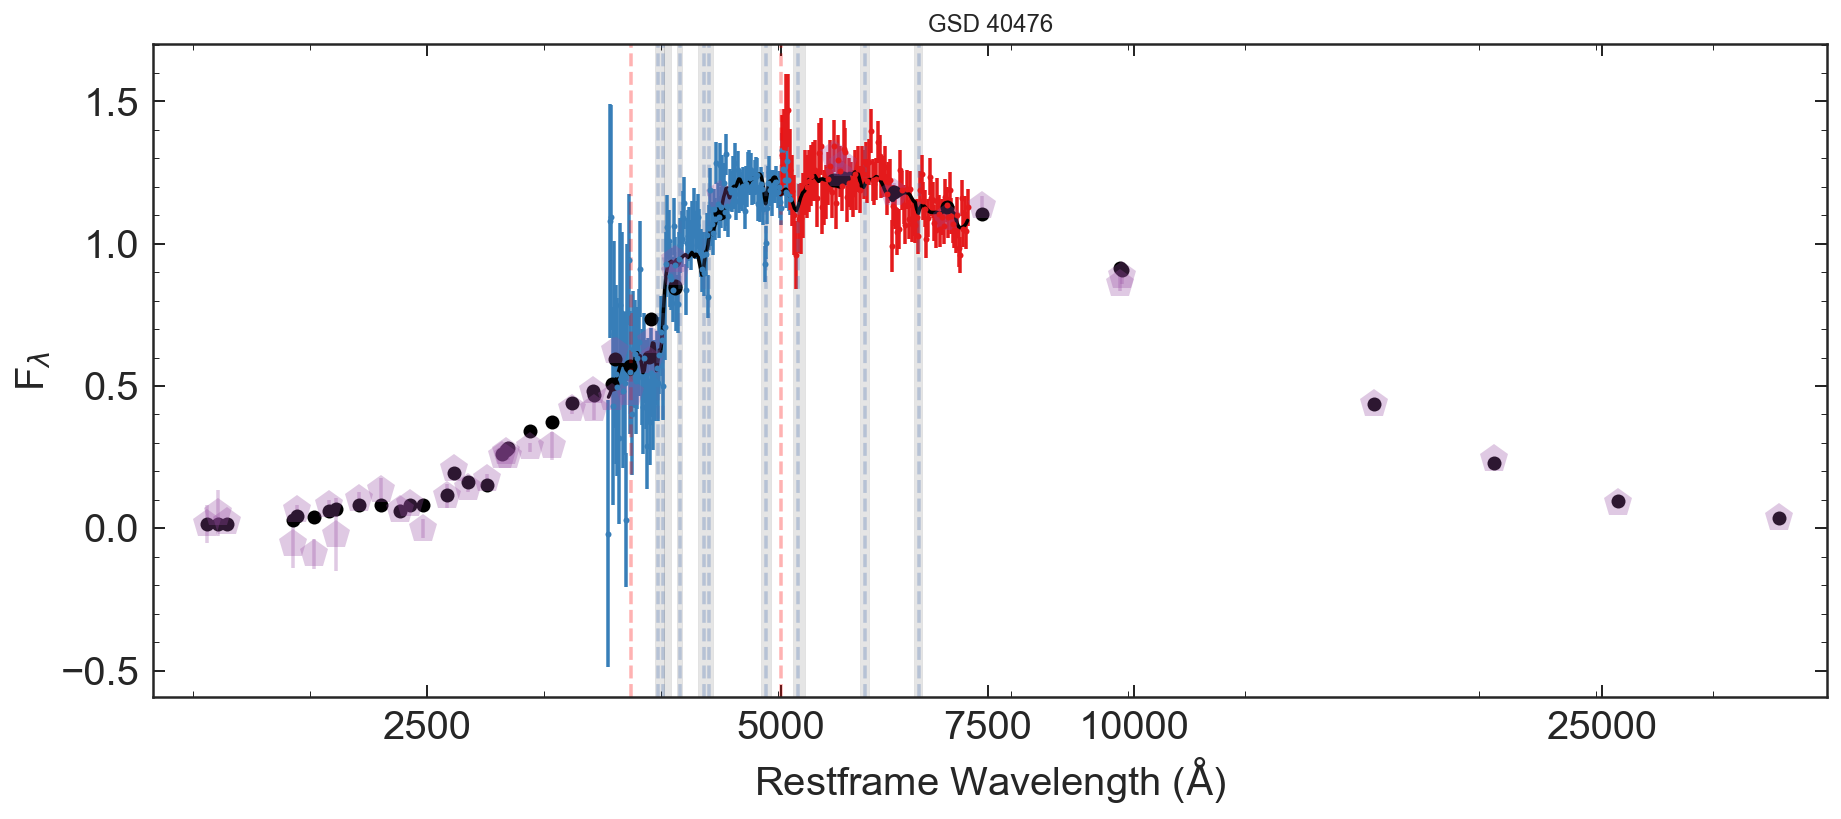

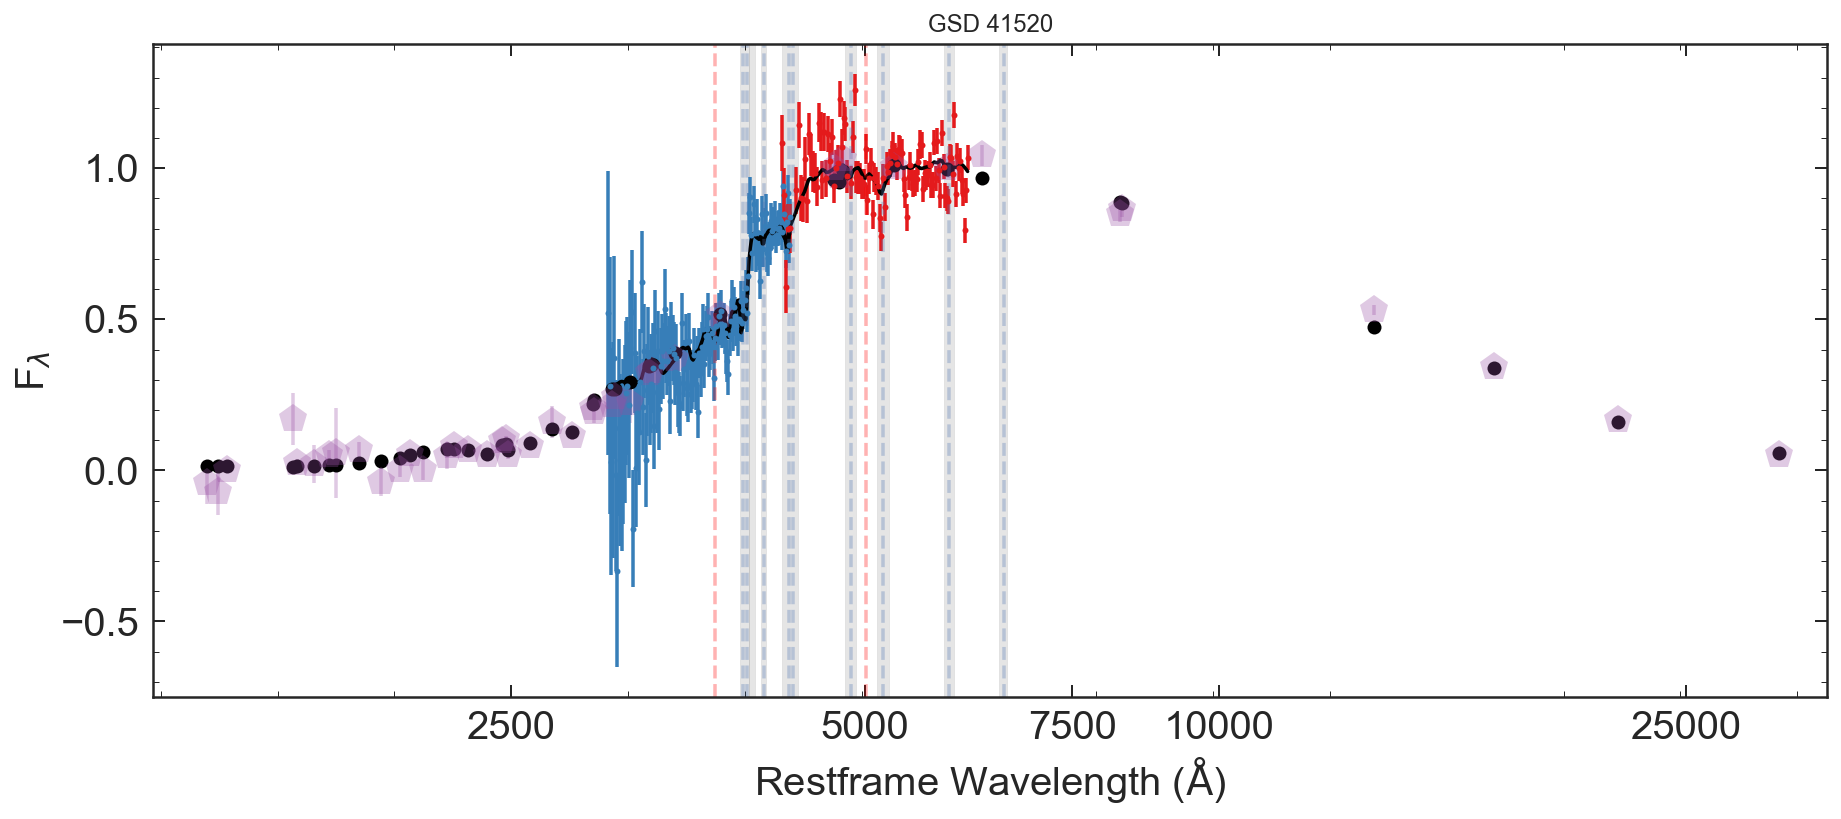

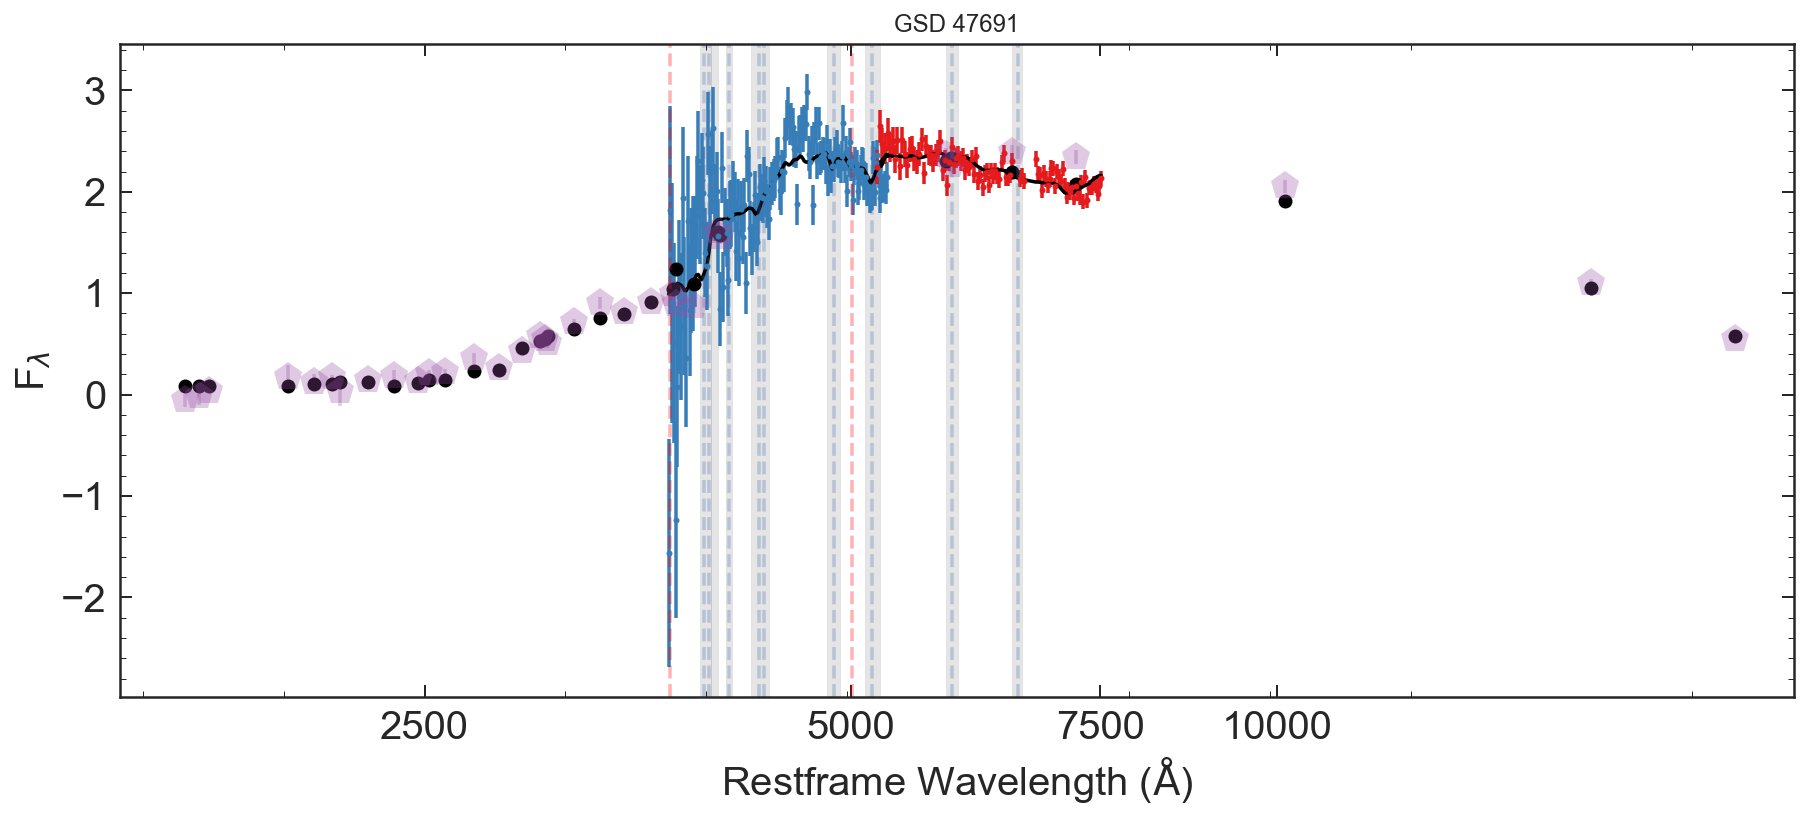

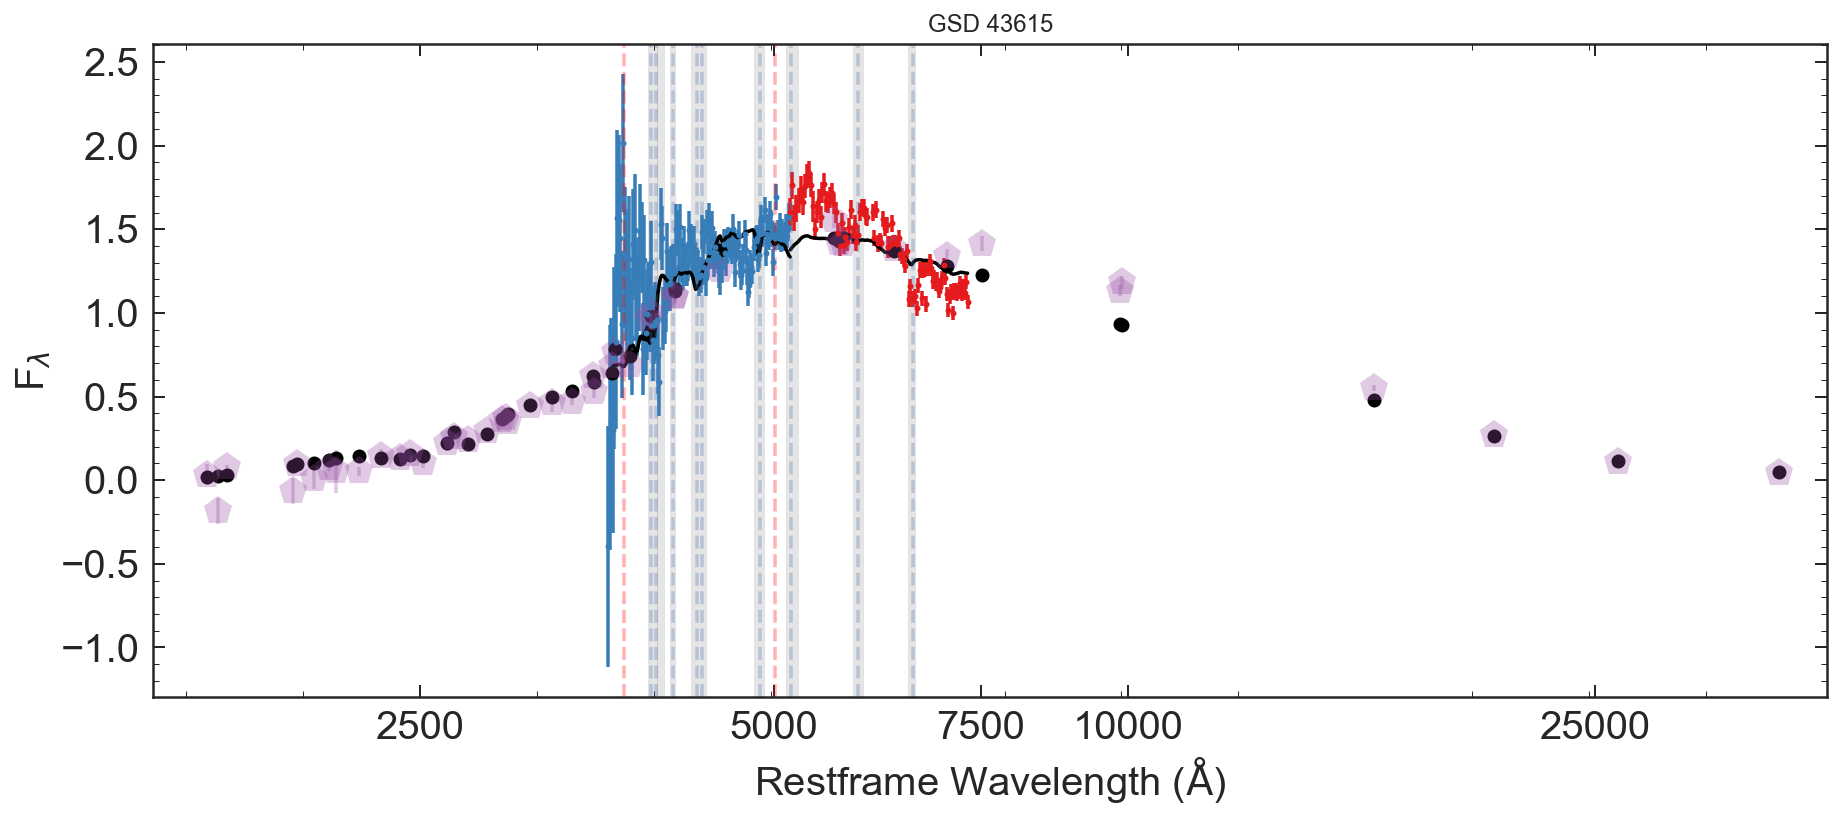

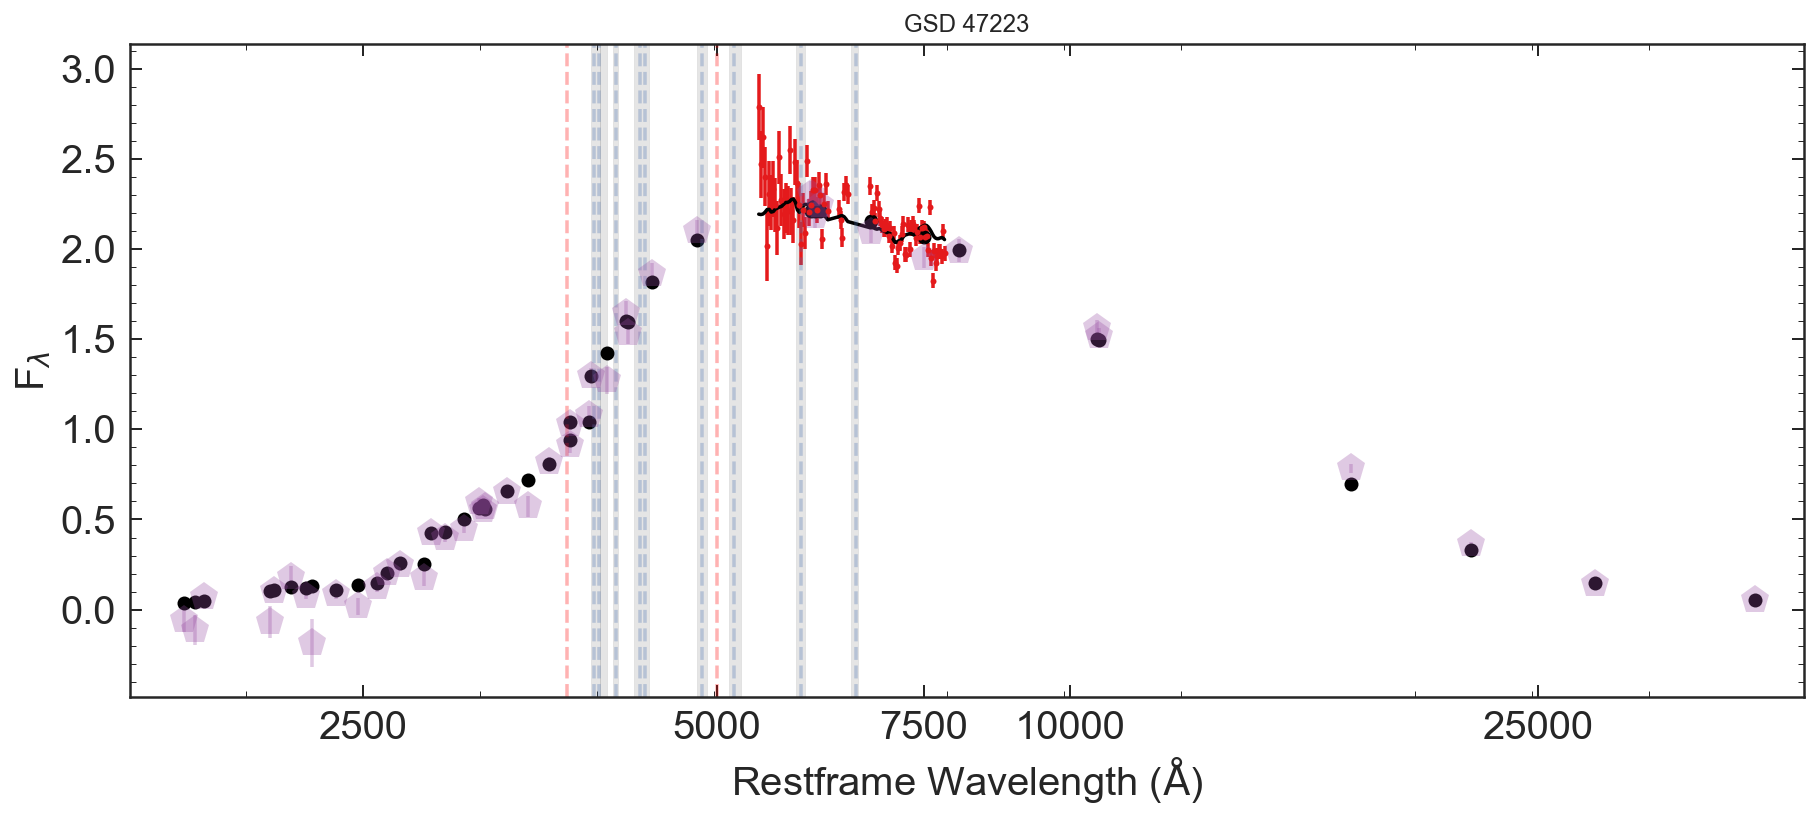

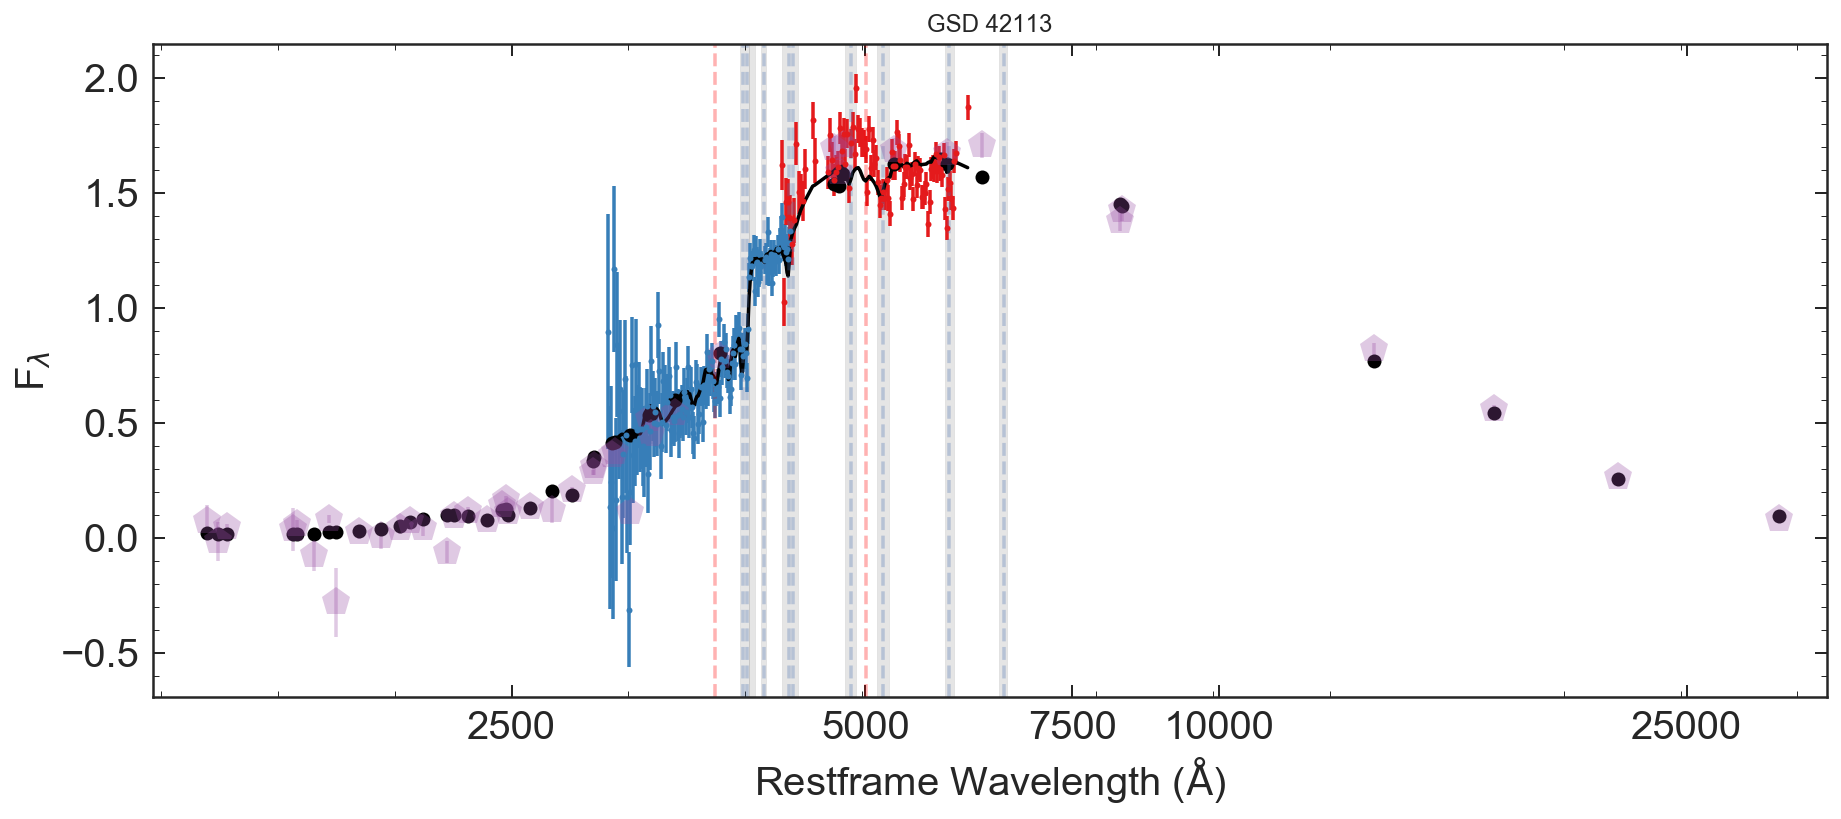

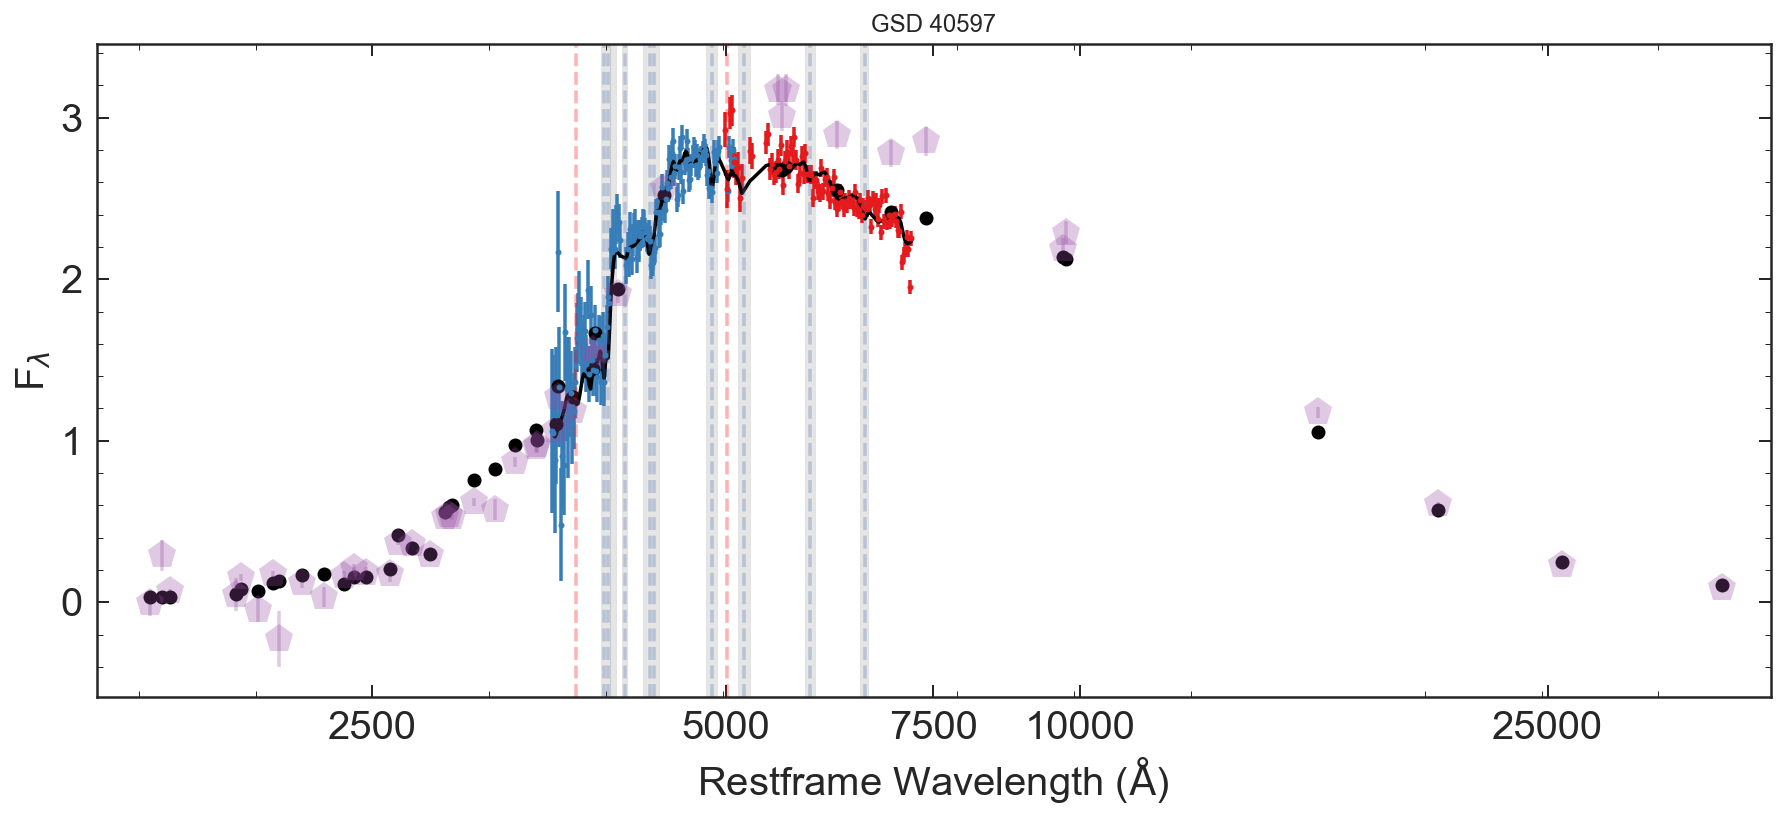

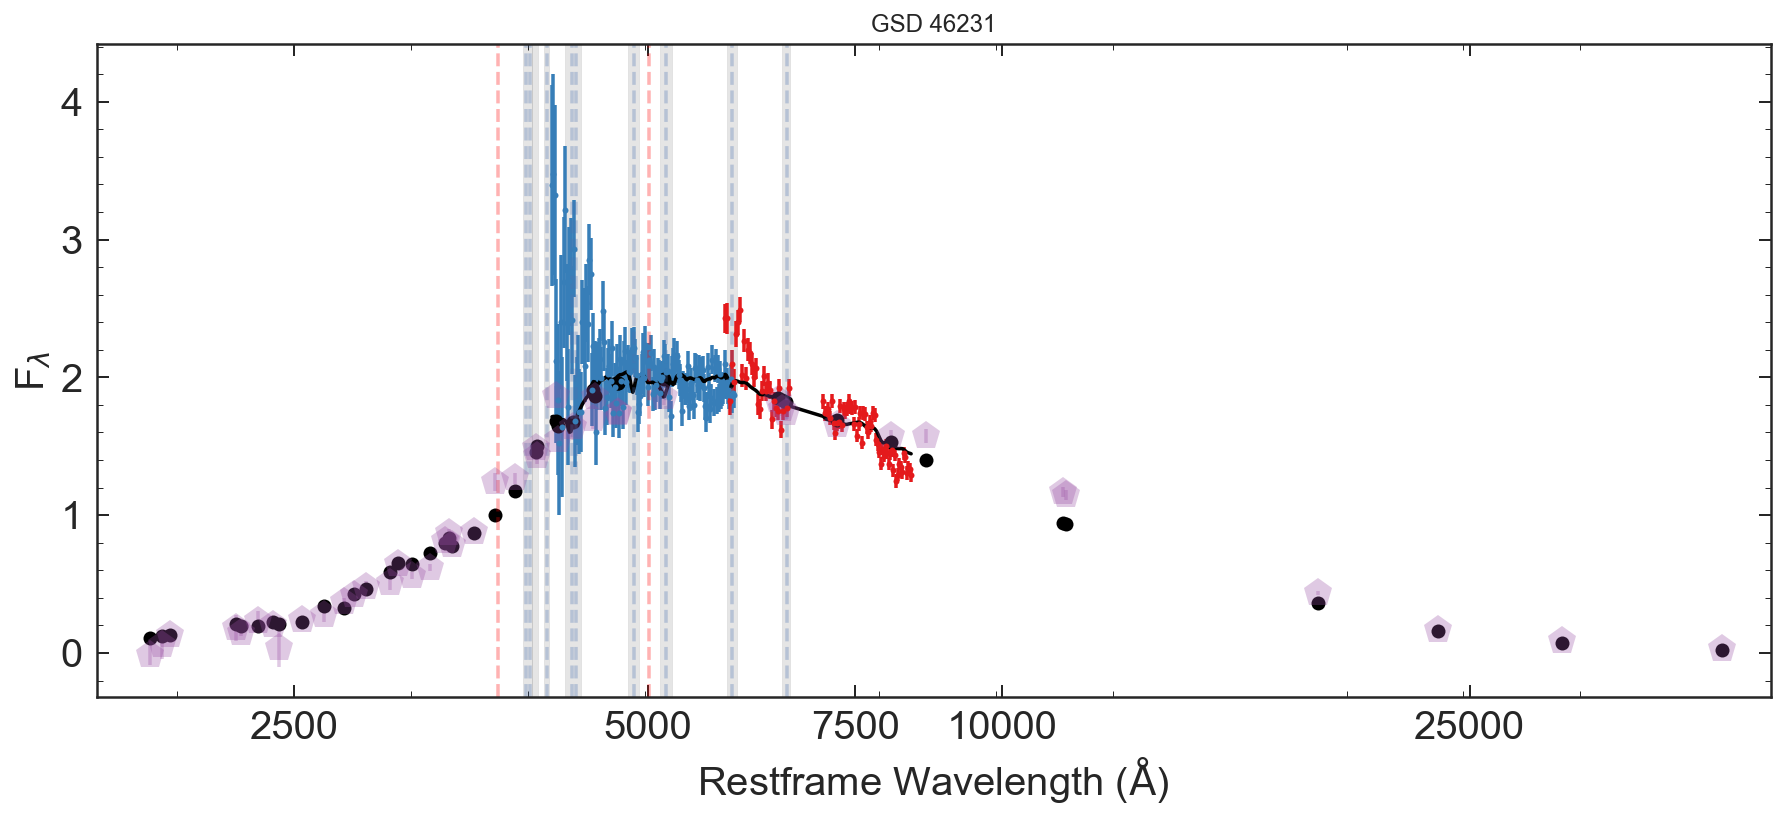

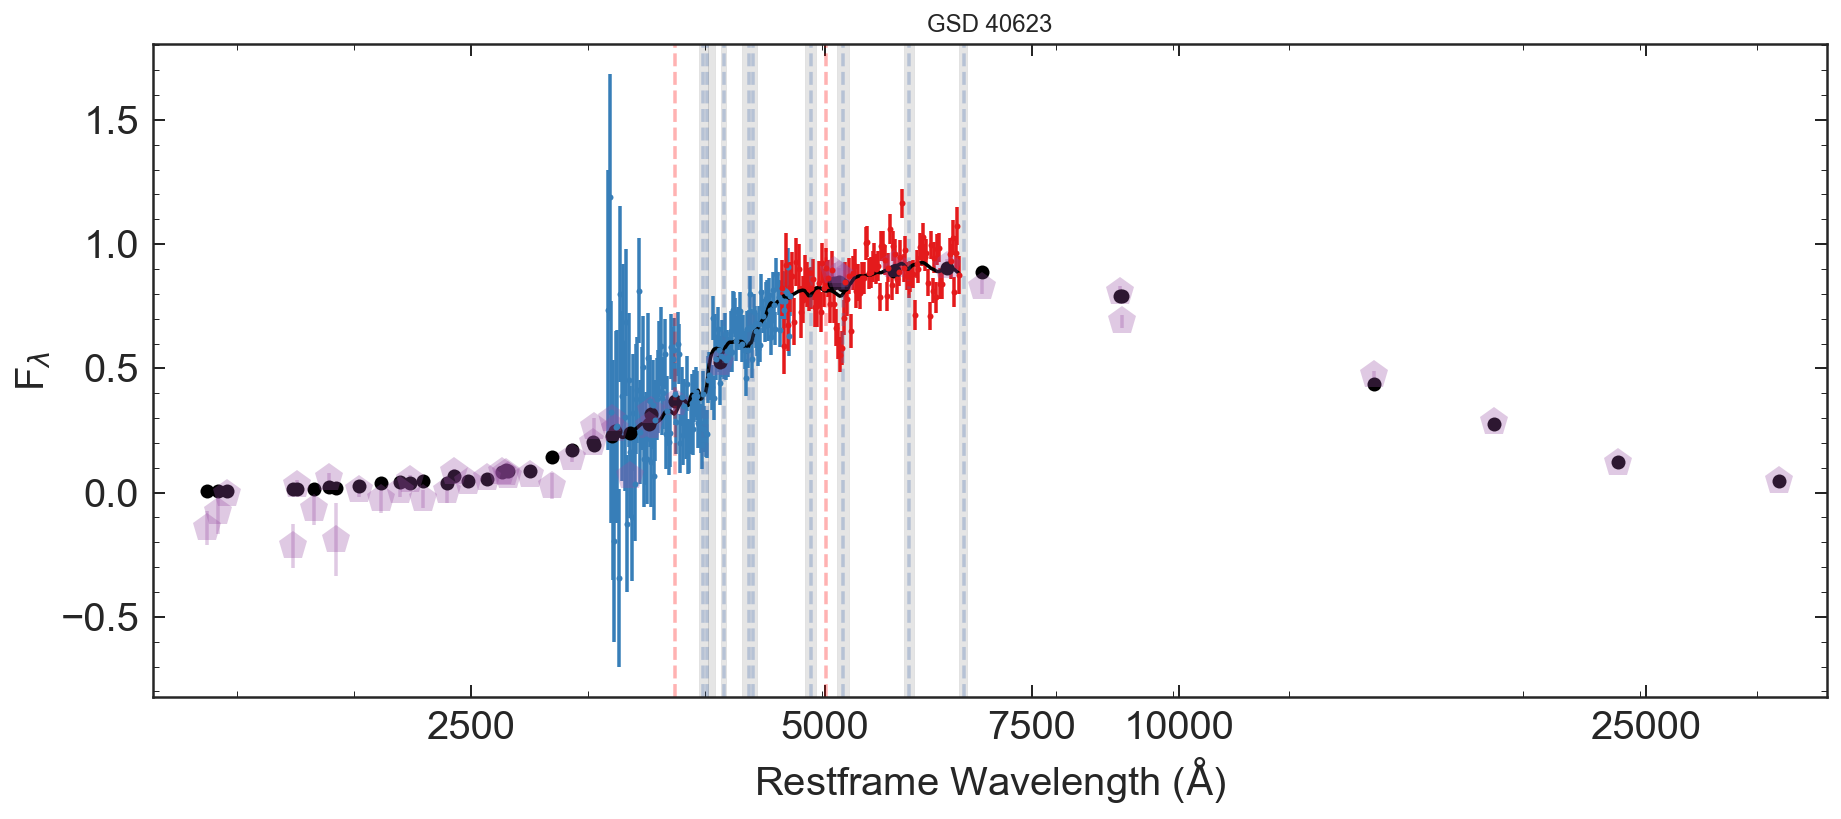

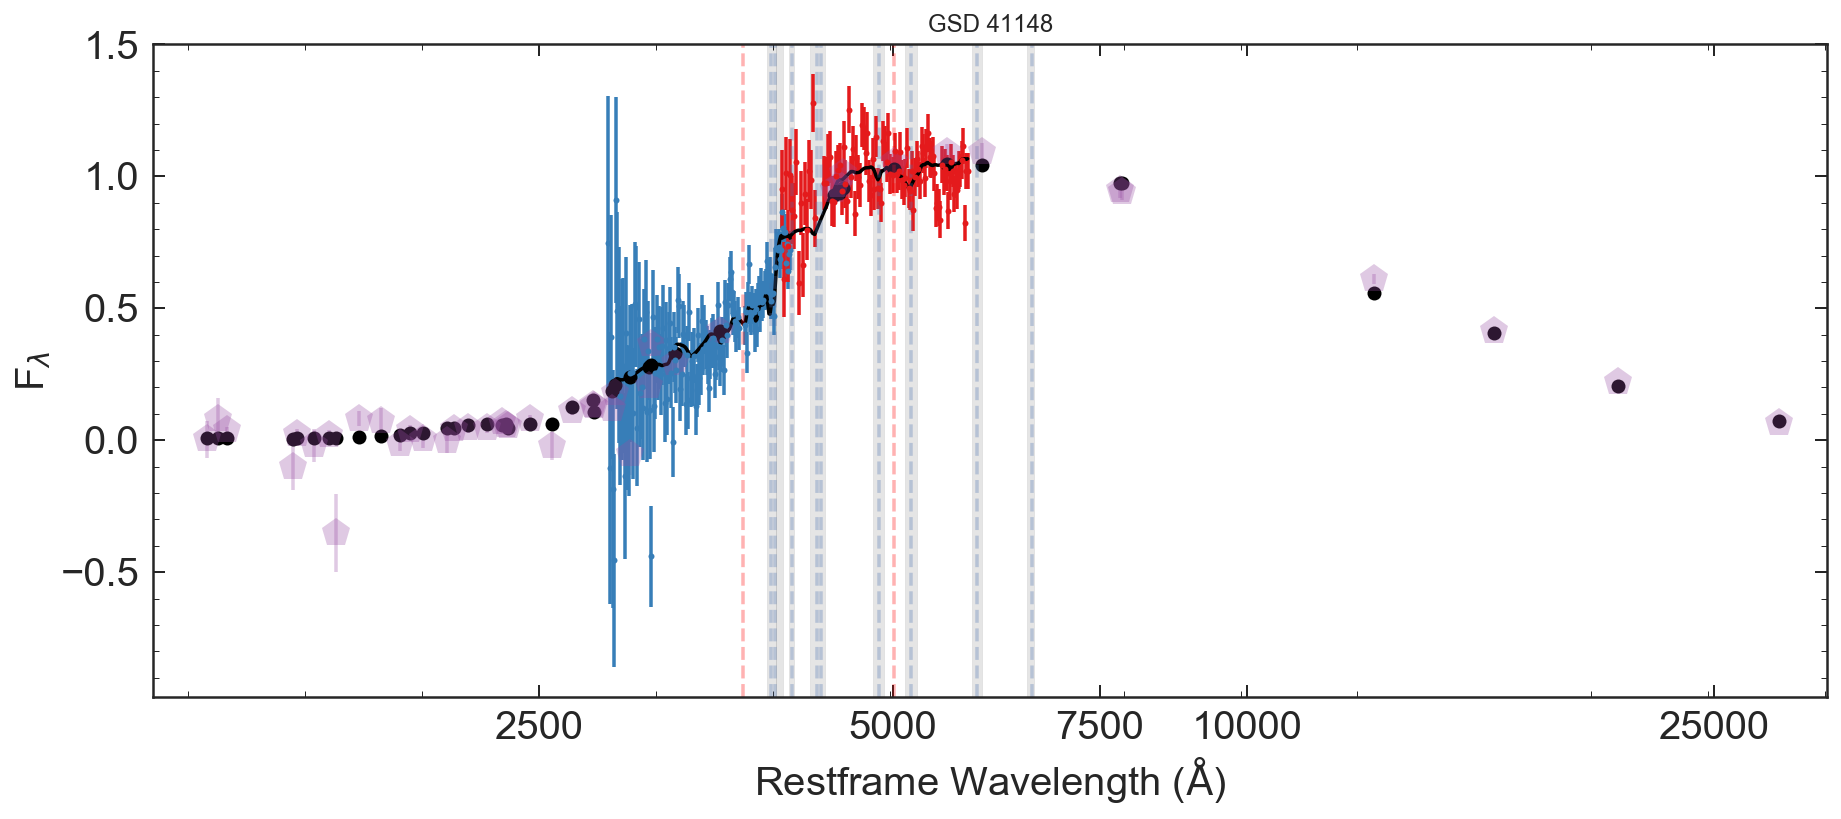

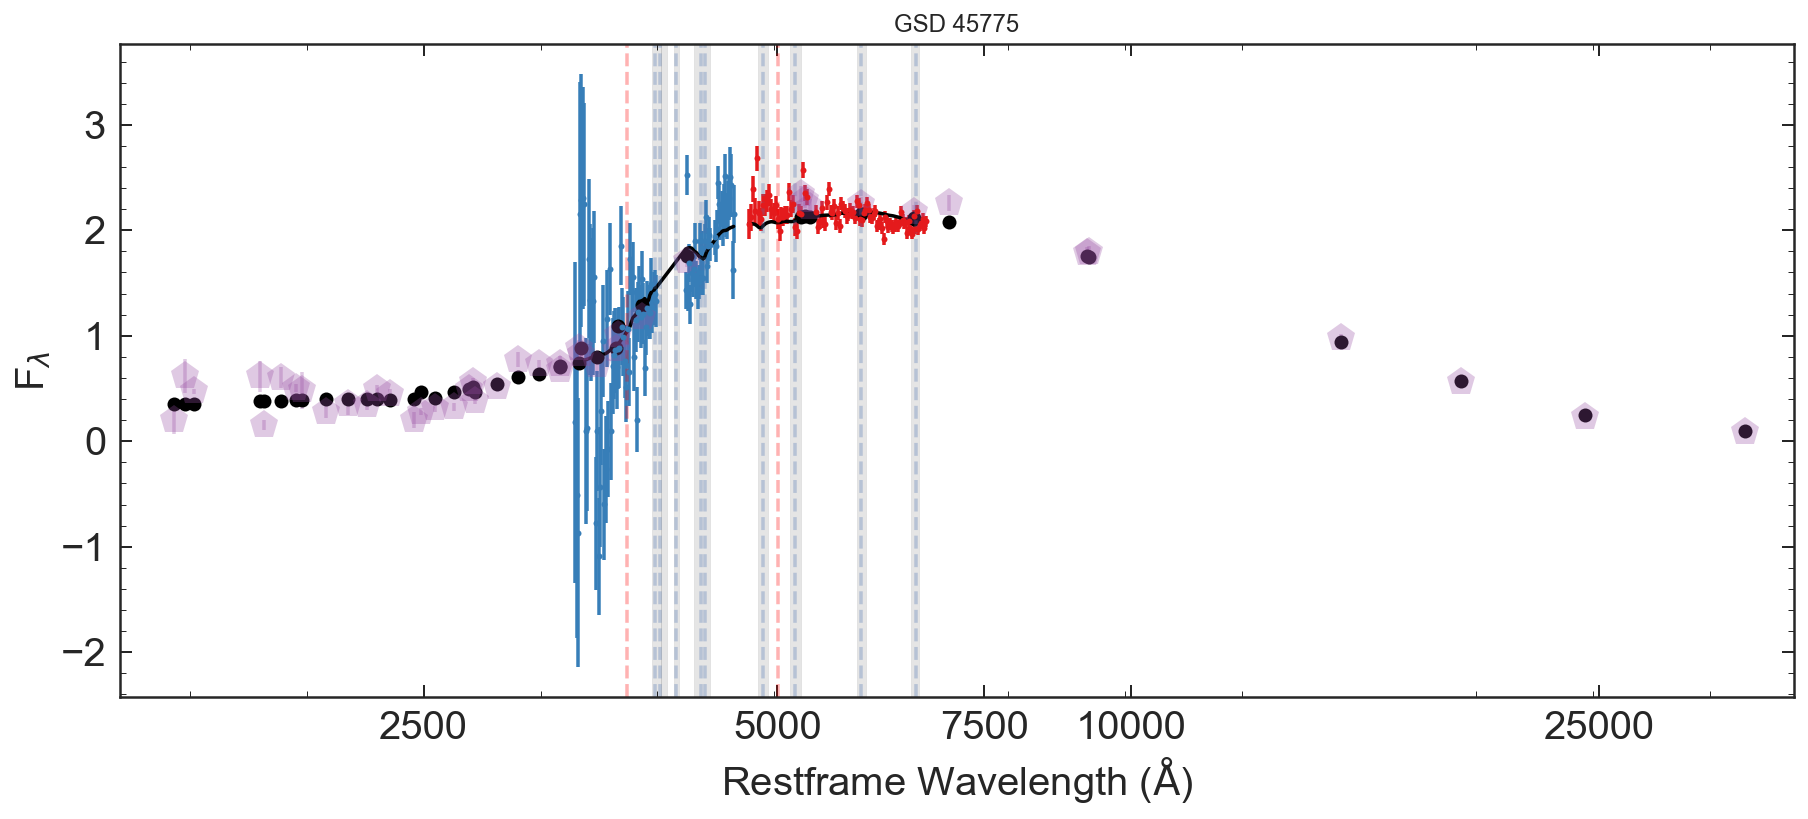

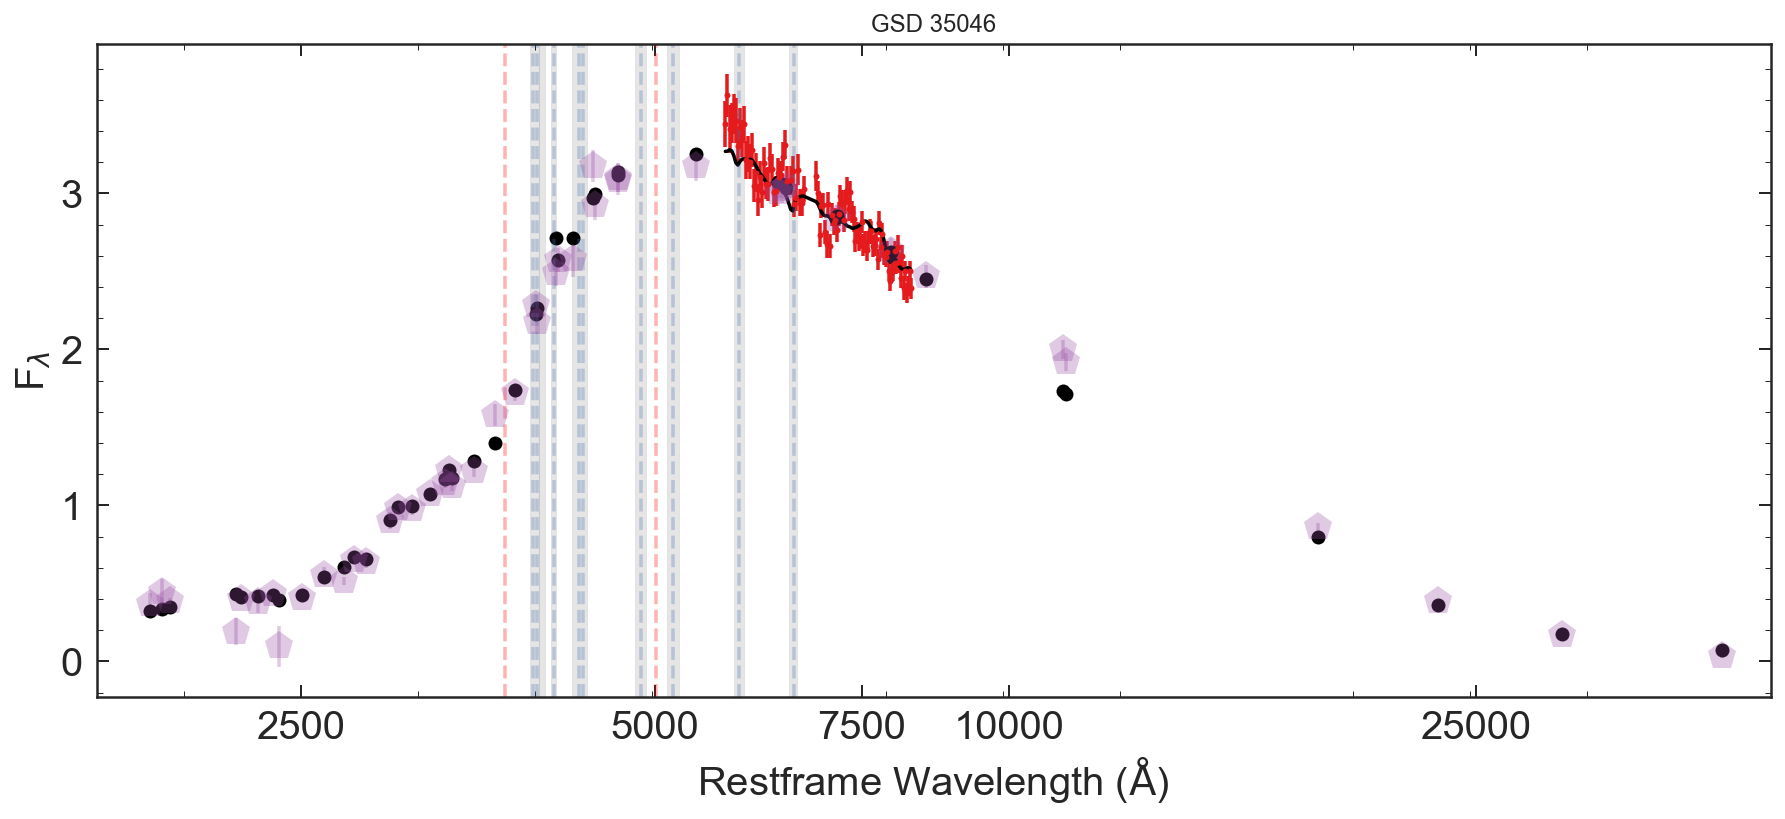

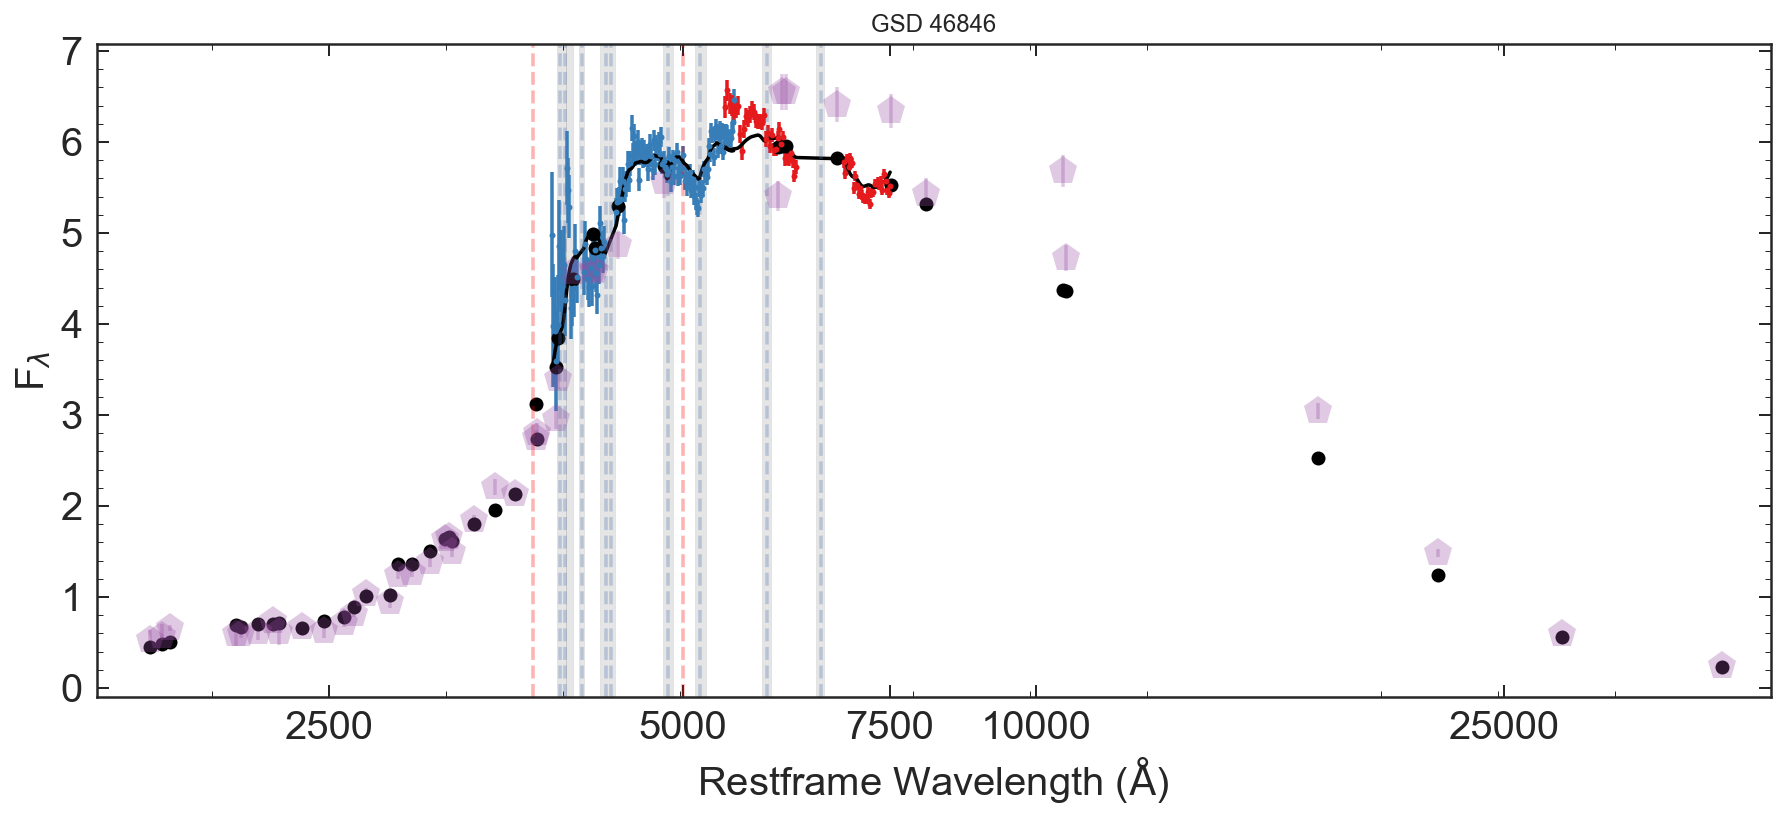

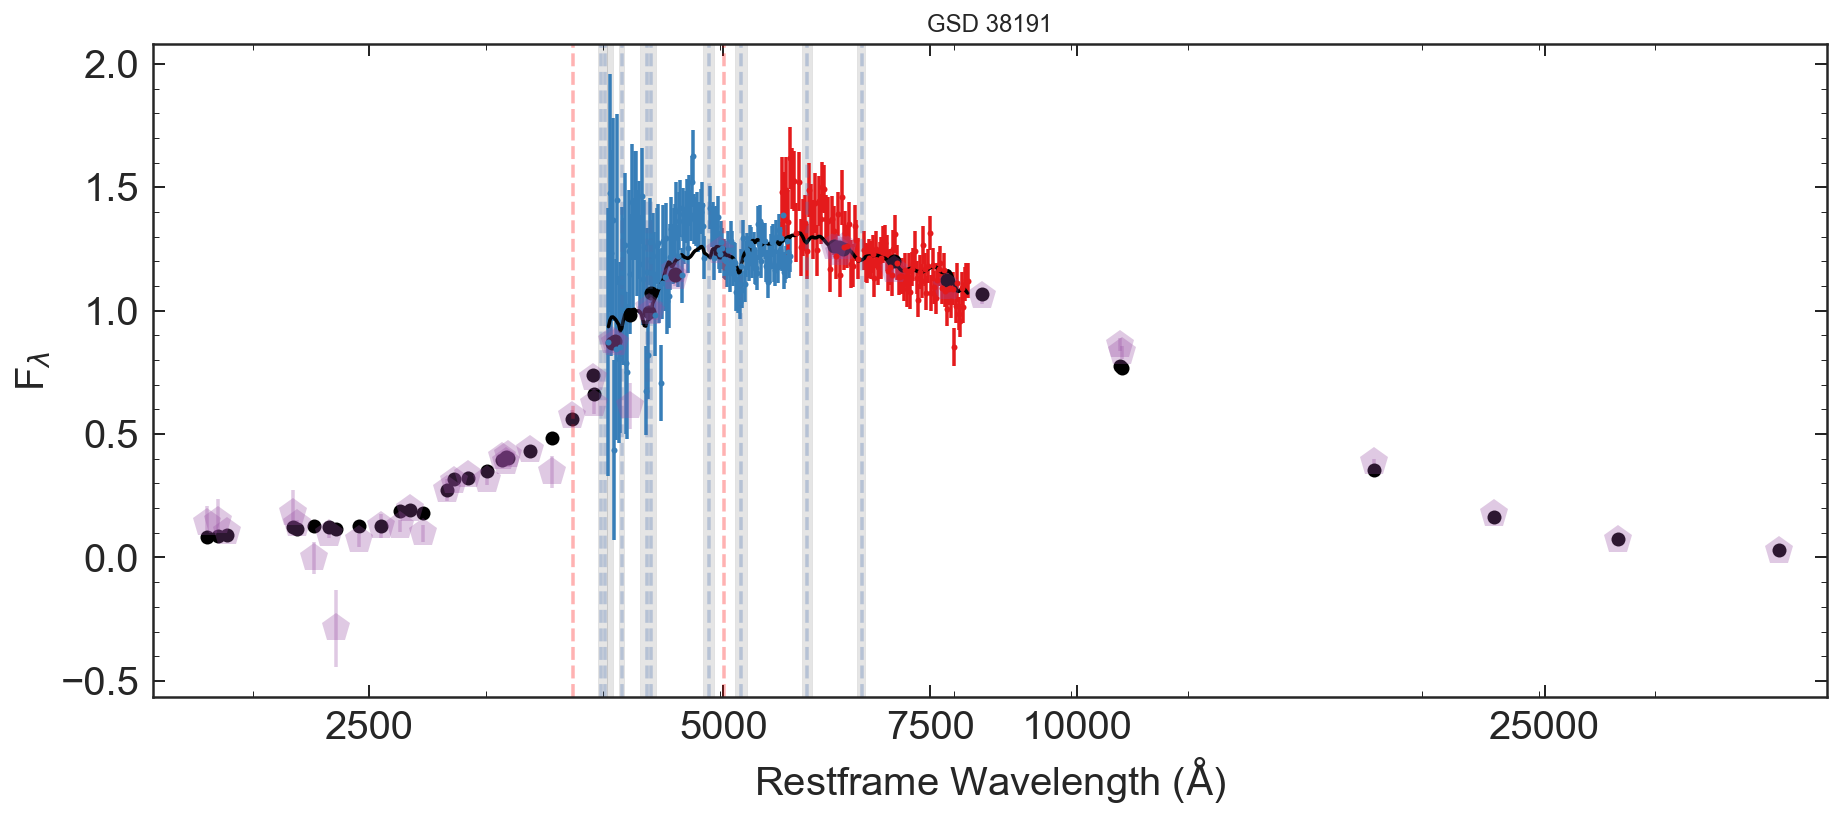

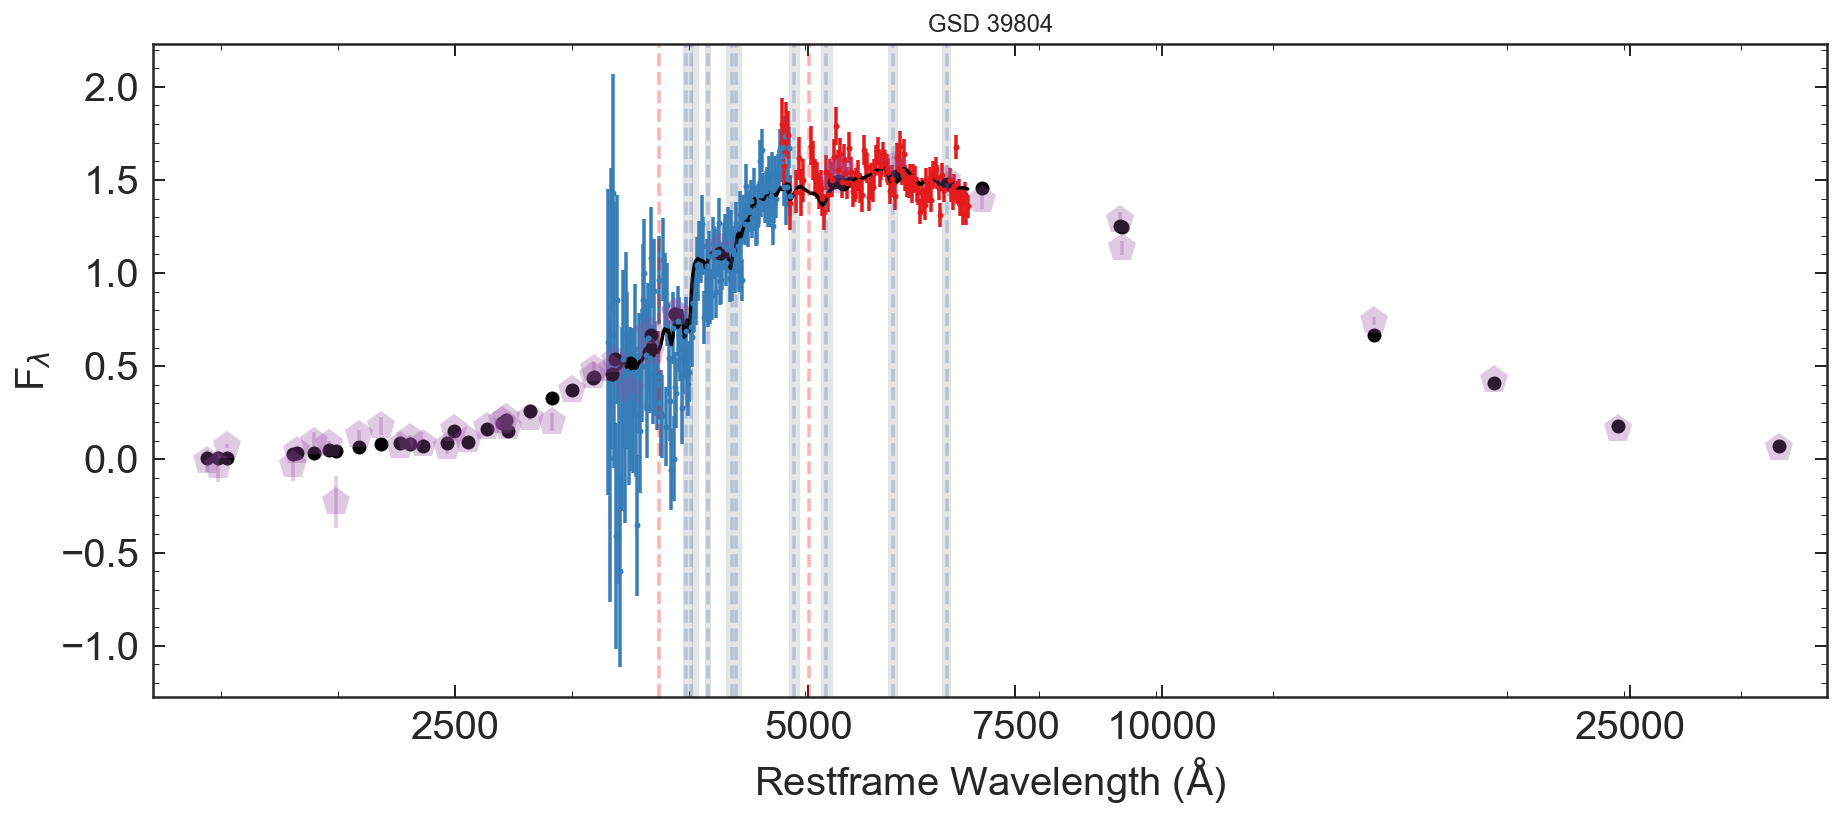

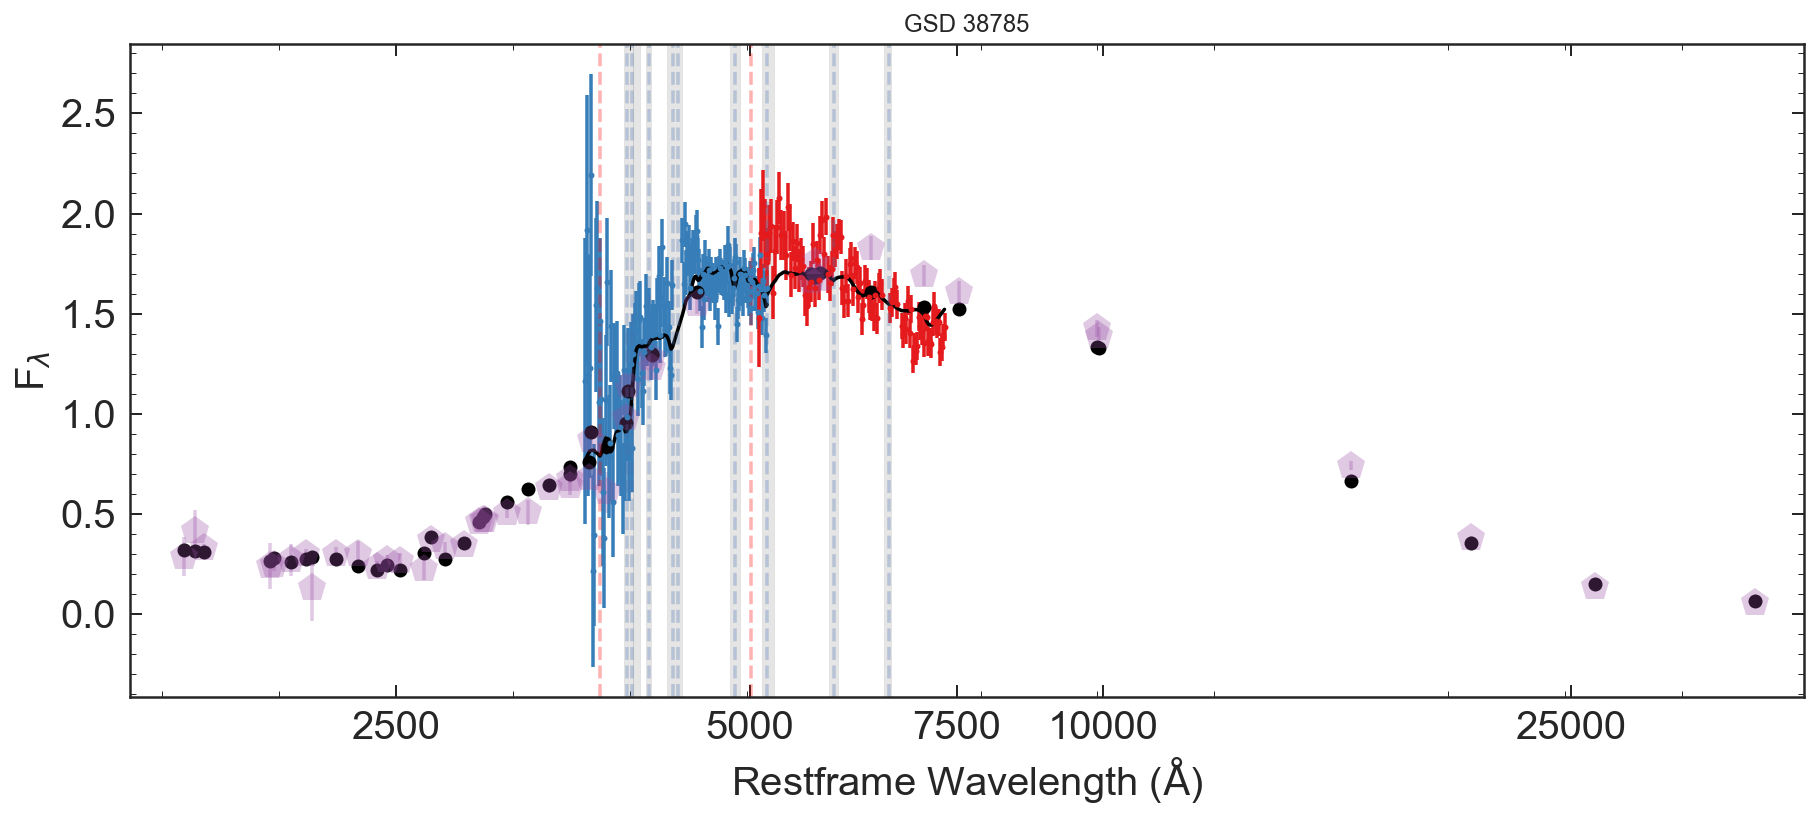

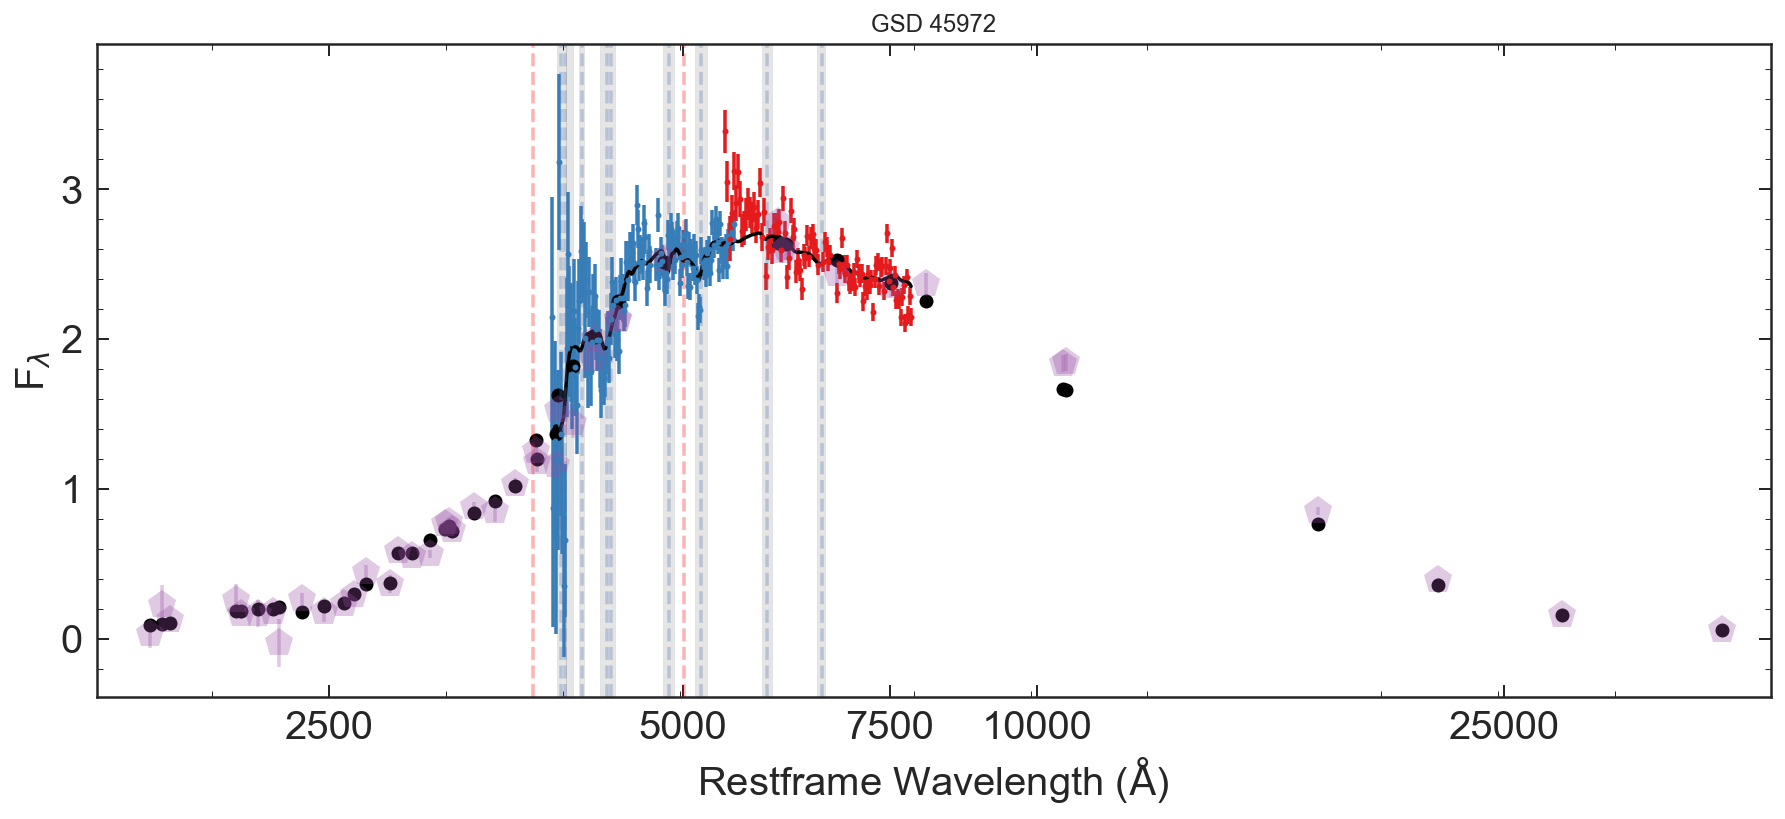

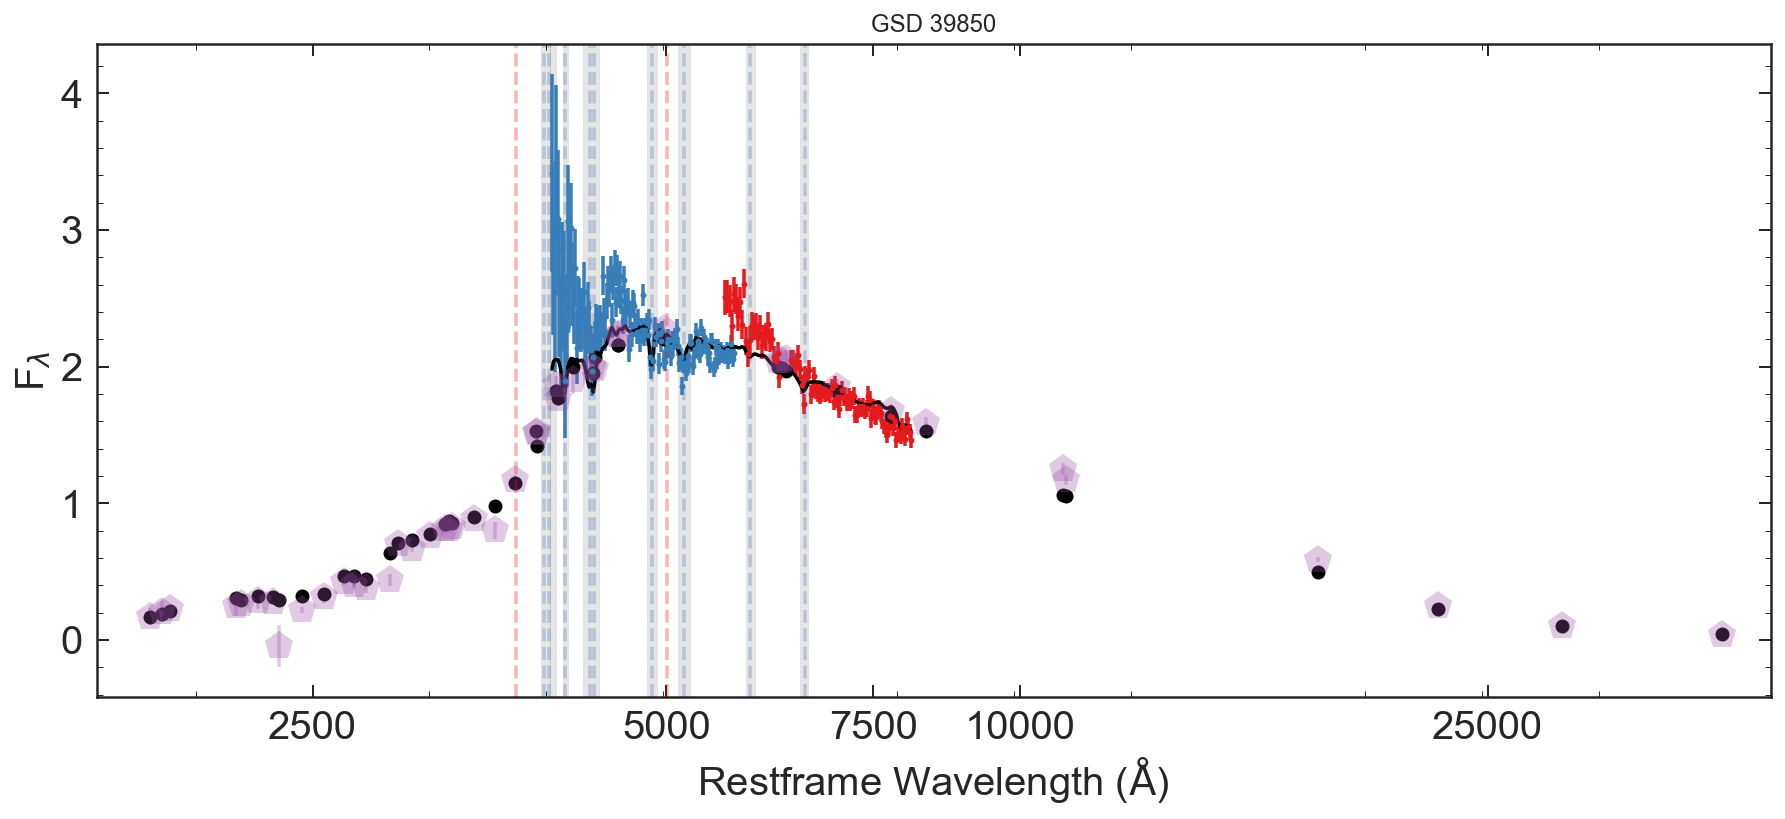

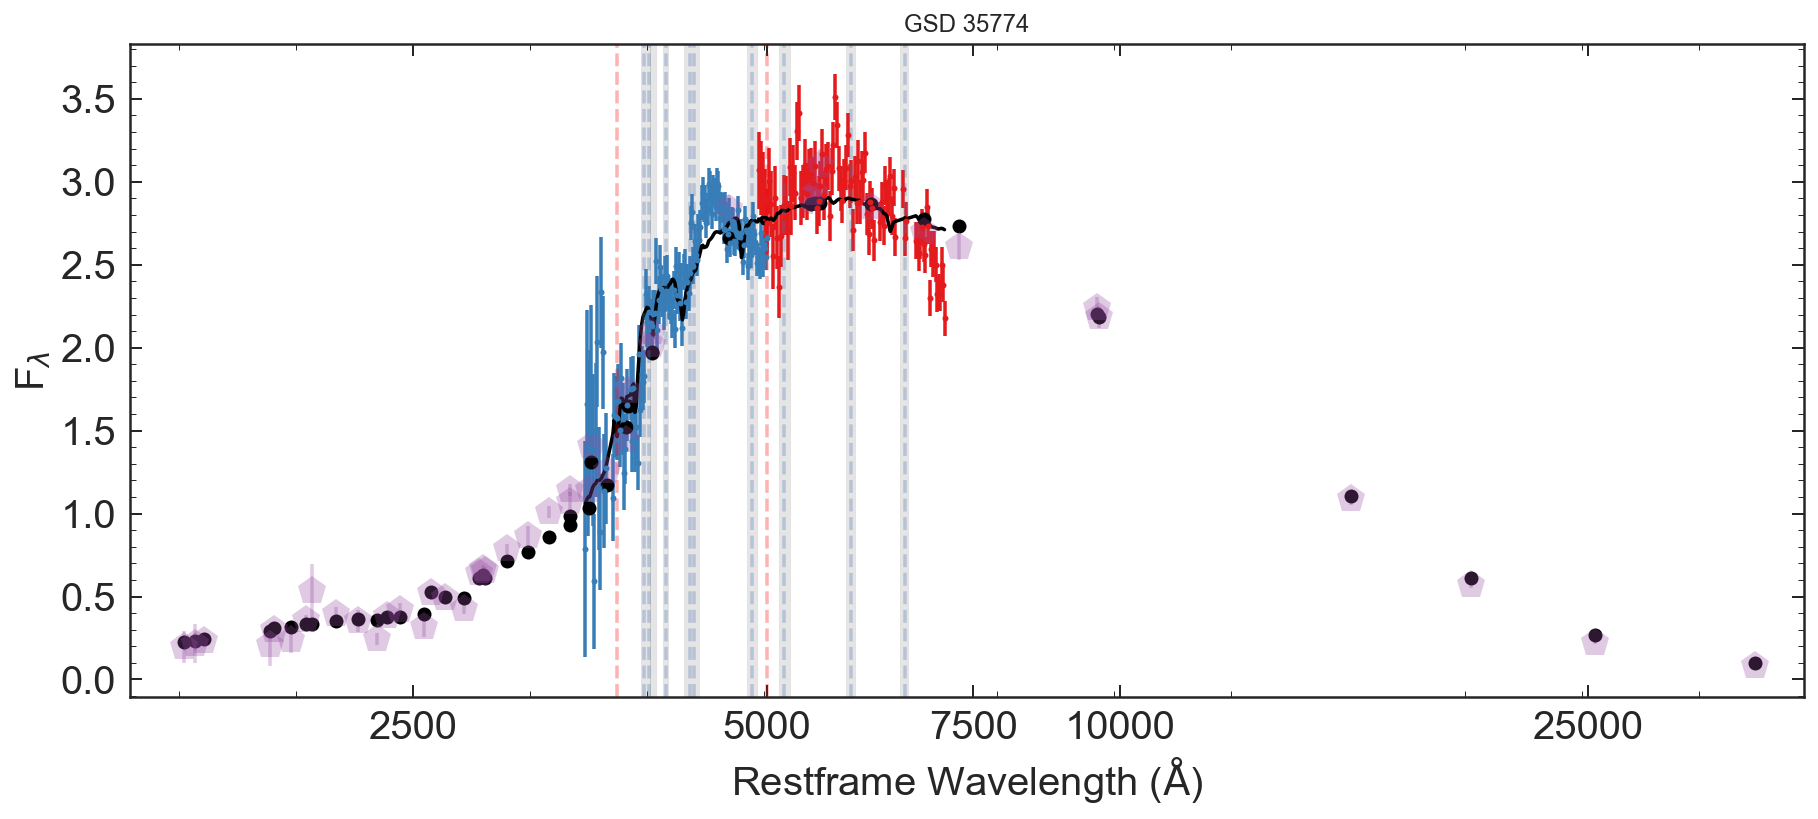

In [7]:
for i in range(len(galaxy)):
    bfm,bfa,bft,bfz,bfd = np.load('../data/bestfits/{0}_{1}_bestfits.npy'.format(snr_cat.field[i],snr_cat.id[i]))

    bfm,bfa,bft,bfz,bfd = np.array([bfm,bfa,bft,bfz,bfd]).astype(float)

    ## load in best fits, we can just use x[Px == max(Px)]
    ## use best fits to make model using fsps
    ## use premade option to simulate spectra
    
    GS = Gen_spec(snr_cat.field[i],snr_cat.id[i], bfz, mdl_err=False, phot_errterm = 0.03, decontam=True)
    GS.Sim_all(bfm,bfa,bft,bfz,bfd)

    fig = plt.figure(figsize=[15,6])
    plt.errorbar(np.log10(GS.Pwv_rf),GS.Pflx*1E18,GS.Perr*1E18,
                linestyle='None', marker='p', markersize=15, color='#984ea3', alpha=0.3)
    if GS.g102:
        plt.errorbar(np.log10(GS.Bwv_rf),GS.Bfl*1E18,GS.Ber*1E18,
                linestyle='None', marker='o', markersize=3, color='#377eb8')
        plt.plot(np.log10(GS.Bwv_rf), GS.Bmfl*1E18,'k')

    if GS.g141:
        plt.errorbar(np.log10(GS.Rwv_rf),GS.Rfl*1E18,GS.Rer*1E18,
                linestyle='None', marker='o', markersize=3, color='#e41a1c')
        plt.plot(np.log10(GS.Rwv_rf), GS.Rmfl*1E18,'k')

    plt.plot(np.log10(GS.Pwv_rf), GS.Pmfl*1E18,'ko')


    plt.ylabel('F$_\lambda$',size=20)
    plt.xlabel('Restframe Wavelength ($\\rm \AA$)',size=20)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.axvline(np.log10(3934.777),linestyle='--', alpha=.3)
    plt.axvline(np.log10(3969.588),linestyle='--', alpha=.3)
    plt.axvline(np.log10(4102.89),linestyle='--', alpha=.3)
    plt.axvline(np.log10(4305.61),linestyle='--', alpha=.3)
    plt.axvline(np.log10(4341.68),linestyle='--', alpha=.3)
    plt.axvline(np.log10(4862.68),linestyle='--', alpha=.3)
    plt.axvline(np.log10(5176.7),linestyle='--', alpha=.3)
    plt.axvline(np.log10(5895.6),linestyle='--', alpha=.3)
    plt.axvline(np.log10(6564),linestyle='--', alpha=.3)

    plt.axvline(np.log10(3727.092),linestyle='--', color='r',alpha=.3)
    plt.axvline(np.log10(5008.240),linestyle='--', color='r',alpha=.3)

    plt.axvspan(np.log10(3910), np.log10(3980), color='k', alpha=.1)
    plt.axvspan(np.log10(3980), np.log10(4030), color='k', alpha=.1)
    plt.axvspan(np.log10(4080), np.log10(4120), color='k', alpha=.1)
    plt.axvspan(np.log10(4250), np.log10(4380), color='k', alpha=.1)
    plt.axvspan(np.log10(4810), np.log10(4910), color='k', alpha=.1)
    plt.axvspan(np.log10(5120), np.log10(5240), color='k', alpha=.1)
    plt.axvspan(np.log10(5840), np.log10(5950), color='k', alpha=.1)
    plt.axvspan(np.log10(6500), np.log10(6600), color='k', alpha=.1)
    plt.xticks(np.log10([1000,2500,5000,7500,10000,25000]),[1000,2500,5000,7500,10000,25000])
    plt.title('{0} {1}'.format(snr_cat.field[i],snr_cat.id[i]))

    plt.xlim(np.log10(min(GS.Pwv_rf)*0.9),np.log10(max(GS.Pwv_rf)*1.1))

    plt.savefig('../plots/bestfits/{0}_{1}.png'.format(snr_cat.field[i],snr_cat.id[i]), bbox_inches = 'tight')


In [4]:
idx = 1
for i in snr_cat.index:
    if not os.path.isfile('../data/bestfits/{0}_{1}_bestfits.npy'.format(snr_cat.field[i],snr_cat.id[i])):
        print(snr_cat.field[i],snr_cat.id[i],idx)

    idx +=1

In [6]:
PWV , BWV, RWV =[[],[],[]]
PWVR , BWVR, RWVR =[[],[],[]]
PIE , BIE, RIE =[[],[],[]]
PE , BE, RE =[[],[],[]]

for i in snr_cat.index:
    try:

        g1,g2,bfm,bfa,bft,bfz,bfd = np.load('../data/bestfits/{0}_{1}_bestfits.npy'.format(snr_cat.field[i],snr_cat.id[i]))

        BFM, BFA, BFT, BFZ, BFD = np.array([bfm,bfa,bft,bfz,bfd]).astype(float)

        g1 = '../' + g1.replace('/fdata/scratch/vestrada78840/','')
        g2 = '../' + g2.replace('/fdata/scratch/vestrada78840/','')

        GS = Gen_spec(snr_cat.field[i],snr_cat.id[i], BFZ, g1, g2,
                      g102_lims=[7000, 12000], g141_lims=[10000, 18000], mdl_err = False, instr_err = False,phot_errterm = 0.0, decontam=True)

        GS.sp.params['logzsol'] = np.log10(BFM / 0.019)
        GS.sp.params['tau'] = BFT
        model_wave,model_flux = GS.sp.get_spectrum(tage = BFA, peraa = True)

        Pmfl = GS.Sim_phot_mult(model_wave * (1 + BFZ), model_flux * Salmon(BFD,model_wave))

        C = Scale_model(GS.Pflx, GS.Perr, Pmfl)

        PWV.extend(GS.Pwv)
        PWVR.extend(GS.Pwv_rf)
        PIE.extend(((GS.Pflx - C*Pmfl) / GS.Pflx)**2)
        PE.extend(((GS.Perr)/GS.Pflx)**2)

        if GS.g102: 
            Bmw, Bmfl = forward_model_grism(GS.Bbeam, model_wave * (1 + BFZ), model_flux * Salmon(BFD,model_wave))

            iBmfl = interp1d(Bmw, Bmfl)(GS.Bwv)
            C = Scale_model(GS.Bflx, GS.Berr, iBmfl)

            BWV.extend(GS.Bwv)
            BWVR.extend(GS.Bwv_rf)
            BIE.extend(((GS.Bflx - C*iBmfl) / GS.Bflx)**2)
            BE.extend(((GS.Berr)/GS.Bflx)**2)

        if GS.g141: 
            Rmw, Rmfl = forward_model_grism(GS.Rbeam, model_wave * (1 + BFZ), model_flux * Salmon(BFD, model_wave))

            iRmfl = interp1d(Rmw, Rmfl)(GS.Rwv)
            C = Scale_model(GS.Rflx, GS.Rerr, iRmfl)

            RWV.extend(GS.Rwv)
            RWVR.extend(GS.Rwv_rf)
            RIE.extend(((GS.Rflx - C*iRmfl) / GS.Rflx)**2)
            RE.extend(((GS.Rerr)/GS.Rflx)**2)

    except:
        print(snr_cat.field[i],snr_cat.id[i])

cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:250: RuntimeWarning: divide by zero encountered in log10
  delta = 0.62 * np.log10(Av/Rv) + 0.26
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:252: RuntimeWarning: invalid value encountered in multiply
  sal = 10**(-0.4*k*(lam / lamv)**(delta)*Av/Rv)
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:259: RuntimeWarning: divide by zero encountered in log10
  delta = 0.62 * np.log10(Av/Rv) + 0.26
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:261: RuntimeWarning: invalid value encountered in multiply
  sal = 10**(-0.4*k*(lam / lamv)**(delta)*Av/Rv)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned
missing g102
missing g141


/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:250: RuntimeWarning: divide by zero encountered in log10
  delta = 0.62 * np.log10(Av/Rv) + 0.26
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:252: RuntimeWarning: invalid value encountered in multiply
  sal = 10**(-0.4*k*(lam / lamv)**(delta)*Av/Rv)
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:259: RuntimeWarning: divide by zero encountered in log10
  delta = 0.62 * np.log10(Av/Rv) + 0.26
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:261: RuntimeWarning: invalid value encountered in multiply
  sal = 10**(-0.4*k*(lam / lamv)**(delta)*Av/Rv)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


missing g141
cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:250: RuntimeWarning: divide by zero encountered in log10
  delta = 0.62 * np.log10(Av/Rv) + 0.26
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:252: RuntimeWarning: invalid value encountered in multiply
  sal = 10**(-0.4*k*(lam / lamv)**(delta)*Av/Rv)
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:259: RuntimeWarning: divide by zero encountered in log10
  delta = 0.62 * np.log10(Av/Rv) + 0.26
/Users/Vince.ec/

cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:250: RuntimeWarning: divide by zero encountered in log10
  delta = 0.62 * np.log10(Av/Rv) + 0.26
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:252: RuntimeWarning: invalid value encountered in multiply
  sal = 10**(-0.4*k*(lam / lamv)**(delta)*Av/Rv)
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:259: RuntimeWarning: divide by zero encountered in log10
  delta = 0.62 * np.log10(Av/Rv) + 0.26
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:261: RuntimeWarning: invalid value encountered in multiply
  sal = 10**(-0.4*k*(lam / lamv)**(delta)*Av/Rv)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:250: RuntimeWarning: divide by zero encountered in log10
  delta = 0.62 * np.log10(Av/Rv) + 0.26
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:252: RuntimeWarning: invalid value encountered in multiply
  sal = 10**(-0.4*k*(lam / lamv)**(delta)*Av/Rv)
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:259: RuntimeWarning: divide by zero encountered in log10
  delta = 0.62 * np.log10(Av/Rv) + 0.26
/Users/Vince.ec/

cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


missing g102


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


missing g141


/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:250: RuntimeWarning: divide by zero encountered in log10
  delta = 0.62 * np.log10(Av/Rv) + 0.26
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:252: RuntimeWarning: invalid value encountered in multiply
  sal = 10**(-0.4*k*(lam / lamv)**(delta)*Av/Rv)
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:259: RuntimeWarning: divide by zero encountered in log10
  delta = 0.62 * np.log10(Av/Rv) + 0.26
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:261: RuntimeWarning: invalid value encountered in multiply
  sal = 10**(-0.4*k*(lam / lamv)**(delta)*Av/Rv)


cleaned
missing g102
missing g141
cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


missing g141
cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:250: RuntimeWarning: divide by zero encountered in log10
  delta = 0.62 * np.log10(Av/Rv) + 0.26
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:252: RuntimeWarning: invalid value encountered in multiply
  sal = 10**(-0.4*k*(lam / lamv)**(delta)*Av/Rv)
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:259: RuntimeWarning: divide by zero encountered in log10
  delta = 0.62 * np.log10(Av/Rv) + 0.26
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:261: RuntimeWarning: invalid value encountered in multiply
  sal = 10**(-0.4*k*(lam / lamv)**(delta)*Av/Rv)


missing g102


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:250: RuntimeWarning: divide by zero encountered in log10
  delta = 0.62 * np.log10(Av/Rv) + 0.26
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:252: RuntimeWarning: invalid value encountered in multiply
  sal = 10**(-0.4*k*(lam / lamv)**(delta)*Av/Rv)
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:259: RuntimeWarning: divide by zero encountered in log10
  delta = 0.62 * np.log10(Av/Rv) + 0.26
/Users/Vince.ec/

cleaned
missing g102
missing g141
cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


missing g141
cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:250: RuntimeWarning: divide by zero encountered in log10
  delta = 0.62 * np.log10(Av/Rv) + 0.26
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:252: RuntimeWarning: invalid value encountered in multiply
  sal = 10**(-0.4*k*(lam / lamv)**(delta)*Av/Rv)
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:259: RuntimeWarning: divide by zero encountered in log10
  delta = 0.62 * np.log10(Av/Rv) + 0.26
/Users/Vince.ec/

cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


missing g102


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:250: RuntimeWarning: divide by zero encountered in log10
  delta = 0.62 * np.log10(Av/Rv) + 0.26
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:252: RuntimeWarning: invalid value encountered in multiply
  sal = 10**(-0.4*k*(lam / lamv)**(delta)*Av/Rv)
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:259: RuntimeWarning: divide by zero encountered in log10
  delta = 0.62 * np.log10(Av/Rv) + 0.26
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:261: RuntimeWarning: invalid value encountered in multiply
  sal = 10**(-0.4*k*(lam / lamv)**(delta)*Av/Rv)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


missing g102


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


missing g102


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:250: RuntimeWarning: divide by zero encountered in log10
  delta = 0.62 * np.log10(Av/Rv) + 0.26
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:252: RuntimeWarning: invalid value encountered in multiply
  sal = 10**(-0.4*k*(lam / lamv)**(delta)*Av/Rv)
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:259: RuntimeWarning: divide by zero encountered in log10
  delta = 0.62 * np.log10(Av/Rv) + 0.26
/Users/Vince.ec/

cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


In [7]:
IDP = np.argsort(PWV)
IDB = np.argsort(BWV)
IDR = np.argsort(RWV)

In [8]:
orderedpwv = list(set(PWV))

In [9]:
intrerr = []
nerr = []

for i in orderedpwv:
    ie = []
    ne = []
    for ii in IDP:
        if i == PWV[ii]:
            ie.append(PIE[ii])
            ne.append(PE[ii])
    intrerr.append(ie)
    nerr.append(ne)

In [10]:
mie = [np.median(U) for U in intrerr] 
me = [np.median(U) for U in nerr] 

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


([<matplotlib.axis.XTick at 0x1a7a1313c8>,
 <a list of 6 Text xticklabel objects>)

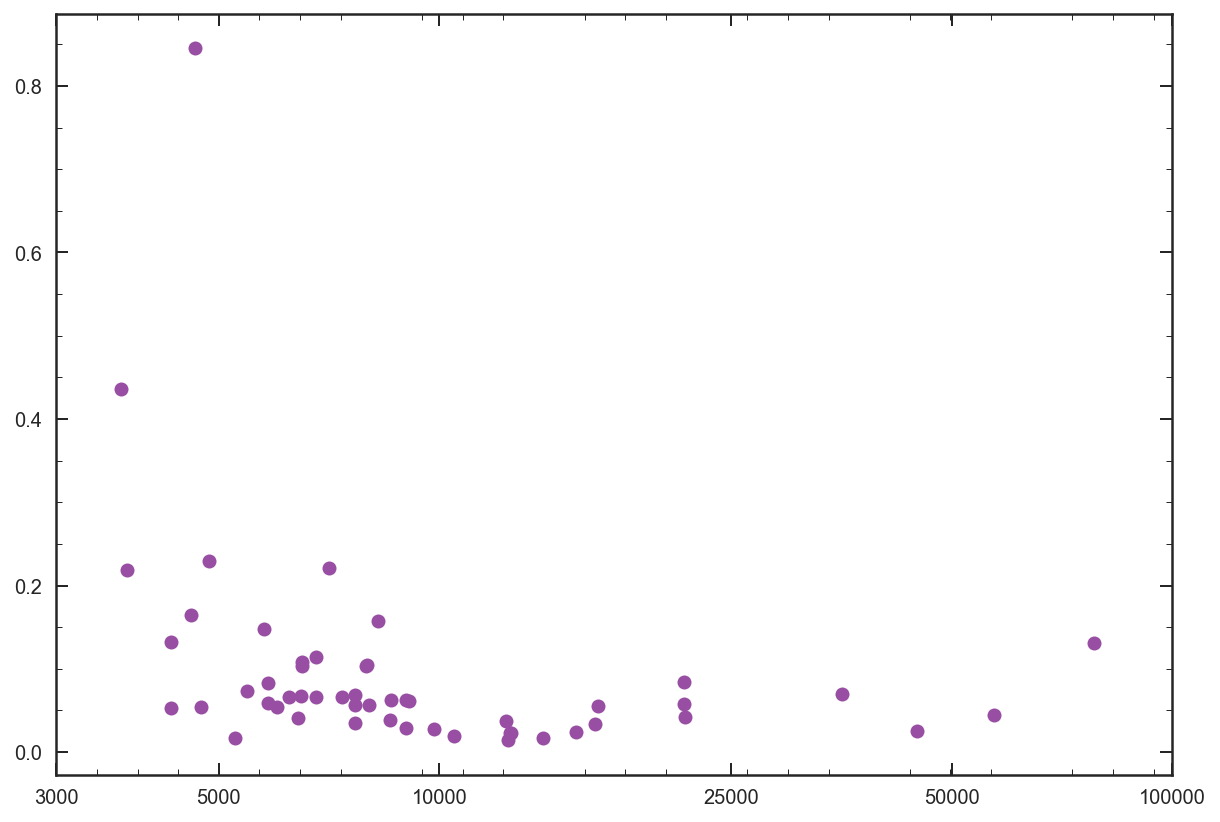

In [21]:
plt.figure(figsize=[10,7])
plt.plot(np.log10(orderedpwv), np.sqrt(np.array(mie) - np.array(me)), 'o', color='#984ea3')
plt.xticks(np.log10([3000,5000,10000,25000,50000,100000]),[3000,5000,10000,25000,50000,100000])

In [22]:
def Run_bin_stat(wv,tmp,bin_size):
    wv = wv[tmp**2 > 0]
    tmp = tmp[tmp**2 > 0]
    
    
    wv_med = [] ; wv_mean = [] ; binned_data = []

    low_lim = min(wv)
    while low_lim <= max(wv):
        IDX = [U for U in range(len(wv)) if low_lim <= wv[U] < low_lim + bin_size]
        wv_med.append(np.median(wv[IDX]))
        wv_mean.append(np.median(low_lim + bin_size / 2))
        binned_data.append(np.median(tmp[IDX]))
        low_lim += bin_size
    return np.array(wv_med), np.array(wv_mean), np.array(binned_data)

In [23]:
BWV_med, BWV_mean, BIE_bin = Run_bin_stat(np.array(BWV)[IDB], np.array(BIE)[IDB],100)
BWV_med, BWV_mean, BE_bin = Run_bin_stat(np.array(BWV)[IDB], np.array(BE)[IDB],100)

RWV_med, RWV_mean, RIE_bin = Run_bin_stat(np.array(RWV)[IDR], np.array(RIE)[IDR],100)
RWV_med, RWV_mean, RE_bin = Run_bin_stat(np.array(RWV)[IDR], np.array(RE)[IDR],100)

In [24]:
intr_err_b = BIE_bin - BE_bin
intr_err_r = RIE_bin - RE_bin

intr_err_b[intr_err_b < 0] = 0
intr_err_r[intr_err_r < 0] = 0

In [25]:
rwv = np.arange(min(RWV), max(RWV) + 500, 500)
rief = [0.18, 0.09, 0.01,0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.03, 0.15, 0.18]

rwvs = np.arange(min(RWV), max(RWV) + 10, 5)
irief = interp1d(rwv,rief)(rwvs)

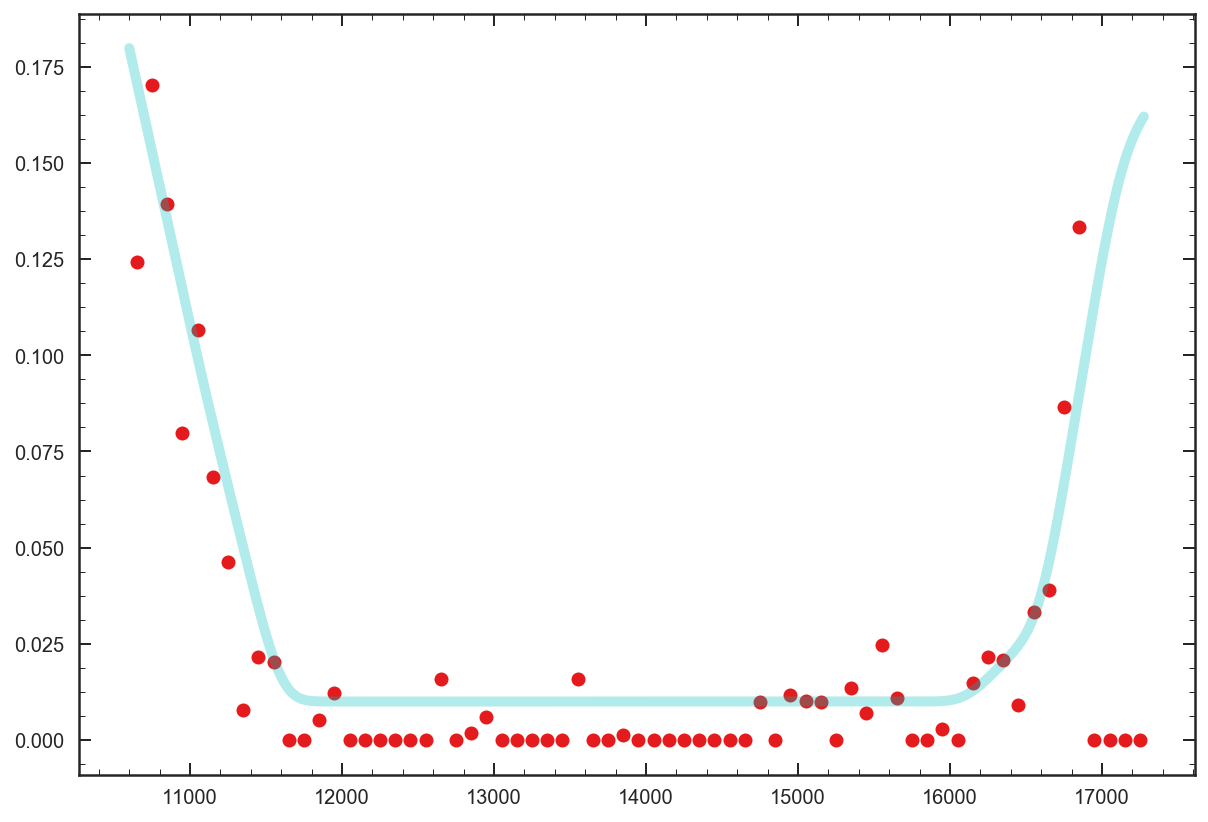

In [28]:
plt.figure(figsize=[10,7])

# plt.plot(BWV_mean, np.sqrt(intr_err_b), 'o', color='#377eb8')

plt.plot(RWV_mean, np.sqrt(intr_err_r), 'o', color='#e41a1c')
# plt.plot(rwv,rief, 'k')
plt.plot(rwvs, Smooth(irief,rwvs,100), 'c', linewidth = 5, alpha = 0.3)



In [258]:
# np.save('../templates/intr_EF_phot',[orderedpwv, np.sqrt(np.array(mie) - np.array(me))])
# np.save('../templates/intr_EF_g141',[rwvs, Smooth(irief,rwvs,100)])

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


In [29]:
IDPR = np.argsort(PWVR)
IDBR = np.argsort(BWVR)
IDRR = np.argsort(RWVR)

In [30]:
PWVR_med, PWVR_mean, PME_bin = Run_bin_stat(np.log10(PWVR)[IDPR], np.array(PIE)[IDPR],.01)
PWVR_med, PWVR_mean, PE_bin = Run_bin_stat(np.log10(PWVR)[IDPR], np.array(PE)[IDP],.01)

BWVR_med, BWVR_mean, BME_bin = Run_bin_stat(np.array(BWVR)[IDBR], np.array(BIE)[IDBR],100)
BWVR_med, BWVR_mean, BE_bin = Run_bin_stat(np.array(BWVR)[IDBR], np.array(BE)[IDBR],100)

RWVR_med, RWVR_mean, RME_bin = Run_bin_stat(np.array(RWVR)[IDRR], np.array(RIE)[IDRR],100)
RWVR_med, RWVR_mean, RE_bin = Run_bin_stat(np.array(RWVR)[IDRR], np.array(RE)[IDRR],100)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [31]:
awv = np.arange(500, max(PWVR) + 500, 500)
amef = [1.4,1.4, 0.4, 0.12, 0.09, 0.07, 0.06, 0.05, 0.035, 0.025, 0.02, 0.015,
       0.015, 0.015, 0.02, 0.03, 0.035, 0.04, 0.05, 0.08, 0.09, 0.1, 0.08,
       0.075, 0.07, 0.065, 0.06, 0.055, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.06, 0.07,
       0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.175,
       0.18, 0.18, 0.185, 0.185, 0.19, 0.19, 0.195, 0.195, 0.2]

# rwvs = np.arange(min(RWV), max(RWV) + 10, 5)
# irief = interp1d(rwv,rief)(rwvs)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


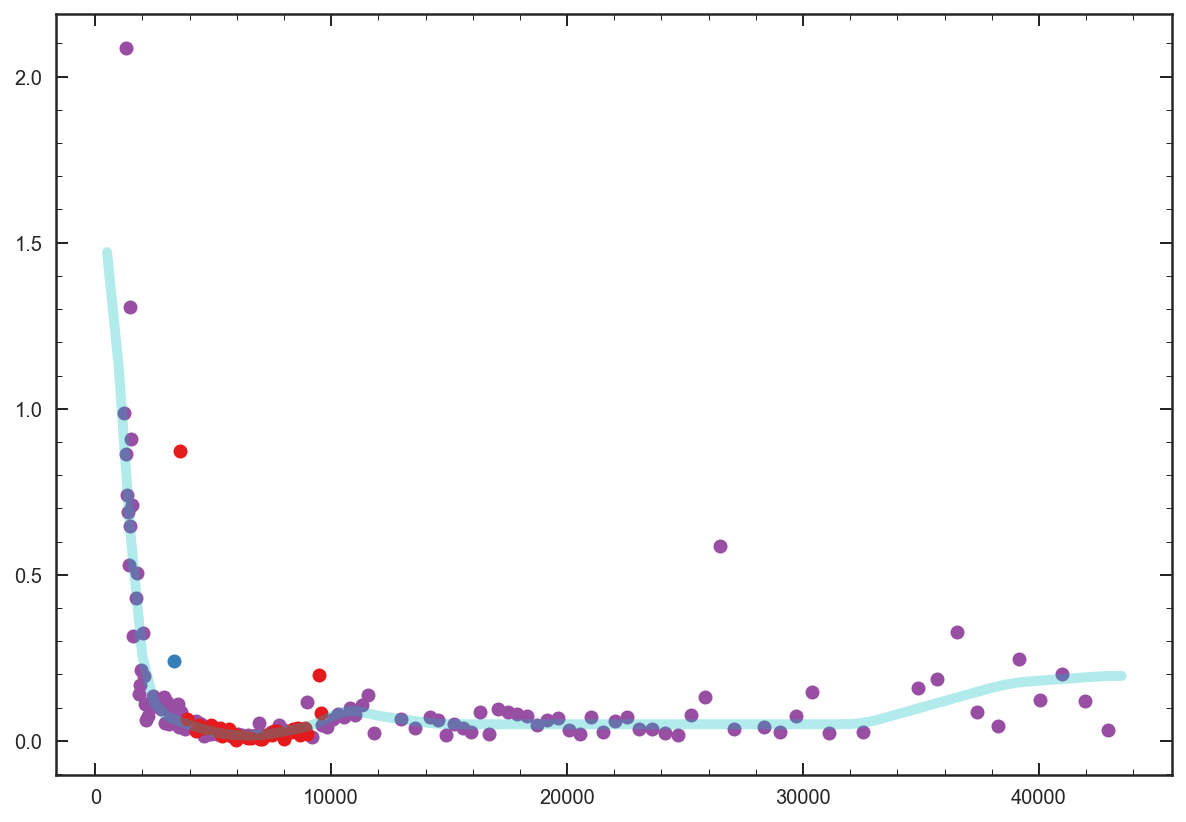

In [35]:
plt.figure(figsize=[10,7])
plt.plot(10**PWVR_mean, np.sqrt(PME_bin-PE_bin), 'o', color='#984ea3')
plt.plot(BWVR_mean, np.sqrt(BME_bin-BE_bin), 'o', color='#377eb8')
plt.plot(RWVR_mean, np.sqrt(RME_bin-RE_bin), 'o', color='#e41a1c')
# plt.plot(awv, amef)
plt.plot(awv, Smooth(amef,awv,500),'c',linewidth=5, alpha=0.3)
# plt.xticks(np.log10([3000,5000,10000,25000,50000,100000]),[3000,5000,10000,25000,50000,100000])

In [420]:
np.save('../templates/mdl_EF',[awv, Smooth(amef,awv,500)])

In [12]:
Gs1 = Gen_spec('GND', 21156, 1.2529, '../beams/o151.0_21156.g102.A.fits', '../beams/o300.0_21156.g141.A.fits',
                   g102_lims=[7000, 12000], g141_lims=[10000, 18000],
                   phot_errterm = 0.03, decontam = True)

Gs2 = Gen_spec('GND', 21156, 1.2529, '../beams/o151.0_21156.g102.A.fits', '../beams/o300.0_21156.g141.A.fits',
                   g102_lims=[7000, 12000], g141_lims=[10000, 18000], mdl_err = False,
                   instr_err = False, phot_errterm = 0.03, decontam = True)  

cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


<ErrorbarContainer object of 3 artists>

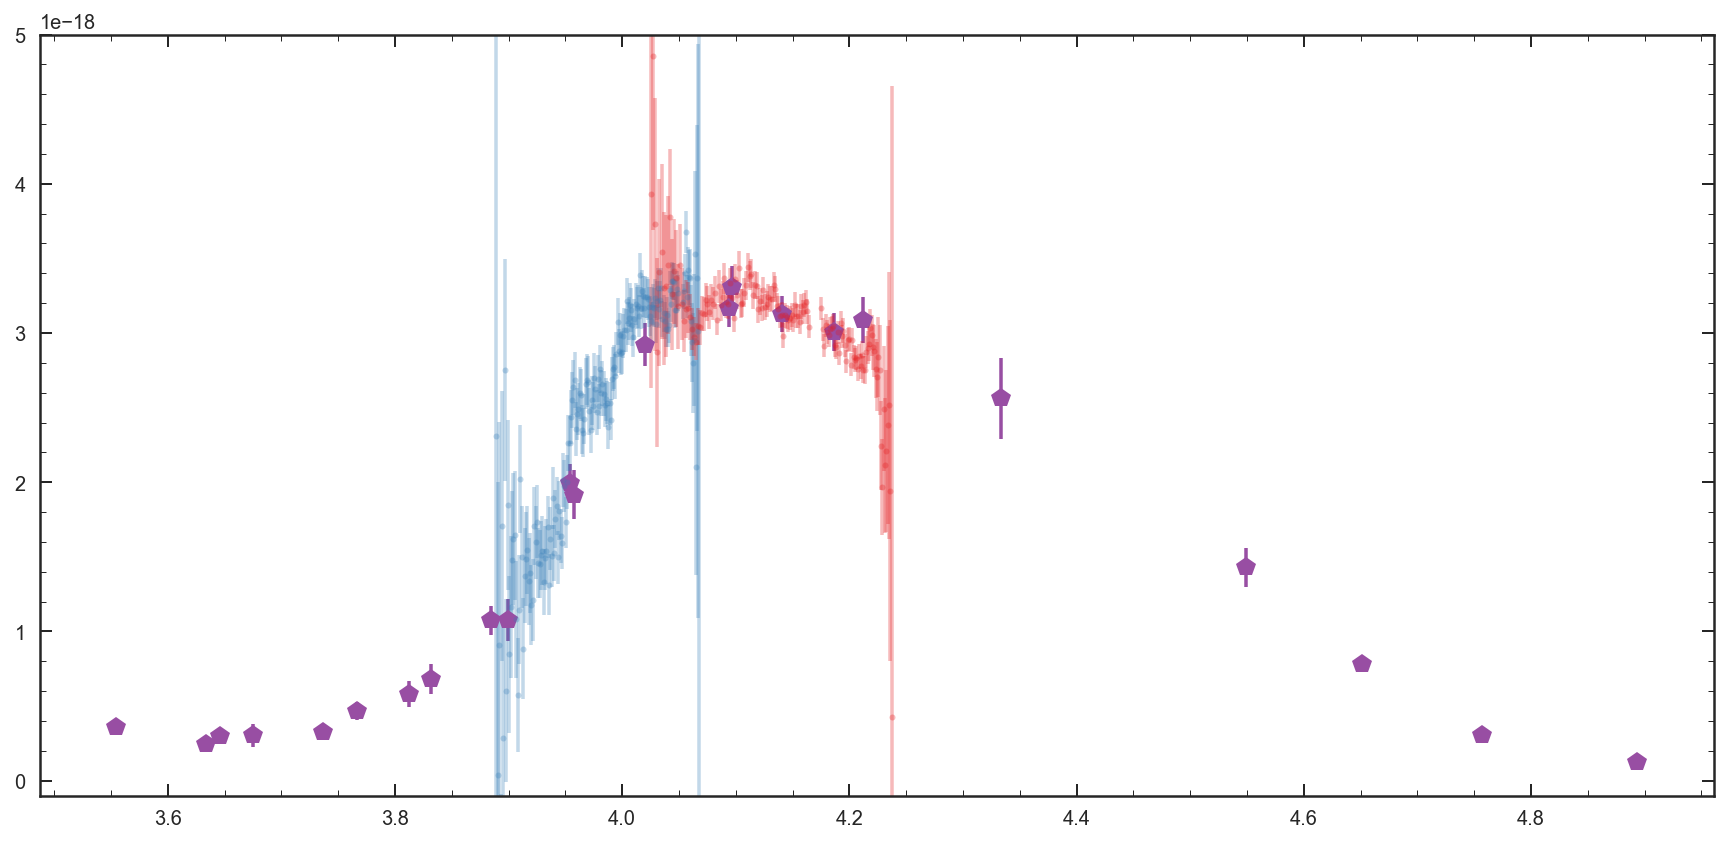

In [13]:
plt.figure(figsize=[15,7])
plt.errorbar(np.log10(Gs1.Pwv), Gs1.Pflx, Gs1.Perr,
                             linestyle='None', marker='p', markersize=10, color='#984ea3')

plt.ylim(-.1E-18,5E-18)

plt.errorbar(np.log10(Gs1.Bwv),Gs1.Bfl, Gs1.Ber,
                             linestyle='None', marker='o', markersize=3, color='#377eb8', alpha=.3)

plt.errorbar(np.log10(Gs1.Rwv), Gs1.Rfl, Gs1.Rer,
            linestyle='None', marker='o', markersize=3, color='#e41a1c', alpha=.3)

<ErrorbarContainer object of 3 artists>

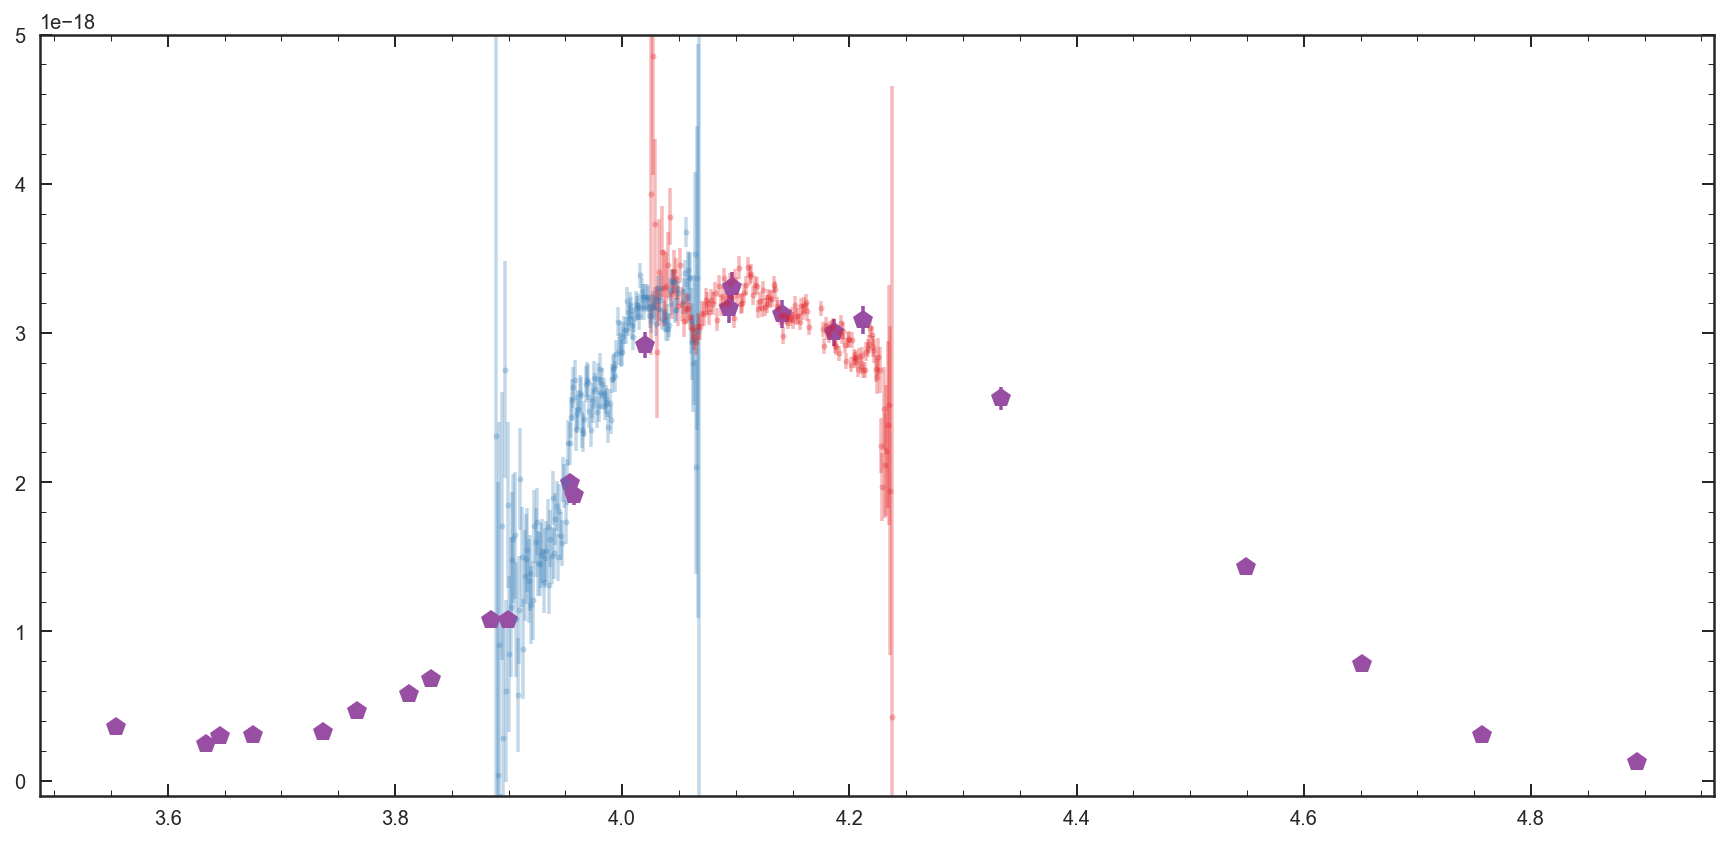

In [14]:
plt.figure(figsize=[15,7])
plt.errorbar(np.log10(Gs2.Pwv), Gs2.Pflx, Gs2.Perr,
                             linestyle='None', marker='p', markersize=10, color='#984ea3')

plt.ylim(-.1E-18,5E-18)

plt.errorbar(np.log10(Gs2.Bwv),Gs2.Bfl, Gs2.Ber,
                             linestyle='None', marker='o', markersize=3, color='#377eb8', alpha=.3)

plt.errorbar(np.log10(Gs2.Rwv), Gs2.Rfl, Gs2.Rer,
            linestyle='None', marker='o', markersize=3, color='#e41a1c', alpha=.3)

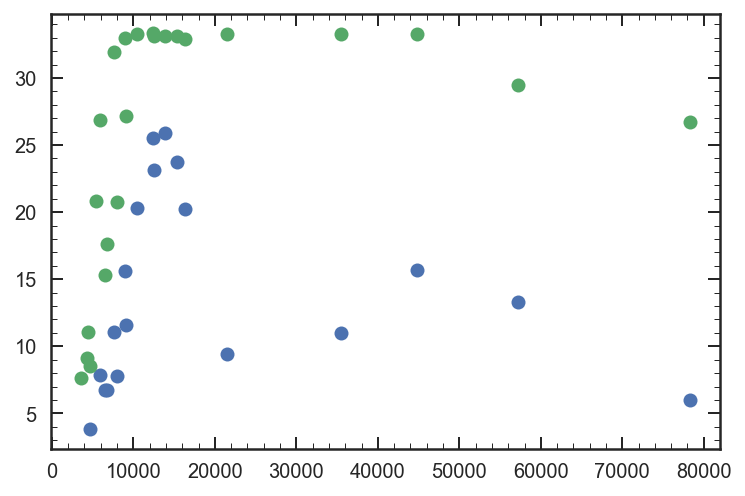

In [17]:
plt.plot(Gs1.Pwv,Gs1.Pflx / Gs1.Perr, 'o')
plt.plot(Gs2.Pwv,Gs2.Pflx / Gs2.Perr,'o')

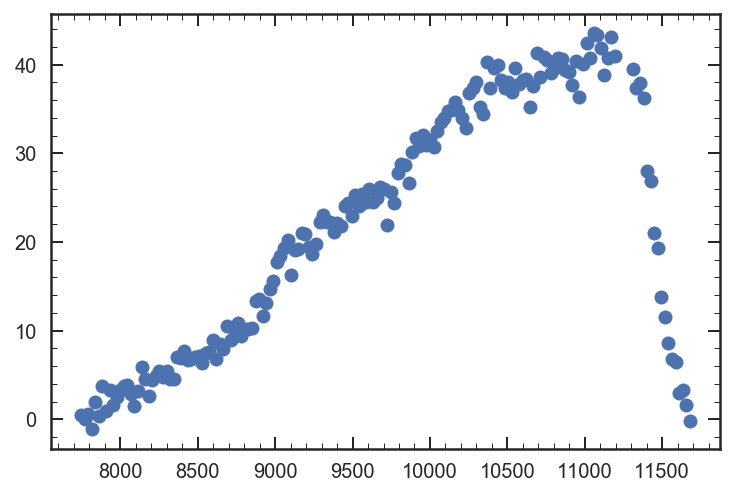

In [21]:
# plt.plot(Gs1.Bwv,Gs1.Bflx / Gs1.Berr, 'o')
plt.plot(Gs2.Bwv,Gs2.Bflx / Gs2.Berr,'o')

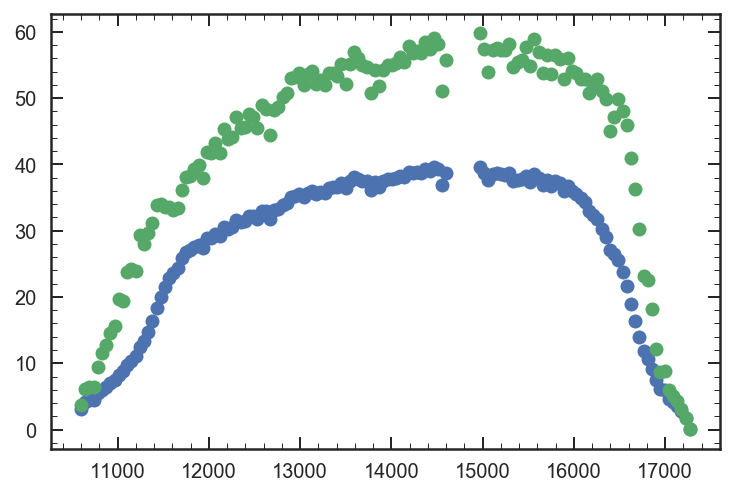

In [19]:
plt.plot(Gs1.Rwv,Gs1.Rflx / Gs1.Rerr, 'o')
plt.plot(Gs2.Rwv,Gs2.Rflx / Gs2.Rerr,'o')